# Combined Feature Selection Method using Symbolic Relevance in Text Clustering

## Import Library

### For all section

In [1]:
# init
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
# import nltk
# nltk.download()

### For import documents

In [ ]:
import glob
import os

### For preprocessing

In [3]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

### For feature forming

In [23]:
from textblob import TextBlob

### For feature selection & term weighting

In [2]:
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import spdiags

### For clustering

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from numpyencoder import NumpyEncoder

### For performance analysis

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_mutual_info_score

### For plot result

In [21]:
from matplotlib import pyplot as plt

## Import Documents

### Implementation and export csv

In [ ]:
# import pubmed
pubmed = []
docList = glob.glob(os.path.join(os.getcwd(), "Datasets/pubmed/", "*.txt"))

for docPath in tqdm(docList):
    # get doc file name
    docName = os.path.basename(docPath).split('.')[0]
    className = docName[:3]
    
    with open(docPath, encoding="utf8") as doc:
        # insert [class, docs, feature]
        pubmed.append([className, docName, doc.read().replace('\n', ' ')])

# make dataframe
dataframe = pd.DataFrame(data=pubmed, columns=['class', 'document', 'feature']) 

# export pubmed raw
dataframe.to_csv('pubmed/raw.csv', index=False)

In [ ]:
# import scopus
scopus = []
docList = glob.glob(os.path.join(os.getcwd(), "Datasets/scopus/", "*"))

for docPath in tqdm(docList):
    # get doc file name
    docName = os.path.basename(docPath)
    className = docName.split('-')[0]
    
    with open(docPath, encoding="utf8") as doc:
        # insert [class, docs, feature]
        scopus.append([className, docName, doc.read().replace('\n', ' ')])

# make dataframe
dataframe = pd.DataFrame(data=scopus, columns=['class', 'document', 'feature']) 

# export pubmed raw
dataframe.to_csv('scopus/raw.csv', index=False)

### Read dataframe raw

In [ ]:
# read csv
pubmedRaw = pd.read_csv('pubmed/raw.csv')
scopusRaw = pd.read_csv('scopus/raw.csv')

# get feature
pubmedFeatures = pubmedRaw.loc[:, 'feature']
scopusFeatures = scopusRaw.loc[:, 'feature']
scopusFeatures

## Preprocessing

### Preprocessing methods

In [7]:
# cleaning
def cleaning(features):
    result = []
    for feature in features:
        regex = re.sub(r'[^a-zA-Z\s]', '', feature)
        result.append(regex)
    return result

# case folding
def caseFolding(features):
    result = []
    for feature in features:
        lower = feature.lower()
        result.append(lower)
    return result

# tokenization
def tokenization(features):
    result = []
    for feature in features:
        token = word_tokenize(feature)
        result.append(token)
    return result

# stopwords removal
def stopWords(features):
    result = []
    stopWords = set(stopwords.words('english'))
    for token in features:
        cleanedFeature = [feature for feature in token if feature not in stopWords]
        result.append(cleanedFeature)
    return result

### Implementation and export csv

In [ ]:
# run this section first!: import documents > read dataframe raw

# preprocessing
def preprocessing(features):
    clean = cleaning(features)
    case = caseFolding(clean)
    token = tokenization(case)
    preprocessed = stopWords(token)
    return preprocessed
    
pubmedPreprocessed = preprocessing(pubmedFeatures)
scopusPreprocessed = preprocessing(scopusFeatures)
# print(scopusPreprocessed[0])

# export pubmed clean
for i in range(len(pubmedPreprocessed)):
    pubmedRaw.loc[i, 'feature'] = ' '.join(pubmedPreprocessed[i])
pubmedRaw.to_csv('pubmed/clean.csv', index=False)

# export scopus clean
for i in range(len(scopusPreprocessed)):
    scopusRaw.loc[i, 'feature'] = ' '.join(scopusPreprocessed[i])
scopusRaw.to_csv('scopus/clean.csv', index=False)

### Read dataframe clean

In [4]:
# read csv
pubmedClean = pd.read_csv('pubmed/clean.csv')
scopusClean = pd.read_csv('scopus/clean.csv')

# get feature
pubmedFeatures = pubmedClean.loc[:, 'feature']
scopusFeatures = scopusClean.loc[:, 'feature']
scopusClean

,class,document,feature
0,CONCRETE,CONCRETE-2015-1,modeling diffusion sulfate concrete using mixt...
1,CONCRETE,CONCRETE-2015-10,experimental study flexural behavior recycled ...
2,CONCRETE,CONCRETE-2015-100,shaking table test numerical analysis highrise...
3,CONCRETE,CONCRETE-2015-101,stateoftheart literature review concrete mesos...
4,CONCRETE,CONCRETE-2015-102,flexural tensile properties plastic concrete r...
...,...,...,...
2795,TECTONICPLATES,TECTONICPLATES-2015-95,playing jigsaw large igneous provinces plate t...
2796,TECTONICPLATES,TECTONICPLATES-2015-96,tidal sensitivity tectonic tremors nankai casc...
2797,TECTONICPLATES,TECTONICPLATES-2015-97,focal mechanisms tectonic stress field northso...
2798,TECTONICPLATES,TECTONICPLATES-2015-98,seismic anisotropy crust northeast margin tibe...


## Feature Forming

### Implementation and export csv

In [ ]:
# run this section first!: preprocessing > read dataframe clean

# feature forming
def featureForming(features, dataframe):
    # BOAW
    dataframe.rename(columns={'feature': 'BOAW'}, inplace=True)
    for i in tqdm(range(len(features))):
        # BON
        dataframe.loc[i, 'BON'] = ' '.join(TextBlob(features[i]).noun_phrases)
        # BONA
        dataframe.loc[i, 'BONA'] = ' '.join([word for (word, tag) in TextBlob(features[i]).tags if tag[:2]=='NN' or tag[:2]=='JJ'])

featureForming(pubmedFeatures, pubmedClean)
featureForming(scopusFeatures, scopusClean)
# print(scopusClean)

# export csv
pubmedClean.to_csv('pubmed/formed.csv', index=False)
scopusClean.to_csv('scopus/formed.csv', index=False)

### Read dataframe formed

In [5]:
# read csv
pubmedFormed = pd.read_csv('pubmed/formed.csv')
scopusFormed = pd.read_csv('scopus/formed.csv')

# get feature
# pubmed
pubmedClass = pubmedFormed.loc[:, 'class']
pubmed_boaw = pubmedFormed.loc[:, 'BOAW']
pubmed_bon = pubmedFormed.loc[:, 'BON']
pubmed_bona = pubmedFormed.loc[:, 'BONA']

# scopus
scopusClass = scopusFormed.loc[:, 'class']
scopus_boaw = scopusFormed.loc[:, 'BOAW']
scopus_bon = scopusFormed.loc[:, 'BON']
scopus_bona = scopusFormed.loc[:, 'BONA']
scopusClass

0             CONCRETE
1             CONCRETE
2             CONCRETE
3             CONCRETE
4             CONCRETE
             ...      
2795    TECTONICPLATES
2796    TECTONICPLATES
2797    TECTONICPLATES
2798    TECTONICPLATES
2799    TECTONICPLATES
Name: class, Length: 2800, dtype: object

## Feature Selection

### SFS method

In [ ]:
# SFS
def symbolic(features, classes):
    # get tf weights
    tfVec = CountVectorizer()
    tf = tfVec.fit_transform(features)

    # define weights into dataframe
    featureName = tfVec.get_feature_names_out()
    featureWeight = tf.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    df.loc[:, 'class'] = classes
    # return df

    # count mean & standard deviation
    mean = df.groupby('class').mean().reset_index()
    std = df.groupby('class').std().reset_index()

    totalSm = []
    for col in tqdm(mean.columns):
        if col != 'class':
            # count interval per features
            interval = []
            for row in range(len(mean)):
                meanA = mean.loc[row, col]
                stdA = std.loc[row, col]
                interval.append([meanA - stdA, meanA + stdA])
            
            # count similarity per feature
            similarity = 0
            for itvA in interval:
                # count similarity per class
                smClass = []
                for itvB in interval:
                    if itvA != itvB:
                        # check if interval B equals 0
                        sm = 0
                        if (itvB[1] - itvB[0]) != 0:
                            sm = (min(itvA[1], itvB[1]) - max(itvA[0], itvB[0])) / (itvB[1] - itvB[0])
                        smClass.append(sm)

                # count total similarity
                similarity += np.sum(smClass)
            totalSm.append(similarity)

    # count average total similarity
    avgTotalSm = np.mean(totalSm)

    # select feature that totalSm > avgTotalSm
    selected = []
    for i in range(len(totalSm)):
        if totalSm[i] > avgTotalSm:
            selected.append(df.columns[i])
    # return len(selected)
    return selected

# sfx = symbolic(scopus_boaw, scopusClass)
# print(sfx)

### TF-RF method

In [ ]:
# TF-RF
def relevance(features, classes):
    # get tf weights
    tfVec = CountVectorizer()
    tf = tfVec.fit_transform(features)

    # get classes weights
    clsVec = LabelBinarizer()
    cls = clsVec.fit_transform(classes)
    # return cls, cls.shape

    # if has only 1 class, add negative class
    if cls.shape[1] == 1:
        cls = np.append(1 - cls, cls, axis=1)

    # count tf as boolean (1 if document contain the feature)
    tfBool = (tf > 0).astype(np.float64)
    # count document contain feature (for each class)
    featureDoc = cls.T * tfBool
    # return featureDoc

    for classC in range(cls.shape[1]):
        # featureDoc.sum(axis=0) - featureDoc[classC] is the sum of all rows except classC
        featureDoc[classC] /= np.maximum(1., featureDoc.sum(axis=0) - featureDoc[classC])

    # count rf
    rf = np.mean(np.log2(2 + featureDoc, out=featureDoc), axis=0)

    # count tf-rf & transform to sparse matrix
    totalFeature = rf.shape[0]
    tfRf = tf * spdiags(rf, 0, totalFeature, totalFeature)

    # define weights into dataframe
    featureName = tfVec.get_feature_names_out()
    featureWeight = tfRf.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    df.loc[:, 'class'] = classes
    # return df

    # count weight by class
    mean = df.groupby('class').mean()
    result = (mean/mean.max()).sum()
    # return result

    # select minimum weighted features
    selected = []
    for i in tqdm(range(len(result))):
        if result[i] > np.mean(result):
            selected.append(df.columns[i])
    # return len(selected)
    return selected

# rfx = relevance(pubmed_bon, pubmedClass)
# print(rfx)

### Combined & separated methods

In [ ]:
# implementation
# Symbolic Relevance
def symbolic_relevance(features, classes):
    # get sfs
    sfs = symbolic(features, classes)
    # get tf-rf
    tfrf = relevance(features, classes)

    # intersect features
    selected = list(np.intersect1d(sfs, tfrf))
    # print(len(selected))

    # update features
    token = tokenization(features)
    result = []
    for row in tqdm(token):
        words = [word for word in row if word in selected]
        result.append(words)
    return result

# srx = symbolic_relevance(scopus_bona, scopusClass)
# print(srx)

# SFS
def symbolic_feature_selection(features, classes):
    # get sfs
    selected = symbolic(features, classes)
    print(len(selected))

    # update features
    token = tokenization(features)
    result = []
    for row in tqdm(token):
        words = [word for word in row if word in selected]
        result.append(words)
    return result

# sfsx = symbolic_feature_selection(scopus_bona, scopusClass)
# print(sfsx)

# TF-RF
def term_frequency_relevance_frequency(features, classes):
    # get tfrf
    selected = relevance(features, classes)
    print(len(selected))

    # update features
    token = tokenization(features)
    result = []
    for row in tqdm(token):
        words = [word for word in row if word in selected]
        result.append(words)
    return result

# tfrfx = term_frequency_relevance_frequency(scopus_bona, scopusClass)
# print(tfrfx)

### Implementation

In [ ]:
# run this section first!: feature forming > read dataframe formed

# feature selection
# pubmed
# Symbolic Relevance
pubmed_boaw_sr = symbolic_relevance(pubmed_boaw, pubmedClass)
pubmed_bon_sr = symbolic_relevance(pubmed_bon, pubmedClass)
pubmed_bona_sr = symbolic_relevance(pubmed_bona, pubmedClass)

# SFS
pubmed_boaw_sfs = symbolic_feature_selection(pubmed_boaw, pubmedClass)
pubmed_bon_sfs = symbolic_feature_selection(pubmed_bon, pubmedClass)
pubmed_bona_sfs = symbolic_feature_selection(pubmed_bona, pubmedClass)

# TF-RF
pubmed_boaw_tfrf = term_frequency_relevance_frequency(pubmed_boaw, pubmedClass)
pubmed_bon_tfrf = term_frequency_relevance_frequency(pubmed_bon, pubmedClass)
pubmed_bona_tfrf = term_frequency_relevance_frequency(pubmed_bona, pubmedClass)


# scopus
# Symbolic Relevance
scopus_boaw_sr = symbolic_relevance(scopus_boaw, scopusClass)
scopus_bon_sr = symbolic_relevance(scopus_bon, scopusClass)
scopus_bona_sr = symbolic_relevance(scopus_bona, scopusClass)

# SFS
scopus_boaw_sfs = symbolic_feature_selection(scopus_boaw, scopusClass)
scopus_bon_sfs = symbolic_feature_selection(scopus_bon, scopusClass)
scopus_bona_sfs = symbolic_feature_selection(scopus_bona, scopusClass)

# TF-RF
scopus_boaw_tfrf = term_frequency_relevance_frequency(scopus_boaw, scopusClass)
scopus_bon_tfrf = term_frequency_relevance_frequency(scopus_bon, scopusClass)
scopus_bona_tfrf = term_frequency_relevance_frequency(scopus_bona, scopusClass)

### Export csv

In [ ]:
# export csv
# pubmed
pubmedFormed.drop(['BOAW', 'BON', 'BONA'], axis=1, inplace=True)
for i in tqdm(range(len(pubmedFormed))):
    # SR
    pubmedFormed.loc[i, 'BOAW_SR'] = ' '.join(pubmed_boaw_sr[i])
    pubmedFormed.loc[i, 'BON_SR'] = ' '.join(pubmed_bon_sr[i])
    pubmedFormed.loc[i, 'BONA_SR'] = ' '.join(pubmed_bona_sr[i])
    # SFS
    pubmedFormed.loc[i, 'BOAW_SFS'] = ' '.join(pubmed_boaw_sfs[i])
    pubmedFormed.loc[i, 'BON_SFS'] = ' '.join(pubmed_bon_sfs[i])
    pubmedFormed.loc[i, 'BONA_SFS'] = ' '.join(pubmed_bona_sfs[i])
    # TF-RF
    pubmedFormed.loc[i, 'BOAW_TFRF'] = ' '.join(pubmed_boaw_tfrf[i])
    pubmedFormed.loc[i, 'BON_TFRF'] = ' '.join(pubmed_bon_tfrf[i])
    pubmedFormed.loc[i, 'BONA_TFRF'] = ' '.join(pubmed_bona_tfrf[i])

pubmedFormed.to_csv('pubmed/selected.csv', index=False)


# scopus
scopusFormed.drop(['BOAW', 'BON', 'BONA'], axis=1, inplace=True)
for i in tqdm(range(len(scopusFormed))):
    # SR
    scopusFormed.loc[i, 'BOAW_SR'] = ' '.join(scopus_boaw_sr[i])
    scopusFormed.loc[i, 'BON_SR'] = ' '.join(scopus_bon_sr[i])
    scopusFormed.loc[i, 'BONA_SR'] = ' '.join(scopus_bona_sr[i])
    # SFS
    scopusFormed.loc[i, 'BOAW_SFS'] = ' '.join(scopus_boaw_sfs[i])
    scopusFormed.loc[i, 'BON_SFS'] = ' '.join(scopus_bon_sfs[i])
    scopusFormed.loc[i, 'BONA_SFS'] = ' '.join(scopus_bona_sfs[i])
    # TF-RF
    scopusFormed.loc[i, 'BOAW_TFRF'] = ' '.join(scopus_boaw_tfrf[i])
    scopusFormed.loc[i, 'BON_TFRF'] = ' '.join(scopus_bon_tfrf[i])
    scopusFormed.loc[i, 'BONA_TFRF'] = ' '.join(scopus_bona_tfrf[i])

scopusFormed.to_csv('scopus/selected.csv', index=False)

### Read dataframe selected

In [6]:
# read csv
pubmedSelected = pd.read_csv('pubmed/selected.csv')
scopusSelected = pd.read_csv('scopus/selected.csv')

# get feature
# pubmed
pubmedClass = pubmedSelected.loc[:, 'class']
pubmed_boaw_sr = pubmedSelected.loc[:, 'BOAW_SR']
pubmed_bon_sr = pubmedSelected.loc[:, 'BON_SR']
pubmed_bona_sr = pubmedSelected.loc[:, 'BONA_SR']
pubmed_boaw_sfs = pubmedSelected.loc[:, 'BOAW_SFS']
pubmed_bon_sfs = pubmedSelected.loc[:, 'BON_SFS']
pubmed_bona_sfs = pubmedSelected.loc[:, 'BONA_SFS']
pubmed_boaw_tfrf = pubmedSelected.loc[:, 'BOAW_TFRF']
pubmed_bon_tfrf = pubmedSelected.loc[:, 'BON_TFRF']
pubmed_bona_tfrf = pubmedSelected.loc[:, 'BONA_TFRF']

# scopus
scopusClass = scopusSelected.loc[:, 'class']
scopus_boaw_sr = scopusSelected.loc[:, 'BOAW_SR']
scopus_bon_sr = scopusSelected.loc[:, 'BON_SR']
scopus_bona_sr = scopusSelected.loc[:, 'BONA_SR']
scopus_boaw_sfs = scopusSelected.loc[:, 'BOAW_SFS']
scopus_bon_sfs = scopusSelected.loc[:, 'BON_SFS']
scopus_bona_sfs = scopusSelected.loc[:, 'BONA_SFS']
scopus_boaw_tfrf = scopusSelected.loc[:, 'BOAW_TFRF']
scopus_bon_tfrf = scopusSelected.loc[:, 'BON_TFRF']
scopus_bona_tfrf = scopusSelected.loc[:, 'BONA_TFRF']
# pubmedSelected

## Term Weighting

### Term weighting methods

In [6]:
# TF
def tf(features):
    # get tf weights & transform to sparse matrix
    tfVec = CountVectorizer()
    tf = tfVec.fit_transform(features.fillna(' '))
    return tf

# tfx = tf(bona)
# print(tfx)

# TF-IDF
def tf_idf(features):
    # get tf-idf weights & transform to sparse matrix
    tfIdfVec = TfidfVectorizer()
    tfIdf = tfIdfVec.fit_transform(features.fillna(' '))
    return tfIdf

# idfx = tf_idf(scopusBonSr)
# print(idfx)

# TF-IDF-ICF
def tf_idf_icf(features, classes):
    # count tf-idf
    tfIdf = tf_idf(features)

    # get classes weights
    clsVec = LabelBinarizer()
    cls = clsVec.fit_transform(classes)

    # count total class
    totalClass = cls.shape[1]

    # count class contain feature (1 if contain the feature, then sum per class)
    classFeature = ((cls.T * tfIdf) > 0).astype(np.float64).sum(axis=0)

    # count icf
    icf = []
    for featureId in range(tfIdf.shape[1]):
        icf.append(1 + math.log(totalClass / classFeature[featureId]))
    icf = np.array(icf)

    # get tf-idf-icf weights & transform to sparse matrix
    totalFeature = icf.shape[0]
    tfIdfIcf = tfIdf * spdiags(icf, 0, totalFeature, totalFeature)
    return tfIdfIcf

# icfx = tf_idf_icf(pubmedBonSr, pubmedClass)
# print(icfx)

### Implementation

In [8]:
# run this section first!: feature selection > read dataframe selected

# term weighting
# pubmed
# SR
pubmed_boaw_sr_tf = tf(pubmed_boaw_sr)
pubmed_boaw_sr_tfIdf = tf_idf(pubmed_boaw_sr)
pubmed_boaw_sr_tfIdfIcf = tf_idf_icf(pubmed_boaw_sr, pubmedClass)
pubmed_bon_sr_tf = tf(pubmed_bon_sr)
pubmed_bon_sr_tfIdf = tf_idf(pubmed_bon_sr)
pubmed_bon_sr_tfIdfIcf = tf_idf_icf(pubmed_bon_sr, pubmedClass)
pubmed_bona_sr_tf = tf(pubmed_bona_sr)
pubmed_bona_sr_tfIdf = tf_idf(pubmed_bona_sr)
pubmed_bona_sr_tfIdfIcf = tf_idf_icf(pubmed_bona_sr, pubmedClass)
# SFS
pubmed_boaw_sfs_tf = tf(pubmed_boaw_sfs)
pubmed_boaw_sfs_tfIdf = tf_idf(pubmed_boaw_sfs)
pubmed_boaw_sfs_tfIdfIcf = tf_idf_icf(pubmed_boaw_sfs, pubmedClass)
pubmed_bon_sfs_tf = tf(pubmed_bon_sfs)
pubmed_bon_sfs_tfIdf = tf_idf(pubmed_bon_sfs)
pubmed_bon_sfs_tfIdfIcf = tf_idf_icf(pubmed_bon_sfs, pubmedClass)
pubmed_bona_sfs_tf = tf(pubmed_bona_sfs)
pubmed_bona_sfs_tfIdf = tf_idf(pubmed_bona_sfs)
pubmed_bona_sfs_tfIdfIcf = tf_idf_icf(pubmed_bona_sfs, pubmedClass)
# TF-RF
pubmed_boaw_tfrf_tf = tf(pubmed_boaw_tfrf)
pubmed_boaw_tfrf_tfIdf = tf_idf(pubmed_boaw_tfrf)
pubmed_boaw_tfrf_tfIdfIcf = tf_idf_icf(pubmed_boaw_tfrf, pubmedClass)
pubmed_bon_tfrf_tf = tf(pubmed_bon_tfrf)
pubmed_bon_tfrf_tfIdf = tf_idf(pubmed_bon_tfrf)
pubmed_bon_tfrf_tfIdfIcf = tf_idf_icf(pubmed_bon_tfrf, pubmedClass)
pubmed_bona_tfrf_tf = tf(pubmed_bona_tfrf)
pubmed_bona_tfrf_tfIdf = tf_idf(pubmed_bona_tfrf)
pubmed_bona_tfrf_tfIdfIcf = tf_idf_icf(pubmed_bona_tfrf, pubmedClass)


# scopus
# SR
scopus_boaw_sr_tf = tf(scopus_boaw_sr)
scopus_boaw_sr_tfIdf = tf_idf(scopus_boaw_sr)
scopus_boaw_sr_tfIdfIcf = tf_idf_icf(scopus_boaw_sr, scopusClass)
scopus_bon_sr_tf = tf(scopus_bon_sr)
scopus_bon_sr_tfIdf = tf_idf(scopus_bon_sr)
scopus_bon_sr_tfIdfIcf = tf_idf_icf(scopus_bon_sr, scopusClass)
scopus_bona_sr_tf = tf(scopus_bona_sr)
scopus_bona_sr_tfIdf = tf_idf(scopus_bona_sr)
scopus_bona_sr_tfIdfIcf = tf_idf_icf(scopus_bona_sr, scopusClass)
# SFS
scopus_boaw_sfs_tf = tf(scopus_boaw_sfs)
scopus_boaw_sfs_tfIdf = tf_idf(scopus_boaw_sfs)
scopus_boaw_sfs_tfIdfIcf = tf_idf_icf(scopus_boaw_sfs, scopusClass)
scopus_bon_sfs_tf = tf(scopus_bon_sfs)
scopus_bon_sfs_tfIdf = tf_idf(scopus_bon_sfs)
scopus_bon_sfs_tfIdfIcf = tf_idf_icf(scopus_bon_sfs, scopusClass)
scopus_bona_sfs_tf = tf(scopus_bona_sfs)
scopus_bona_sfs_tfIdf = tf_idf(scopus_bona_sfs)
scopus_bona_sfs_tfIdfIcf = tf_idf_icf(scopus_bona_sfs, scopusClass)
# TF-RF
scopus_boaw_tfrf_tf = tf(scopus_boaw_tfrf)
scopus_boaw_tfrf_tfIdf = tf_idf(scopus_boaw_tfrf)
scopus_boaw_tfrf_tfIdfIcf = tf_idf_icf(scopus_boaw_tfrf, scopusClass)
scopus_bon_tfrf_tf = tf(scopus_bon_tfrf)
scopus_bon_tfrf_tfIdf = tf_idf(scopus_bon_tfrf)
scopus_bon_tfrf_tfIdfIcf = tf_idf_icf(scopus_bon_tfrf, scopusClass)
scopus_bona_tfrf_tf = tf(scopus_bona_tfrf)
scopus_bona_tfrf_tfIdf = tf_idf(scopus_bona_tfrf)
scopus_bona_tfrf_tfIdfIcf = tf_idf_icf(scopus_bona_tfrf, scopusClass)
# pubmed_bona_sr_tfIdfIcf

## Clustering

### Clustering methods

In [7]:
# K-Means++
def kmeans_plus(k, data):
    kmp = KMeans(n_clusters=k, init='k-means++', n_init='auto')
    kmp.fit(data)
    return kmp.labels_

# kmpx = kmeans_plus(k=4, data=pubmed_bona_sr_tfIdfIcf)
# print(kmpx)

# Spherical K-Means
def spher_kmeans(k, data):
    # Normalize the input vectors to have unit norm
    data = data.toarray()
    linear_norm = np.linalg.norm(data, axis=1, keepdims=True)
    linear_norm = np.ma.array(linear_norm, mask=(linear_norm==0))
    data_normalized = data / linear_norm

    # Initialize the cluster centers randomly
    skm = KMeans(n_clusters=k, init='random', n_init='auto')
    skm.fit(data_normalized)

    # Find the closest points to each cluster center in the original space
    labels, dtype = pairwise_distances_argmin_min(data_normalized, skm.cluster_centers_)
    return labels

# skmx = spher_kmeans(k=4, data=pubmed_bona_sr_tfIdfIcf)
# print(skmx)

### Implementation

In [21]:
# run this section first!: term weighting > implementation

# clustering
# pubmed
## K-Means++
# SR
pubmed_boaw_sr_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_sr_tf)
pubmed_boaw_sr_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_sr_tfIdf)
pubmed_boaw_sr_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_sr_tfIdfIcf)
pubmed_bon_sr_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_sr_tf)
pubmed_bon_sr_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_sr_tfIdf)
pubmed_bon_sr_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_sr_tfIdfIcf)
pubmed_bona_sr_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_sr_tf)
pubmed_bona_sr_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_sr_tfIdf)
pubmed_bona_sr_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_sr_tfIdfIcf)
# SFS
pubmed_boaw_sfs_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_sfs_tf)
pubmed_boaw_sfs_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_sfs_tfIdf)
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_sfs_tfIdfIcf)
pubmed_bon_sfs_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_sfs_tf)
pubmed_bon_sfs_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_sfs_tfIdf)
pubmed_bon_sfs_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_sfs_tfIdfIcf)
pubmed_bona_sfs_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_sfs_tf)
pubmed_bona_sfs_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_sfs_tfIdf)
pubmed_bona_sfs_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_sfs_tfIdfIcf)
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_tfrf_tf)
pubmed_boaw_tfrf_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_tfrf_tfIdf)
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_boaw_tfrf_tfIdfIcf)
pubmed_bon_tfrf_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_tfrf_tf)
pubmed_bon_tfrf_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_tfrf_tfIdf)
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bon_tfrf_tfIdfIcf)
pubmed_bona_tfrf_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_tfrf_tf)
pubmed_bona_tfrf_tfIdf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_tfrf_tfIdf)
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_tfrf_tfIdfIcf)

## Spherical K-Means
# SR
pubmed_boaw_sr_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_sr_tf)
pubmed_boaw_sr_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_sr_tfIdf)
pubmed_boaw_sr_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_sr_tfIdfIcf)
pubmed_bon_sr_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_sr_tf)
pubmed_bon_sr_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_sr_tfIdf)
pubmed_bon_sr_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_sr_tfIdfIcf)
pubmed_bona_sr_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_sr_tf)
pubmed_bona_sr_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_sr_tfIdf)
pubmed_bona_sr_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_sr_tfIdfIcf)
# SFS
pubmed_boaw_sfs_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_sfs_tf)
pubmed_boaw_sfs_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_sfs_tfIdf)
pubmed_boaw_sfs_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_sfs_tfIdfIcf)
pubmed_bon_sfs_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_sfs_tf)
pubmed_bon_sfs_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_sfs_tfIdf)
pubmed_bon_sfs_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_sfs_tfIdfIcf)
pubmed_bona_sfs_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_sfs_tf)
pubmed_bona_sfs_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_sfs_tfIdf)
pubmed_bona_sfs_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_sfs_tfIdfIcf)
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_tfrf_tf)
pubmed_boaw_tfrf_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_tfrf_tfIdf)
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_boaw_tfrf_tfIdfIcf)
pubmed_bon_tfrf_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_tfrf_tf)
pubmed_bon_tfrf_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_tfrf_tfIdf)
pubmed_bon_tfrf_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bon_tfrf_tfIdfIcf)
pubmed_bona_tfrf_tf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_tfrf_tf)
pubmed_bona_tfrf_tfIdf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_tfrf_tfIdf)
pubmed_bona_tfrf_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=pubmed_bona_tfrf_tfIdfIcf)


# scopus
# SR
scopus_boaw_sr_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_sr_tf)
scopus_boaw_sr_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_sr_tfIdf)
scopus_boaw_sr_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_sr_tfIdfIcf)
scopus_bon_sr_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_sr_tf)
scopus_bon_sr_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_sr_tfIdf)
scopus_bon_sr_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_sr_tfIdfIcf)
scopus_bona_sr_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_sr_tf)
scopus_bona_sr_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_sr_tfIdf)
scopus_bona_sr_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_sr_tfIdfIcf)
# SFS
scopus_boaw_sfs_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_sfs_tf)
scopus_boaw_sfs_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_sfs_tfIdf)
scopus_boaw_sfs_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_sfs_tfIdfIcf)
scopus_bon_sfs_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_sfs_tf)
scopus_bon_sfs_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_sfs_tfIdf)
scopus_bon_sfs_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_sfs_tfIdfIcf)
scopus_bona_sfs_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_sfs_tf)
scopus_bona_sfs_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_sfs_tfIdf)
scopus_bona_sfs_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_sfs_tfIdfIcf)
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_tfrf_tf)
scopus_boaw_tfrf_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_tfrf_tfIdf)
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_boaw_tfrf_tfIdfIcf)
scopus_bon_tfrf_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_tfrf_tf)
scopus_bon_tfrf_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_tfrf_tfIdf)
scopus_bon_tfrf_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bon_tfrf_tfIdfIcf)
scopus_bona_tfrf_tf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_tfrf_tf)
scopus_bona_tfrf_tfIdf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_tfrf_tfIdf)
scopus_bona_tfrf_tfIdfIcf_kmeansPlus = kmeans_plus(k=4, data=scopus_bona_tfrf_tfIdfIcf)

## Spherical K-Means
# SR
scopus_boaw_sr_tf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_sr_tf)
scopus_boaw_sr_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_sr_tfIdf)
scopus_boaw_sr_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_sr_tfIdfIcf)
scopus_bon_sr_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_sr_tf)
scopus_bon_sr_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_sr_tfIdf)
scopus_bon_sr_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_sr_tfIdfIcf)
scopus_bona_sr_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_sr_tf)
scopus_bona_sr_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_sr_tfIdf)
scopus_bona_sr_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_sr_tfIdfIcf)
# SFS
scopus_boaw_sfs_tf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_sfs_tf)
scopus_boaw_sfs_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_sfs_tfIdf)
scopus_boaw_sfs_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_sfs_tfIdfIcf)
scopus_bon_sfs_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_sfs_tf)
scopus_bon_sfs_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_sfs_tfIdf)
scopus_bon_sfs_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_sfs_tfIdfIcf)
scopus_bona_sfs_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_sfs_tf)
scopus_bona_sfs_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_sfs_tfIdf)
scopus_bona_sfs_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_sfs_tfIdfIcf)
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_tfrf_tf)
scopus_boaw_tfrf_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_tfrf_tfIdf)
scopus_boaw_tfrf_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_boaw_tfrf_tfIdfIcf)
scopus_bon_tfrf_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_tfrf_tf)
scopus_bon_tfrf_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_tfrf_tfIdf)
scopus_bon_tfrf_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bon_tfrf_tfIdfIcf)
scopus_bona_tfrf_tf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_tfrf_tf)
scopus_bona_tfrf_tfIdf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_tfrf_tfIdf)
scopus_bona_tfrf_tfIdfIcf_spherKmeans = spher_kmeans(k=7, data=scopus_bona_tfrf_tfIdfIcf)

# pubmed_bona_sr_tfIdfIcf_kmeansPlus

### Export json

In [22]:
# export json
# pubmed
pubmedJsonClustering = {
    ## K-Means++
    # SR
    'boaw_sr_tf_kmeansPlus': pubmed_boaw_sr_tf_kmeansPlus,
    'boaw_sr_tfIdf_kmeansPlus': pubmed_boaw_sr_tfIdf_kmeansPlus,
    'boaw_sr_tfIdfIcf_kmeansPlus': pubmed_boaw_sr_tfIdfIcf_kmeansPlus,
    'bon_sr_tf_kmeansPlus': pubmed_bon_sr_tf_kmeansPlus,
    'bon_sr_tfIdf_kmeansPlus': pubmed_bon_sr_tfIdf_kmeansPlus,
    'bon_sr_tfIdfIcf_kmeansPlus': pubmed_bon_sr_tfIdfIcf_kmeansPlus,
    'bona_sr_tf_kmeansPlus': pubmed_bona_sr_tf_kmeansPlus,
    'bona_sr_tfIdf_kmeansPlus': pubmed_bona_sr_tfIdf_kmeansPlus,
    'bona_sr_tfIdfIcf_kmeansPlus': pubmed_bona_sr_tfIdfIcf_kmeansPlus,
    # SFS
    'boaw_sfs_tf_kmeansPlus': pubmed_boaw_sfs_tf_kmeansPlus,
    'boaw_sfs_tfIdf_kmeansPlus': pubmed_boaw_sfs_tfIdf_kmeansPlus,
    'boaw_sfs_tfIdfIcf_kmeansPlus': pubmed_boaw_sfs_tfIdfIcf_kmeansPlus,
    'bon_sfs_tf_kmeansPlus': pubmed_bon_sfs_tf_kmeansPlus,
    'bon_sfs_tfIdf_kmeansPlus': pubmed_bon_sfs_tfIdf_kmeansPlus,
    'bon_sfs_tfIdfIcf_kmeansPlus': pubmed_bon_sfs_tfIdfIcf_kmeansPlus,
    'bona_sfs_tf_kmeansPlus': pubmed_bona_sfs_tf_kmeansPlus,
    'bona_sfs_tfIdf_kmeansPlus': pubmed_bona_sfs_tfIdf_kmeansPlus,
    'bona_sfs_tfIdfIcf_kmeansPlus': pubmed_bona_sfs_tfIdfIcf_kmeansPlus,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus': pubmed_boaw_tfrf_tf_kmeansPlus,
    'boaw_tfrf_tfIdf_kmeansPlus': pubmed_boaw_tfrf_tfIdf_kmeansPlus,
    'boaw_tfrf_tfIdfIcf_kmeansPlus': pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus,
    'bon_tfrf_tf_kmeansPlus': pubmed_bon_tfrf_tf_kmeansPlus,
    'bon_tfrf_tfIdf_kmeansPlus': pubmed_bon_tfrf_tfIdf_kmeansPlus,
    'bon_tfrf_tfIdfIcf_kmeansPlus': pubmed_bon_tfrf_tfIdfIcf_kmeansPlus,
    'bona_tfrf_tf_kmeansPlus': pubmed_bona_tfrf_tf_kmeansPlus,
    'bona_tfrf_tfIdf_kmeansPlus': pubmed_bona_tfrf_tfIdf_kmeansPlus,
    'bona_tfrf_tfIdfIcf_kmeansPlus': pubmed_bona_tfrf_tfIdfIcf_kmeansPlus,
    ## Spherical K-Means
    # SR
    'boaw_sr_tf_spherKmeans': pubmed_boaw_sr_tf_spherKmeans,
    'boaw_sr_tfIdf_spherKmeans': pubmed_boaw_sr_tfIdf_spherKmeans,
    'boaw_sr_tfIdfIcf_spherKmeans': pubmed_boaw_sr_tfIdfIcf_spherKmeans,
    'bon_sr_tf_spherKmeans': pubmed_bon_sr_tf_spherKmeans,
    'bon_sr_tfIdf_spherKmeans': pubmed_bon_sr_tfIdf_spherKmeans,
    'bon_sr_tfIdfIcf_spherKmeans': pubmed_bon_sr_tfIdfIcf_spherKmeans,
    'bona_sr_tf_spherKmeans': pubmed_bona_sr_tf_spherKmeans,
    'bona_sr_tfIdf_spherKmeans': pubmed_bona_sr_tfIdf_spherKmeans,
    'bona_sr_tfIdfIcf_spherKmeans': pubmed_bona_sr_tfIdfIcf_spherKmeans,
    # SFS
    'boaw_sfs_tf_spherKmeans': pubmed_boaw_sfs_tf_spherKmeans,
    'boaw_sfs_tfIdf_spherKmeans': pubmed_boaw_sfs_tfIdf_spherKmeans,
    'boaw_sfs_tfIdfIcf_spherKmeans': pubmed_boaw_sfs_tfIdfIcf_spherKmeans,
    'bon_sfs_tf_spherKmeans': pubmed_bon_sfs_tf_spherKmeans,
    'bon_sfs_tfIdf_spherKmeans': pubmed_bon_sfs_tfIdf_spherKmeans,
    'bon_sfs_tfIdfIcf_spherKmeans': pubmed_bon_sfs_tfIdfIcf_spherKmeans,
    'bona_sfs_tf_spherKmeans': pubmed_bona_sfs_tf_spherKmeans,
    'bona_sfs_tfIdf_spherKmeans': pubmed_bona_sfs_tfIdf_spherKmeans,
    'bona_sfs_tfIdfIcf_spherKmeans': pubmed_bona_sfs_tfIdfIcf_spherKmeans,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans': pubmed_boaw_tfrf_tf_spherKmeans,
    'boaw_tfrf_tfIdf_spherKmeans': pubmed_boaw_tfrf_tfIdf_spherKmeans,
    'boaw_tfrf_tfIdfIcf_spherKmeans': pubmed_boaw_tfrf_tfIdfIcf_spherKmeans,
    'bon_tfrf_tf_spherKmeans': pubmed_bon_tfrf_tf_spherKmeans,
    'bon_tfrf_tfIdf_spherKmeans': pubmed_bon_tfrf_tfIdf_spherKmeans,
    'bon_tfrf_tfIdfIcf_spherKmeans': pubmed_bon_tfrf_tfIdfIcf_spherKmeans,
    'bona_tfrf_tf_spherKmeans': pubmed_bona_tfrf_tf_spherKmeans,
    'bona_tfrf_tfIdf_spherKmeans': pubmed_bona_tfrf_tfIdf_spherKmeans,
    'bona_tfrf_tfIdfIcf_spherKmeans': pubmed_bona_tfrf_tfIdfIcf_spherKmeans,
}
with open('pubmed/clustering.json', 'w', encoding='utf-8') as f:
    json.dump(pubmedJsonClustering, f, indent=4, cls=NumpyEncoder)
f.close() 


# scopus
scopusJsonClustering = {
    ## K-Means++
    # SR
    'boaw_sr_tf_kmeansPlus': scopus_boaw_sr_tf_kmeansPlus,
    'boaw_sr_tfIdf_kmeansPlus': scopus_boaw_sr_tfIdf_kmeansPlus,
    'boaw_sr_tfIdfIcf_kmeansPlus': scopus_boaw_sr_tfIdfIcf_kmeansPlus,
    'bon_sr_tf_kmeansPlus': scopus_bon_sr_tf_kmeansPlus,
    'bon_sr_tfIdf_kmeansPlus': scopus_bon_sr_tfIdf_kmeansPlus,
    'bon_sr_tfIdfIcf_kmeansPlus': scopus_bon_sr_tfIdfIcf_kmeansPlus,
    'bona_sr_tf_kmeansPlus': scopus_bona_sr_tf_kmeansPlus,
    'bona_sr_tfIdf_kmeansPlus': scopus_bona_sr_tfIdf_kmeansPlus,
    'bona_sr_tfIdfIcf_kmeansPlus': scopus_bona_sr_tfIdfIcf_kmeansPlus,
    # SFS
    'boaw_sfs_tf_kmeansPlus': scopus_boaw_sfs_tf_kmeansPlus,
    'boaw_sfs_tfIdf_kmeansPlus': scopus_boaw_sfs_tfIdf_kmeansPlus,
    'boaw_sfs_tfIdfIcf_kmeansPlus': scopus_boaw_sfs_tfIdfIcf_kmeansPlus,
    'bon_sfs_tf_kmeansPlus': scopus_bon_sfs_tf_kmeansPlus,
    'bon_sfs_tfIdf_kmeansPlus': scopus_bon_sfs_tfIdf_kmeansPlus,
    'bon_sfs_tfIdfIcf_kmeansPlus': scopus_bon_sfs_tfIdfIcf_kmeansPlus,
    'bona_sfs_tf_kmeansPlus': scopus_bona_sfs_tf_kmeansPlus,
    'bona_sfs_tfIdf_kmeansPlus': scopus_bona_sfs_tfIdf_kmeansPlus,
    'bona_sfs_tfIdfIcf_kmeansPlus': scopus_bona_sfs_tfIdfIcf_kmeansPlus,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus': scopus_boaw_tfrf_tf_kmeansPlus,
    'boaw_tfrf_tfIdf_kmeansPlus': scopus_boaw_tfrf_tfIdf_kmeansPlus,
    'boaw_tfrf_tfIdfIcf_kmeansPlus': scopus_boaw_tfrf_tfIdfIcf_kmeansPlus,
    'bon_tfrf_tf_kmeansPlus': scopus_bon_tfrf_tf_kmeansPlus,
    'bon_tfrf_tfIdf_kmeansPlus': scopus_bon_tfrf_tfIdf_kmeansPlus,
    'bon_tfrf_tfIdfIcf_kmeansPlus': scopus_bon_tfrf_tfIdfIcf_kmeansPlus,
    'bona_tfrf_tf_kmeansPlus': scopus_bona_tfrf_tf_kmeansPlus,
    'bona_tfrf_tfIdf_kmeansPlus': scopus_bona_tfrf_tfIdf_kmeansPlus,
    'bona_tfrf_tfIdfIcf_kmeansPlus': scopus_bona_tfrf_tfIdfIcf_kmeansPlus,
    ## Spherical K-Means
    # SR
    'boaw_sr_tf_spherKmeans': scopus_boaw_sr_tf_spherKmeans,
    'boaw_sr_tfIdf_spherKmeans': scopus_boaw_sr_tfIdf_spherKmeans,
    'boaw_sr_tfIdfIcf_spherKmeans': scopus_boaw_sr_tfIdfIcf_spherKmeans,
    'bon_sr_tf_spherKmeans': scopus_bon_sr_tf_spherKmeans,
    'bon_sr_tfIdf_spherKmeans': scopus_bon_sr_tfIdf_spherKmeans,
    'bon_sr_tfIdfIcf_spherKmeans': scopus_bon_sr_tfIdfIcf_spherKmeans,
    'bona_sr_tf_spherKmeans': scopus_bona_sr_tf_spherKmeans,
    'bona_sr_tfIdf_spherKmeans': scopus_bona_sr_tfIdf_spherKmeans,
    'bona_sr_tfIdfIcf_spherKmeans': scopus_bona_sr_tfIdfIcf_spherKmeans,
    # SFS
    'boaw_sfs_tf_spherKmeans': scopus_boaw_sfs_tf_spherKmeans,
    'boaw_sfs_tfIdf_spherKmeans': scopus_boaw_sfs_tfIdf_spherKmeans,
    'boaw_sfs_tfIdfIcf_spherKmeans': scopus_boaw_sfs_tfIdfIcf_spherKmeans,
    'bon_sfs_tf_spherKmeans': scopus_bon_sfs_tf_spherKmeans,
    'bon_sfs_tfIdf_spherKmeans': scopus_bon_sfs_tfIdf_spherKmeans,
    'bon_sfs_tfIdfIcf_spherKmeans': scopus_bon_sfs_tfIdfIcf_spherKmeans,
    'bona_sfs_tf_spherKmeans': scopus_bona_sfs_tf_spherKmeans,
    'bona_sfs_tfIdf_spherKmeans': scopus_bona_sfs_tfIdf_spherKmeans,
    'bona_sfs_tfIdfIcf_spherKmeans': scopus_bona_sfs_tfIdfIcf_spherKmeans,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans': scopus_boaw_tfrf_tf_spherKmeans,
    'boaw_tfrf_tfIdf_spherKmeans': scopus_boaw_tfrf_tfIdf_spherKmeans,
    'boaw_tfrf_tfIdfIcf_spherKmeans': scopus_boaw_tfrf_tfIdfIcf_spherKmeans,
    'bon_tfrf_tf_spherKmeans': scopus_bon_tfrf_tf_spherKmeans,
    'bon_tfrf_tfIdf_spherKmeans': scopus_bon_tfrf_tfIdf_spherKmeans,
    'bon_tfrf_tfIdfIcf_spherKmeans': scopus_bon_tfrf_tfIdfIcf_spherKmeans,
    'bona_tfrf_tf_spherKmeans': scopus_bona_tfrf_tf_spherKmeans,
    'bona_tfrf_tfIdf_spherKmeans': scopus_bona_tfrf_tfIdf_spherKmeans,
    'bona_tfrf_tfIdfIcf_spherKmeans': scopus_bona_tfrf_tfIdfIcf_spherKmeans,
}
with open('scopus/clustering.json', 'w', encoding='utf-8') as f:
    json.dump(scopusJsonClustering, f, indent=4, cls=NumpyEncoder)
f.close() 


### Read json clustering

In [25]:
# read json clustering
# pubmed
with open('pubmed/clustering.json', 'r', encoding='utf-8') as f:
    pubmedJsonClustering = json.load(f)
f.close() 
## K-Means++
# SR
pubmed_boaw_sr_tf_kmeansPlus = np.array(pubmedJsonClustering['boaw_sr_tf_kmeansPlus'])
pubmed_boaw_sr_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['boaw_sr_tfIdf_kmeansPlus'])
pubmed_boaw_sr_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['boaw_sr_tfIdfIcf_kmeansPlus'])
pubmed_bon_sr_tf_kmeansPlus = np.array(pubmedJsonClustering['bon_sr_tf_kmeansPlus'])
pubmed_bon_sr_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bon_sr_tfIdf_kmeansPlus'])
pubmed_bon_sr_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bon_sr_tfIdfIcf_kmeansPlus'])
pubmed_bona_sr_tf_kmeansPlus = np.array(pubmedJsonClustering['bona_sr_tf_kmeansPlus'])
pubmed_bona_sr_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bona_sr_tfIdf_kmeansPlus'])
pubmed_bona_sr_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bona_sr_tfIdfIcf_kmeansPlus'])
# SFS
pubmed_boaw_sfs_tf_kmeansPlus = np.array(pubmedJsonClustering['boaw_sfs_tf_kmeansPlus'])
pubmed_boaw_sfs_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['boaw_sfs_tfIdf_kmeansPlus'])
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['boaw_sfs_tfIdfIcf_kmeansPlus'])
pubmed_bon_sfs_tf_kmeansPlus = np.array(pubmedJsonClustering['bon_sfs_tf_kmeansPlus'])
pubmed_bon_sfs_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bon_sfs_tfIdf_kmeansPlus'])
pubmed_bon_sfs_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bon_sfs_tfIdfIcf_kmeansPlus'])
pubmed_bona_sfs_tf_kmeansPlus = np.array(pubmedJsonClustering['bona_sfs_tf_kmeansPlus'])
pubmed_bona_sfs_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bona_sfs_tfIdf_kmeansPlus']) 
pubmed_bona_sfs_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bona_sfs_tfIdfIcf_kmeansPlus'])
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus = np.array(pubmedJsonClustering['boaw_tfrf_tf_kmeansPlus'])
pubmed_boaw_tfrf_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['boaw_tfrf_tfIdf_kmeansPlus'])
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['boaw_tfrf_tfIdfIcf_kmeansPlus'])
pubmed_bon_tfrf_tf_kmeansPlus = np.array(pubmedJsonClustering['bon_tfrf_tf_kmeansPlus'])
pubmed_bon_tfrf_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bon_tfrf_tfIdf_kmeansPlus'])
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bon_tfrf_tfIdfIcf_kmeansPlus'])
pubmed_bona_tfrf_tf_kmeansPlus = np.array(pubmedJsonClustering['bona_tfrf_tf_kmeansPlus'])
pubmed_bona_tfrf_tfIdf_kmeansPlus = np.array(pubmedJsonClustering['bona_tfrf_tfIdf_kmeansPlus'])
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus = np.array(pubmedJsonClustering['bona_tfrf_tfIdfIcf_kmeansPlus'])

## Spherical K-Means
# SR
pubmed_boaw_sr_tf_spherKmeans = np.array(pubmedJsonClustering['boaw_sr_tf_spherKmeans'])
pubmed_boaw_sr_tfIdf_spherKmeans = np.array(pubmedJsonClustering['boaw_sr_tfIdf_spherKmeans'])
pubmed_boaw_sr_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['boaw_sr_tfIdfIcf_spherKmeans'])
pubmed_bon_sr_tf_spherKmeans = np.array(pubmedJsonClustering['bon_sr_tf_spherKmeans'])
pubmed_bon_sr_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bon_sr_tfIdf_spherKmeans'])
pubmed_bon_sr_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bon_sr_tfIdfIcf_spherKmeans'])
pubmed_bona_sr_tf_spherKmeans = np.array(pubmedJsonClustering['bona_sr_tf_spherKmeans'])
pubmed_bona_sr_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bona_sr_tfIdf_spherKmeans'])
pubmed_bona_sr_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bona_sr_tfIdfIcf_spherKmeans'])
# SFS
pubmed_boaw_sfs_tf_spherKmeans = np.array(pubmedJsonClustering['boaw_sfs_tf_spherKmeans'])
pubmed_boaw_sfs_tfIdf_spherKmeans = np.array(pubmedJsonClustering['boaw_sfs_tfIdf_spherKmeans'])
pubmed_boaw_sfs_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['boaw_sfs_tfIdfIcf_spherKmeans'])
pubmed_bon_sfs_tf_spherKmeans = np.array(pubmedJsonClustering['bon_sfs_tf_spherKmeans'])
pubmed_bon_sfs_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bon_sfs_tfIdf_spherKmeans'])
pubmed_bon_sfs_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bon_sfs_tfIdfIcf_spherKmeans'])
pubmed_bona_sfs_tf_spherKmeans = np.array(pubmedJsonClustering['bona_sfs_tf_spherKmeans'])
pubmed_bona_sfs_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bona_sfs_tfIdf_spherKmeans']) 
pubmed_bona_sfs_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bona_sfs_tfIdfIcf_spherKmeans'])
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans = np.array(pubmedJsonClustering['boaw_tfrf_tf_spherKmeans'])
pubmed_boaw_tfrf_tfIdf_spherKmeans = np.array(pubmedJsonClustering['boaw_tfrf_tfIdf_spherKmeans'])
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['boaw_tfrf_tfIdfIcf_spherKmeans'])
pubmed_bon_tfrf_tf_spherKmeans = np.array(pubmedJsonClustering['bon_tfrf_tf_spherKmeans'])
pubmed_bon_tfrf_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bon_tfrf_tfIdf_spherKmeans'])
pubmed_bon_tfrf_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bon_tfrf_tfIdfIcf_spherKmeans'])
pubmed_bona_tfrf_tf_spherKmeans = np.array(pubmedJsonClustering['bona_tfrf_tf_spherKmeans'])
pubmed_bona_tfrf_tfIdf_spherKmeans = np.array(pubmedJsonClustering['bona_tfrf_tfIdf_spherKmeans'])
pubmed_bona_tfrf_tfIdfIcf_spherKmeans = np.array(pubmedJsonClustering['bona_tfrf_tfIdfIcf_spherKmeans'])


# scopus
with open('scopus/clustering.json', 'r', encoding='utf-8') as f:
    scopusJsonClustering = json.load(f)
f.close()
## K-Means++
# SR
scopus_boaw_sr_tf_kmeansPlus = np.array(scopusJsonClustering['boaw_sr_tf_kmeansPlus'])
scopus_boaw_sr_tfIdf_kmeansPlus = np.array(scopusJsonClustering['boaw_sr_tfIdf_kmeansPlus'])
scopus_boaw_sr_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['boaw_sr_tfIdfIcf_kmeansPlus'])
scopus_bon_sr_tf_kmeansPlus = np.array(scopusJsonClustering['bon_sr_tf_kmeansPlus'])
scopus_bon_sr_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bon_sr_tfIdf_kmeansPlus'])
scopus_bon_sr_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bon_sr_tfIdfIcf_kmeansPlus'])
scopus_bona_sr_tf_kmeansPlus = np.array(scopusJsonClustering['bona_sr_tf_kmeansPlus'])
scopus_bona_sr_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bona_sr_tfIdf_kmeansPlus'])
scopus_bona_sr_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bona_sr_tfIdfIcf_kmeansPlus'])
# SFS
scopus_boaw_sfs_tf_kmeansPlus = np.array(scopusJsonClustering['boaw_sfs_tf_kmeansPlus'])
scopus_boaw_sfs_tfIdf_kmeansPlus = np.array(scopusJsonClustering['boaw_sfs_tfIdf_kmeansPlus'])
scopus_boaw_sfs_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['boaw_sfs_tfIdfIcf_kmeansPlus'])
scopus_bon_sfs_tf_kmeansPlus = np.array(scopusJsonClustering['bon_sfs_tf_kmeansPlus'])
scopus_bon_sfs_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bon_sfs_tfIdf_kmeansPlus'])
scopus_bon_sfs_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bon_sfs_tfIdfIcf_kmeansPlus'])
scopus_bona_sfs_tf_kmeansPlus = np.array(scopusJsonClustering['bona_sfs_tf_kmeansPlus'])
scopus_bona_sfs_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bona_sfs_tfIdf_kmeansPlus']) 
scopus_bona_sfs_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bona_sfs_tfIdfIcf_kmeansPlus'])
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus = np.array(scopusJsonClustering['boaw_tfrf_tf_kmeansPlus'])
scopus_boaw_tfrf_tfIdf_kmeansPlus = np.array(scopusJsonClustering['boaw_tfrf_tfIdf_kmeansPlus'])
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['boaw_tfrf_tfIdfIcf_kmeansPlus'])
scopus_bon_tfrf_tf_kmeansPlus = np.array(scopusJsonClustering['bon_tfrf_tf_kmeansPlus'])
scopus_bon_tfrf_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bon_tfrf_tfIdf_kmeansPlus'])
scopus_bon_tfrf_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bon_tfrf_tfIdfIcf_kmeansPlus'])
scopus_bona_tfrf_tf_kmeansPlus = np.array(scopusJsonClustering['bona_tfrf_tf_kmeansPlus'])
scopus_bona_tfrf_tfIdf_kmeansPlus = np.array(scopusJsonClustering['bona_tfrf_tfIdf_kmeansPlus'])
scopus_bona_tfrf_tfIdfIcf_kmeansPlus = np.array(scopusJsonClustering['bona_tfrf_tfIdfIcf_kmeansPlus'])

## Spherical K-Means
# SR
scopus_boaw_sr_tf_spherKmeans = np.array(scopusJsonClustering['boaw_sr_tf_spherKmeans'])
scopus_boaw_sr_tfIdf_spherKmeans = np.array(scopusJsonClustering['boaw_sr_tfIdf_spherKmeans'])
scopus_boaw_sr_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['boaw_sr_tfIdfIcf_spherKmeans'])
scopus_bon_sr_tf_spherKmeans = np.array(scopusJsonClustering['bon_sr_tf_spherKmeans'])
scopus_bon_sr_tfIdf_spherKmeans = np.array(scopusJsonClustering['bon_sr_tfIdf_spherKmeans'])
scopus_bon_sr_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bon_sr_tfIdfIcf_spherKmeans'])
scopus_bona_sr_tf_spherKmeans = np.array(scopusJsonClustering['bona_sr_tf_spherKmeans'])
scopus_bona_sr_tfIdf_spherKmeans = np.array(scopusJsonClustering['bona_sr_tfIdf_spherKmeans'])
scopus_bona_sr_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bona_sr_tfIdfIcf_spherKmeans'])
# SFS
scopus_boaw_sfs_tf_spherKmeans = np.array(scopusJsonClustering['boaw_sfs_tf_spherKmeans'])
scopus_boaw_sfs_tfIdf_spherKmeans = np.array(scopusJsonClustering['boaw_sfs_tfIdf_spherKmeans'])
scopus_boaw_sfs_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['boaw_sfs_tfIdfIcf_spherKmeans'])
scopus_bon_sfs_tf_spherKmeans = np.array(scopusJsonClustering['bon_sfs_tf_spherKmeans'])
scopus_bon_sfs_tfIdf_spherKmeans = np.array(scopusJsonClustering['bon_sfs_tfIdf_spherKmeans'])
scopus_bon_sfs_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bon_sfs_tfIdfIcf_spherKmeans'])
scopus_bona_sfs_tf_spherKmeans = np.array(scopusJsonClustering['bona_sfs_tf_spherKmeans'])
scopus_bona_sfs_tfIdf_spherKmeans = np.array(scopusJsonClustering['bona_sfs_tfIdf_spherKmeans']) 
scopus_bona_sfs_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bona_sfs_tfIdfIcf_spherKmeans'])
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans = np.array(scopusJsonClustering['boaw_tfrf_tf_spherKmeans'])
scopus_boaw_tfrf_tfIdf_spherKmeans = np.array(scopusJsonClustering['boaw_tfrf_tfIdf_spherKmeans'])
scopus_boaw_tfrf_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['boaw_tfrf_tfIdfIcf_spherKmeans'])
scopus_bon_tfrf_tf_spherKmeans = np.array(scopusJsonClustering['bon_tfrf_tf_spherKmeans'])
scopus_bon_tfrf_tfIdf_spherKmeans = np.array(scopusJsonClustering['bon_tfrf_tfIdf_spherKmeans'])
scopus_bon_tfrf_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bon_tfrf_tfIdfIcf_spherKmeans'])
scopus_bona_tfrf_tf_spherKmeans = np.array(scopusJsonClustering['bona_tfrf_tf_spherKmeans'])
scopus_bona_tfrf_tfIdf_spherKmeans = np.array(scopusJsonClustering['bona_tfrf_tfIdf_spherKmeans'])
scopus_bona_tfrf_tfIdfIcf_spherKmeans = np.array(scopusJsonClustering['bona_tfrf_tfIdfIcf_spherKmeans'])

## Performance Analysis

### Performance analysis methods

In [8]:
# run this section first!: 
# - feature selection > read dataframe selected
# - term weighting > implementation
# - clustering > read json clustering

# encode class as label number
def encodeClass(classes):
    # encode class
    clsVec = LabelEncoder()
    cls = clsVec.fit_transform(classes)
    # add 1 to all list (to compare with label)
    return cls + 1
pubmedLabel = encodeClass(pubmedClass)
scopusLabel = encodeClass(scopusClass)

# Silhouette
def silhouette(documentWeight, clusterLabel):
    score = silhouette_score(documentWeight, clusterLabel)
    return score

# sx = silhouette(pubmed_bona_sr_tfIdfIcf, pubmed_bona_sr_tfIdfIcf_kmeansPlus)
# print(sx)

# Purity
def purity(documentLabel, clusterLabel):
    contingencyMatrix = contingency_matrix(documentLabel, clusterLabel)
    score = np.sum(np.amax(contingencyMatrix, axis=0)) / np.sum(contingencyMatrix)
    return score

# px = purity(pubmedLabel, pubmed_bona_sr_tfIdfIcf_kmeansPlus)
# print(px)

# AMI
def ami(documentLabel, clusterLabel):
    score = adjusted_mutual_info_score(documentLabel, clusterLabel)
    return score

# ax = ami(pubmedLabel, pubmed_bona_sr_tfIdfIcf_kmeansPlus)
# print(ax)

### Silhouette implementation

In [46]:
# performance analysis silhouette
# pubmed
## K-Means++
# SR
pubmed_boaw_sr_tf_kmeansPlus_silhouette = silhouette(pubmed_boaw_sr_tf, pubmed_boaw_sr_tf_kmeansPlus)
pubmed_boaw_sr_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_boaw_sr_tfIdf, pubmed_boaw_sr_tfIdf_kmeansPlus)
pubmed_boaw_sr_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_boaw_sr_tfIdfIcf, pubmed_boaw_sr_tfIdfIcf_kmeansPlus)
pubmed_bon_sr_tf_kmeansPlus_silhouette = silhouette(pubmed_bon_sr_tf, pubmed_bon_sr_tf_kmeansPlus)
pubmed_bon_sr_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bon_sr_tfIdf, pubmed_bon_sr_tfIdf_kmeansPlus)
pubmed_bon_sr_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bon_sr_tfIdfIcf, pubmed_bon_sr_tfIdfIcf_kmeansPlus)
pubmed_bona_sr_tf_kmeansPlus_silhouette = silhouette(pubmed_bona_sr_tf, pubmed_bona_sr_tf_kmeansPlus)
pubmed_bona_sr_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bona_sr_tfIdf, pubmed_bona_sr_tfIdf_kmeansPlus)
pubmed_bona_sr_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bona_sr_tfIdfIcf, pubmed_bona_sr_tfIdfIcf_kmeansPlus)
# SFS
pubmed_boaw_sfs_tf_kmeansPlus_silhouette = silhouette(pubmed_boaw_sfs_tf, pubmed_boaw_sfs_tf_kmeansPlus)
pubmed_boaw_sfs_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_boaw_sfs_tfIdf, pubmed_boaw_sfs_tfIdf_kmeansPlus)
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_boaw_sfs_tfIdfIcf, pubmed_boaw_sfs_tfIdfIcf_kmeansPlus)
pubmed_bon_sfs_tf_kmeansPlus_silhouette = silhouette(pubmed_bon_sfs_tf, pubmed_bon_sfs_tf_kmeansPlus)
pubmed_bon_sfs_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bon_sfs_tfIdf, pubmed_bon_sfs_tfIdf_kmeansPlus)
pubmed_bon_sfs_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bon_sfs_tfIdfIcf, pubmed_bon_sfs_tfIdfIcf_kmeansPlus)
pubmed_bona_sfs_tf_kmeansPlus_silhouette = silhouette(pubmed_bona_sfs_tf, pubmed_bona_sfs_tf_kmeansPlus)
pubmed_bona_sfs_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bona_sfs_tfIdf, pubmed_bona_sfs_tfIdf_kmeansPlus)
pubmed_bona_sfs_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bona_sfs_tfIdfIcf, pubmed_bona_sfs_tfIdfIcf_kmeansPlus)
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus_silhouette = silhouette(pubmed_boaw_tfrf_tf, pubmed_boaw_tfrf_tf_kmeansPlus)
pubmed_boaw_tfrf_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_boaw_tfrf_tfIdf, pubmed_boaw_tfrf_tfIdf_kmeansPlus)
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_boaw_tfrf_tfIdfIcf, pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus)
pubmed_bon_tfrf_tf_kmeansPlus_silhouette = silhouette(pubmed_bon_tfrf_tf, pubmed_bon_tfrf_tf_kmeansPlus)
pubmed_bon_tfrf_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bon_tfrf_tfIdf, pubmed_bon_tfrf_tfIdf_kmeansPlus)
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bon_tfrf_tfIdfIcf, pubmed_bon_tfrf_tfIdfIcf_kmeansPlus)
pubmed_bona_tfrf_tf_kmeansPlus_silhouette = silhouette(pubmed_bona_tfrf_tf, pubmed_bona_tfrf_tf_kmeansPlus)
pubmed_bona_tfrf_tfIdf_kmeansPlus_silhouette = silhouette(pubmed_bona_tfrf_tfIdf, pubmed_bona_tfrf_tfIdf_kmeansPlus)
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette = silhouette(pubmed_bona_tfrf_tfIdfIcf, pubmed_bona_tfrf_tfIdfIcf_kmeansPlus)

## Spherical K-Means
# SR
pubmed_boaw_sr_tf_spherKmeans_silhouette = silhouette(pubmed_boaw_sr_tf, pubmed_boaw_sr_tf_spherKmeans)
pubmed_boaw_sr_tfIdf_spherKmeans_silhouette = silhouette(pubmed_boaw_sr_tfIdf, pubmed_boaw_sr_tfIdf_spherKmeans)
pubmed_boaw_sr_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_boaw_sr_tfIdfIcf, pubmed_boaw_sr_tfIdfIcf_spherKmeans)
pubmed_bon_sr_tf_spherKmeans_silhouette = silhouette(pubmed_bon_sr_tf, pubmed_bon_sr_tf_spherKmeans)
pubmed_bon_sr_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bon_sr_tfIdf, pubmed_bon_sr_tfIdf_spherKmeans)
pubmed_bon_sr_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bon_sr_tfIdfIcf, pubmed_bon_sr_tfIdfIcf_spherKmeans)
pubmed_bona_sr_tf_spherKmeans_silhouette = silhouette(pubmed_bona_sr_tf, pubmed_bona_sr_tf_spherKmeans)
pubmed_bona_sr_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bona_sr_tfIdf, pubmed_bona_sr_tfIdf_spherKmeans)
pubmed_bona_sr_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bona_sr_tfIdfIcf, pubmed_bona_sr_tfIdfIcf_spherKmeans)
# SFS
pubmed_boaw_sfs_tf_spherKmeans_silhouette = silhouette(pubmed_boaw_sfs_tf, pubmed_boaw_sfs_tf_spherKmeans)
pubmed_boaw_sfs_tfIdf_spherKmeans_silhouette = silhouette(pubmed_boaw_sfs_tfIdf, pubmed_boaw_sfs_tfIdf_spherKmeans)
pubmed_boaw_sfs_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_boaw_sfs_tfIdfIcf, pubmed_boaw_sfs_tfIdfIcf_spherKmeans)
pubmed_bon_sfs_tf_spherKmeans_silhouette = silhouette(pubmed_bon_sfs_tf, pubmed_bon_sfs_tf_spherKmeans)
pubmed_bon_sfs_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bon_sfs_tfIdf, pubmed_bon_sfs_tfIdf_spherKmeans)
pubmed_bon_sfs_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bon_sfs_tfIdfIcf, pubmed_bon_sfs_tfIdfIcf_spherKmeans)
pubmed_bona_sfs_tf_spherKmeans_silhouette = silhouette(pubmed_bona_sfs_tf, pubmed_bona_sfs_tf_spherKmeans)
pubmed_bona_sfs_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bona_sfs_tfIdf, pubmed_bona_sfs_tfIdf_spherKmeans)
pubmed_bona_sfs_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bona_sfs_tfIdfIcf, pubmed_bona_sfs_tfIdfIcf_spherKmeans)
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans_silhouette = silhouette(pubmed_boaw_tfrf_tf, pubmed_boaw_tfrf_tf_spherKmeans)
pubmed_boaw_tfrf_tfIdf_spherKmeans_silhouette = silhouette(pubmed_boaw_tfrf_tfIdf, pubmed_boaw_tfrf_tfIdf_spherKmeans)
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_boaw_tfrf_tfIdfIcf, pubmed_boaw_tfrf_tfIdfIcf_spherKmeans)
pubmed_bon_tfrf_tf_spherKmeans_silhouette = silhouette(pubmed_bon_tfrf_tf, pubmed_bon_tfrf_tf_spherKmeans)
pubmed_bon_tfrf_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bon_tfrf_tfIdf, pubmed_bon_tfrf_tfIdf_spherKmeans)
pubmed_bon_tfrf_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bon_tfrf_tfIdfIcf, pubmed_bon_tfrf_tfIdfIcf_spherKmeans)
pubmed_bona_tfrf_tf_spherKmeans_silhouette = silhouette(pubmed_bona_tfrf_tf, pubmed_bona_tfrf_tf_spherKmeans)
pubmed_bona_tfrf_tfIdf_spherKmeans_silhouette = silhouette(pubmed_bona_tfrf_tfIdf, pubmed_bona_tfrf_tfIdf_spherKmeans)
pubmed_bona_tfrf_tfIdfIcf_spherKmeans_silhouette = silhouette(pubmed_bona_tfrf_tfIdfIcf, pubmed_bona_tfrf_tfIdfIcf_spherKmeans)


# scopus
## K-Means++
# SR
scopus_boaw_sr_tf_kmeansPlus_silhouette = silhouette(scopus_boaw_sr_tf, scopus_boaw_sr_tf_kmeansPlus)
scopus_boaw_sr_tfIdf_kmeansPlus_silhouette = silhouette(scopus_boaw_sr_tfIdf, scopus_boaw_sr_tfIdf_kmeansPlus)
scopus_boaw_sr_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_boaw_sr_tfIdfIcf, scopus_boaw_sr_tfIdfIcf_kmeansPlus)
scopus_bon_sr_tf_kmeansPlus_silhouette = silhouette(scopus_bon_sr_tf, scopus_bon_sr_tf_kmeansPlus)
scopus_bon_sr_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bon_sr_tfIdf, scopus_bon_sr_tfIdf_kmeansPlus)
scopus_bon_sr_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bon_sr_tfIdfIcf, scopus_bon_sr_tfIdfIcf_kmeansPlus)
scopus_bona_sr_tf_kmeansPlus_silhouette = silhouette(scopus_bona_sr_tf, scopus_bona_sr_tf_kmeansPlus)
scopus_bona_sr_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bona_sr_tfIdf, scopus_bona_sr_tfIdf_kmeansPlus)
scopus_bona_sr_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bona_sr_tfIdfIcf, scopus_bona_sr_tfIdfIcf_kmeansPlus)
# SFS
scopus_boaw_sfs_tf_kmeansPlus_silhouette = silhouette(scopus_boaw_sfs_tf, scopus_boaw_sfs_tf_kmeansPlus)
scopus_boaw_sfs_tfIdf_kmeansPlus_silhouette = silhouette(scopus_boaw_sfs_tfIdf, scopus_boaw_sfs_tfIdf_kmeansPlus)
scopus_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_boaw_sfs_tfIdfIcf, scopus_boaw_sfs_tfIdfIcf_kmeansPlus)
scopus_bon_sfs_tf_kmeansPlus_silhouette = silhouette(scopus_bon_sfs_tf, scopus_bon_sfs_tf_kmeansPlus)
scopus_bon_sfs_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bon_sfs_tfIdf, scopus_bon_sfs_tfIdf_kmeansPlus)
scopus_bon_sfs_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bon_sfs_tfIdfIcf, scopus_bon_sfs_tfIdfIcf_kmeansPlus)
scopus_bona_sfs_tf_kmeansPlus_silhouette = silhouette(scopus_bona_sfs_tf, scopus_bona_sfs_tf_kmeansPlus)
scopus_bona_sfs_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bona_sfs_tfIdf, scopus_bona_sfs_tfIdf_kmeansPlus)
scopus_bona_sfs_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bona_sfs_tfIdfIcf, scopus_bona_sfs_tfIdfIcf_kmeansPlus)
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus_silhouette = silhouette(scopus_boaw_tfrf_tf, scopus_boaw_tfrf_tf_kmeansPlus)
scopus_boaw_tfrf_tfIdf_kmeansPlus_silhouette = silhouette(scopus_boaw_tfrf_tfIdf, scopus_boaw_tfrf_tfIdf_kmeansPlus)
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_boaw_tfrf_tfIdfIcf, scopus_boaw_tfrf_tfIdfIcf_kmeansPlus)
scopus_bon_tfrf_tf_kmeansPlus_silhouette = silhouette(scopus_bon_tfrf_tf, scopus_bon_tfrf_tf_kmeansPlus)
scopus_bon_tfrf_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bon_tfrf_tfIdf, scopus_bon_tfrf_tfIdf_kmeansPlus)
scopus_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bon_tfrf_tfIdfIcf, scopus_bon_tfrf_tfIdfIcf_kmeansPlus)
scopus_bona_tfrf_tf_kmeansPlus_silhouette = silhouette(scopus_bona_tfrf_tf, scopus_bona_tfrf_tf_kmeansPlus)
scopus_bona_tfrf_tfIdf_kmeansPlus_silhouette = silhouette(scopus_bona_tfrf_tfIdf, scopus_bona_tfrf_tfIdf_kmeansPlus)
scopus_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette = silhouette(scopus_bona_tfrf_tfIdfIcf, scopus_bona_tfrf_tfIdfIcf_kmeansPlus)

## Spherical K-Means
# SR
scopus_boaw_sr_tf_spherKmeans_silhouette = silhouette(scopus_boaw_sr_tf, scopus_boaw_sr_tf_spherKmeans)
scopus_boaw_sr_tfIdf_spherKmeans_silhouette = silhouette(scopus_boaw_sr_tfIdf, scopus_boaw_sr_tfIdf_spherKmeans)
scopus_boaw_sr_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_boaw_sr_tfIdfIcf, scopus_boaw_sr_tfIdfIcf_spherKmeans)
scopus_bon_sr_tf_spherKmeans_silhouette = silhouette(scopus_bon_sr_tf, scopus_bon_sr_tf_spherKmeans)
scopus_bon_sr_tfIdf_spherKmeans_silhouette = silhouette(scopus_bon_sr_tfIdf, scopus_bon_sr_tfIdf_spherKmeans)
scopus_bon_sr_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bon_sr_tfIdfIcf, scopus_bon_sr_tfIdfIcf_spherKmeans)
scopus_bona_sr_tf_spherKmeans_silhouette = silhouette(scopus_bona_sr_tf, scopus_bona_sr_tf_spherKmeans)
scopus_bona_sr_tfIdf_spherKmeans_silhouette = silhouette(scopus_bona_sr_tfIdf, scopus_bona_sr_tfIdf_spherKmeans)
scopus_bona_sr_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bona_sr_tfIdfIcf, scopus_bona_sr_tfIdfIcf_spherKmeans)
# SFS
scopus_boaw_sfs_tf_spherKmeans_silhouette = silhouette(scopus_boaw_sfs_tf, scopus_boaw_sfs_tf_spherKmeans)
scopus_boaw_sfs_tfIdf_spherKmeans_silhouette = silhouette(scopus_boaw_sfs_tfIdf, scopus_boaw_sfs_tfIdf_spherKmeans)
scopus_boaw_sfs_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_boaw_sfs_tfIdfIcf, scopus_boaw_sfs_tfIdfIcf_spherKmeans)
scopus_bon_sfs_tf_spherKmeans_silhouette = silhouette(scopus_bon_sfs_tf, scopus_bon_sfs_tf_spherKmeans)
scopus_bon_sfs_tfIdf_spherKmeans_silhouette = silhouette(scopus_bon_sfs_tfIdf, scopus_bon_sfs_tfIdf_spherKmeans)
scopus_bon_sfs_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bon_sfs_tfIdfIcf, scopus_bon_sfs_tfIdfIcf_spherKmeans)
scopus_bona_sfs_tf_spherKmeans_silhouette = silhouette(scopus_bona_sfs_tf, scopus_bona_sfs_tf_spherKmeans)
scopus_bona_sfs_tfIdf_spherKmeans_silhouette = silhouette(scopus_bona_sfs_tfIdf, scopus_bona_sfs_tfIdf_spherKmeans)
scopus_bona_sfs_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bona_sfs_tfIdfIcf, scopus_bona_sfs_tfIdfIcf_spherKmeans)
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans_silhouette = silhouette(scopus_boaw_tfrf_tf, scopus_boaw_tfrf_tf_spherKmeans)
scopus_boaw_tfrf_tfIdf_spherKmeans_silhouette = silhouette(scopus_boaw_tfrf_tfIdf, scopus_boaw_tfrf_tfIdf_spherKmeans)
scopus_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_boaw_tfrf_tfIdfIcf, scopus_boaw_tfrf_tfIdfIcf_spherKmeans)
scopus_bon_tfrf_tf_spherKmeans_silhouette = silhouette(scopus_bon_tfrf_tf, scopus_bon_tfrf_tf_spherKmeans)
scopus_bon_tfrf_tfIdf_spherKmeans_silhouette = silhouette(scopus_bon_tfrf_tfIdf, scopus_bon_tfrf_tfIdf_spherKmeans)
scopus_bon_tfrf_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bon_tfrf_tfIdfIcf, scopus_bon_tfrf_tfIdfIcf_spherKmeans)
scopus_bona_tfrf_tf_spherKmeans_silhouette = silhouette(scopus_bona_tfrf_tf, scopus_bona_tfrf_tf_spherKmeans)
scopus_bona_tfrf_tfIdf_spherKmeans_silhouette = silhouette(scopus_bona_tfrf_tfIdf, scopus_bona_tfrf_tfIdf_spherKmeans)
scopus_bona_tfrf_tfIdfIcf_spherKmeans_silhouette = silhouette(scopus_bona_tfrf_tfIdfIcf, scopus_bona_tfrf_tfIdfIcf_spherKmeans)

### Purity implementation

In [30]:
# performance analysis purity
# pubmed
## K-Means++
# SR
pubmed_boaw_sr_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_sr_tf_kmeansPlus)
pubmed_boaw_sr_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_sr_tfIdf_kmeansPlus)
pubmed_boaw_sr_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_sr_tfIdfIcf_kmeansPlus)
pubmed_bon_sr_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_sr_tf_kmeansPlus)
pubmed_bon_sr_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_sr_tfIdf_kmeansPlus)
pubmed_bon_sr_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_sr_tfIdfIcf_kmeansPlus)
pubmed_bona_sr_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_sr_tf_kmeansPlus)
pubmed_bona_sr_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_sr_tfIdf_kmeansPlus)
pubmed_bona_sr_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_sr_tfIdfIcf_kmeansPlus)
# SFS
pubmed_boaw_sfs_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_sfs_tf_kmeansPlus)
pubmed_boaw_sfs_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_sfs_tfIdf_kmeansPlus)
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_sfs_tfIdfIcf_kmeansPlus)
pubmed_bon_sfs_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_sfs_tf_kmeansPlus)
pubmed_bon_sfs_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_sfs_tfIdf_kmeansPlus)
pubmed_bon_sfs_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_sfs_tfIdfIcf_kmeansPlus)
pubmed_bona_sfs_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_sfs_tf_kmeansPlus)
pubmed_bona_sfs_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_sfs_tfIdf_kmeansPlus)
pubmed_bona_sfs_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_sfs_tfIdfIcf_kmeansPlus)
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_tfrf_tf_kmeansPlus)
pubmed_boaw_tfrf_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_tfrf_tfIdf_kmeansPlus)
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus)
pubmed_bon_tfrf_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_tfrf_tf_kmeansPlus)
pubmed_bon_tfrf_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_tfrf_tfIdf_kmeansPlus)
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bon_tfrf_tfIdfIcf_kmeansPlus)
pubmed_bona_tfrf_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_tfrf_tf_kmeansPlus)
pubmed_bona_tfrf_tfIdf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_tfrf_tfIdf_kmeansPlus)
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_tfrf_tfIdfIcf_kmeansPlus)

## Spherical K-Means
# SR
pubmed_boaw_sr_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_sr_tf_spherKmeans)
pubmed_boaw_sr_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_sr_tfIdf_spherKmeans)
pubmed_boaw_sr_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_sr_tfIdfIcf_spherKmeans)
pubmed_bon_sr_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_sr_tf_spherKmeans)
pubmed_bon_sr_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_sr_tfIdf_spherKmeans)
pubmed_bon_sr_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_sr_tfIdfIcf_spherKmeans)
pubmed_bona_sr_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_sr_tf_spherKmeans)
pubmed_bona_sr_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_sr_tfIdf_spherKmeans)
pubmed_bona_sr_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_sr_tfIdfIcf_spherKmeans)
# SFS
pubmed_boaw_sfs_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_sfs_tf_spherKmeans)
pubmed_boaw_sfs_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_sfs_tfIdf_spherKmeans)
pubmed_boaw_sfs_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_sfs_tfIdfIcf_spherKmeans)
pubmed_bon_sfs_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_sfs_tf_spherKmeans)
pubmed_bon_sfs_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_sfs_tfIdf_spherKmeans)
pubmed_bon_sfs_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_sfs_tfIdfIcf_spherKmeans)
pubmed_bona_sfs_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_sfs_tf_spherKmeans)
pubmed_bona_sfs_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_sfs_tfIdf_spherKmeans)
pubmed_bona_sfs_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_sfs_tfIdfIcf_spherKmeans)
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_tfrf_tf_spherKmeans)
pubmed_boaw_tfrf_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_tfrf_tfIdf_spherKmeans)
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_boaw_tfrf_tfIdfIcf_spherKmeans)
pubmed_bon_tfrf_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_tfrf_tf_spherKmeans)
pubmed_bon_tfrf_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_tfrf_tfIdf_spherKmeans)
pubmed_bon_tfrf_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bon_tfrf_tfIdfIcf_spherKmeans)
pubmed_bona_tfrf_tf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_tfrf_tf_spherKmeans)
pubmed_bona_tfrf_tfIdf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_tfrf_tfIdf_spherKmeans)
pubmed_bona_tfrf_tfIdfIcf_spherKmeans_purity = purity(pubmedLabel, pubmed_bona_tfrf_tfIdfIcf_spherKmeans)


# scopus
## K-Means++
# SR
scopus_boaw_sr_tf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_sr_tf_kmeansPlus)
scopus_boaw_sr_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_sr_tfIdf_kmeansPlus)
scopus_boaw_sr_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_sr_tfIdfIcf_kmeansPlus)
scopus_bon_sr_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_sr_tf_kmeansPlus)
scopus_bon_sr_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_sr_tfIdf_kmeansPlus)
scopus_bon_sr_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_sr_tfIdfIcf_kmeansPlus)
scopus_bona_sr_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_sr_tf_kmeansPlus)
scopus_bona_sr_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_sr_tfIdf_kmeansPlus)
scopus_bona_sr_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_sr_tfIdfIcf_kmeansPlus)
# SFS
scopus_boaw_sfs_tf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_sfs_tf_kmeansPlus)
scopus_boaw_sfs_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_sfs_tfIdf_kmeansPlus)
scopus_boaw_sfs_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_sfs_tfIdfIcf_kmeansPlus)
scopus_bon_sfs_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_sfs_tf_kmeansPlus)
scopus_bon_sfs_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_sfs_tfIdf_kmeansPlus)
scopus_bon_sfs_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_sfs_tfIdfIcf_kmeansPlus)
scopus_bona_sfs_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_sfs_tf_kmeansPlus)
scopus_bona_sfs_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_sfs_tfIdf_kmeansPlus)
scopus_bona_sfs_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_sfs_tfIdfIcf_kmeansPlus)
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_tfrf_tf_kmeansPlus)
scopus_boaw_tfrf_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_tfrf_tfIdf_kmeansPlus)
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_boaw_tfrf_tfIdfIcf_kmeansPlus)
scopus_bon_tfrf_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_tfrf_tf_kmeansPlus)
scopus_bon_tfrf_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_tfrf_tfIdf_kmeansPlus)
scopus_bon_tfrf_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bon_tfrf_tfIdfIcf_kmeansPlus)
scopus_bona_tfrf_tf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_tfrf_tf_kmeansPlus)
scopus_bona_tfrf_tfIdf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_tfrf_tfIdf_kmeansPlus)
scopus_bona_tfrf_tfIdfIcf_kmeansPlus_purity = purity(scopusLabel, scopus_bona_tfrf_tfIdfIcf_kmeansPlus)

## Spherical K-Means
# SR
scopus_boaw_sr_tf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_sr_tf_spherKmeans)
scopus_boaw_sr_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_sr_tfIdf_spherKmeans)
scopus_boaw_sr_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_sr_tfIdfIcf_spherKmeans)
scopus_bon_sr_tf_spherKmeans_purity = purity(scopusLabel, scopus_bon_sr_tf_spherKmeans)
scopus_bon_sr_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bon_sr_tfIdf_spherKmeans)
scopus_bon_sr_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bon_sr_tfIdfIcf_spherKmeans)
scopus_bona_sr_tf_spherKmeans_purity = purity(scopusLabel, scopus_bona_sr_tf_spherKmeans)
scopus_bona_sr_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bona_sr_tfIdf_spherKmeans)
scopus_bona_sr_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bona_sr_tfIdfIcf_spherKmeans)
# SFS
scopus_boaw_sfs_tf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_sfs_tf_spherKmeans)
scopus_boaw_sfs_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_sfs_tfIdf_spherKmeans)
scopus_boaw_sfs_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_sfs_tfIdfIcf_spherKmeans)
scopus_bon_sfs_tf_spherKmeans_purity = purity(scopusLabel, scopus_bon_sfs_tf_spherKmeans)
scopus_bon_sfs_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bon_sfs_tfIdf_spherKmeans)
scopus_bon_sfs_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bon_sfs_tfIdfIcf_spherKmeans)
scopus_bona_sfs_tf_spherKmeans_purity = purity(scopusLabel, scopus_bona_sfs_tf_spherKmeans)
scopus_bona_sfs_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bona_sfs_tfIdf_spherKmeans)
scopus_bona_sfs_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bona_sfs_tfIdfIcf_spherKmeans)
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_tfrf_tf_spherKmeans)
scopus_boaw_tfrf_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_tfrf_tfIdf_spherKmeans)
scopus_boaw_tfrf_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_boaw_tfrf_tfIdfIcf_spherKmeans)
scopus_bon_tfrf_tf_spherKmeans_purity = purity(scopusLabel, scopus_bon_tfrf_tf_spherKmeans)
scopus_bon_tfrf_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bon_tfrf_tfIdf_spherKmeans)
scopus_bon_tfrf_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bon_tfrf_tfIdfIcf_spherKmeans)
scopus_bona_tfrf_tf_spherKmeans_purity = purity(scopusLabel, scopus_bona_tfrf_tf_spherKmeans)
scopus_bona_tfrf_tfIdf_spherKmeans_purity = purity(scopusLabel, scopus_bona_tfrf_tfIdf_spherKmeans)
scopus_bona_tfrf_tfIdfIcf_spherKmeans_purity = purity(scopusLabel, scopus_bona_tfrf_tfIdfIcf_spherKmeans)

### AMI implementation

In [31]:
# performance analysis ami
# pubmed
## K-Means++
# SR
pubmed_boaw_sr_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_sr_tf_kmeansPlus)
pubmed_boaw_sr_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_sr_tfIdf_kmeansPlus)
pubmed_boaw_sr_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_sr_tfIdfIcf_kmeansPlus)
pubmed_bon_sr_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_sr_tf_kmeansPlus)
pubmed_bon_sr_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_sr_tfIdf_kmeansPlus)
pubmed_bon_sr_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_sr_tfIdfIcf_kmeansPlus)
pubmed_bona_sr_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_sr_tf_kmeansPlus)
pubmed_bona_sr_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_sr_tfIdf_kmeansPlus)
pubmed_bona_sr_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_sr_tfIdfIcf_kmeansPlus)
# SFS
pubmed_boaw_sfs_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_sfs_tf_kmeansPlus)
pubmed_boaw_sfs_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_sfs_tfIdf_kmeansPlus)
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_sfs_tfIdfIcf_kmeansPlus)
pubmed_bon_sfs_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_sfs_tf_kmeansPlus)
pubmed_bon_sfs_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_sfs_tfIdf_kmeansPlus)
pubmed_bon_sfs_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_sfs_tfIdfIcf_kmeansPlus)
pubmed_bona_sfs_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_sfs_tf_kmeansPlus)
pubmed_bona_sfs_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_sfs_tfIdf_kmeansPlus)
pubmed_bona_sfs_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_sfs_tfIdfIcf_kmeansPlus)
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_tfrf_tf_kmeansPlus)
pubmed_boaw_tfrf_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_tfrf_tfIdf_kmeansPlus)
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus)
pubmed_bon_tfrf_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_tfrf_tf_kmeansPlus)
pubmed_bon_tfrf_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_tfrf_tfIdf_kmeansPlus)
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bon_tfrf_tfIdfIcf_kmeansPlus)
pubmed_bona_tfrf_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_tfrf_tf_kmeansPlus)
pubmed_bona_tfrf_tfIdf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_tfrf_tfIdf_kmeansPlus)
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_tfrf_tfIdfIcf_kmeansPlus)

## Spherical K-Means
# SR
pubmed_boaw_sr_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_sr_tf_spherKmeans)
pubmed_boaw_sr_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_sr_tfIdf_spherKmeans)
pubmed_boaw_sr_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_sr_tfIdfIcf_spherKmeans)
pubmed_bon_sr_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_sr_tf_spherKmeans)
pubmed_bon_sr_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_sr_tfIdf_spherKmeans)
pubmed_bon_sr_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_sr_tfIdfIcf_spherKmeans)
pubmed_bona_sr_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_sr_tf_spherKmeans)
pubmed_bona_sr_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_sr_tfIdf_spherKmeans)
pubmed_bona_sr_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_sr_tfIdfIcf_spherKmeans)
# SFS
pubmed_boaw_sfs_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_sfs_tf_spherKmeans)
pubmed_boaw_sfs_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_sfs_tfIdf_spherKmeans)
pubmed_boaw_sfs_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_sfs_tfIdfIcf_spherKmeans)
pubmed_bon_sfs_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_sfs_tf_spherKmeans)
pubmed_bon_sfs_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_sfs_tfIdf_spherKmeans)
pubmed_bon_sfs_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_sfs_tfIdfIcf_spherKmeans)
pubmed_bona_sfs_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_sfs_tf_spherKmeans)
pubmed_bona_sfs_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_sfs_tfIdf_spherKmeans)
pubmed_bona_sfs_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_sfs_tfIdfIcf_spherKmeans)
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_tfrf_tf_spherKmeans)
pubmed_boaw_tfrf_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_tfrf_tfIdf_spherKmeans)
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_boaw_tfrf_tfIdfIcf_spherKmeans)
pubmed_bon_tfrf_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_tfrf_tf_spherKmeans)
pubmed_bon_tfrf_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_tfrf_tfIdf_spherKmeans)
pubmed_bon_tfrf_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bon_tfrf_tfIdfIcf_spherKmeans)
pubmed_bona_tfrf_tf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_tfrf_tf_spherKmeans)
pubmed_bona_tfrf_tfIdf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_tfrf_tfIdf_spherKmeans)
pubmed_bona_tfrf_tfIdfIcf_spherKmeans_ami = ami(pubmedLabel, pubmed_bona_tfrf_tfIdfIcf_spherKmeans)


# scopus
## K-Means++
# SR
scopus_boaw_sr_tf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_sr_tf_kmeansPlus)
scopus_boaw_sr_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_sr_tfIdf_kmeansPlus)
scopus_boaw_sr_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_sr_tfIdfIcf_kmeansPlus)
scopus_bon_sr_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_sr_tf_kmeansPlus)
scopus_bon_sr_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_sr_tfIdf_kmeansPlus)
scopus_bon_sr_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_sr_tfIdfIcf_kmeansPlus)
scopus_bona_sr_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_sr_tf_kmeansPlus)
scopus_bona_sr_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_sr_tfIdf_kmeansPlus)
scopus_bona_sr_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_sr_tfIdfIcf_kmeansPlus)
# SFS
scopus_boaw_sfs_tf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_sfs_tf_kmeansPlus)
scopus_boaw_sfs_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_sfs_tfIdf_kmeansPlus)
scopus_boaw_sfs_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_sfs_tfIdfIcf_kmeansPlus)
scopus_bon_sfs_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_sfs_tf_kmeansPlus)
scopus_bon_sfs_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_sfs_tfIdf_kmeansPlus)
scopus_bon_sfs_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_sfs_tfIdfIcf_kmeansPlus)
scopus_bona_sfs_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_sfs_tf_kmeansPlus)
scopus_bona_sfs_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_sfs_tfIdf_kmeansPlus)
scopus_bona_sfs_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_sfs_tfIdfIcf_kmeansPlus)
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_tfrf_tf_kmeansPlus)
scopus_boaw_tfrf_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_tfrf_tfIdf_kmeansPlus)
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_boaw_tfrf_tfIdfIcf_kmeansPlus)
scopus_bon_tfrf_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_tfrf_tf_kmeansPlus)
scopus_bon_tfrf_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_tfrf_tfIdf_kmeansPlus)
scopus_bon_tfrf_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bon_tfrf_tfIdfIcf_kmeansPlus)
scopus_bona_tfrf_tf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_tfrf_tf_kmeansPlus)
scopus_bona_tfrf_tfIdf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_tfrf_tfIdf_kmeansPlus)
scopus_bona_tfrf_tfIdfIcf_kmeansPlus_ami = ami(scopusLabel, scopus_bona_tfrf_tfIdfIcf_kmeansPlus)

## Spherical K-Means
# SR
scopus_boaw_sr_tf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_sr_tf_spherKmeans)
scopus_boaw_sr_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_sr_tfIdf_spherKmeans)
scopus_boaw_sr_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_sr_tfIdfIcf_spherKmeans)
scopus_bon_sr_tf_spherKmeans_ami = ami(scopusLabel, scopus_bon_sr_tf_spherKmeans)
scopus_bon_sr_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bon_sr_tfIdf_spherKmeans)
scopus_bon_sr_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bon_sr_tfIdfIcf_spherKmeans)
scopus_bona_sr_tf_spherKmeans_ami = ami(scopusLabel, scopus_bona_sr_tf_spherKmeans)
scopus_bona_sr_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bona_sr_tfIdf_spherKmeans)
scopus_bona_sr_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bona_sr_tfIdfIcf_spherKmeans)
# SFS
scopus_boaw_sfs_tf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_sfs_tf_spherKmeans)
scopus_boaw_sfs_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_sfs_tfIdf_spherKmeans)
scopus_boaw_sfs_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_sfs_tfIdfIcf_spherKmeans)
scopus_bon_sfs_tf_spherKmeans_ami = ami(scopusLabel, scopus_bon_sfs_tf_spherKmeans)
scopus_bon_sfs_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bon_sfs_tfIdf_spherKmeans)
scopus_bon_sfs_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bon_sfs_tfIdfIcf_spherKmeans)
scopus_bona_sfs_tf_spherKmeans_ami = ami(scopusLabel, scopus_bona_sfs_tf_spherKmeans)
scopus_bona_sfs_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bona_sfs_tfIdf_spherKmeans)
scopus_bona_sfs_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bona_sfs_tfIdfIcf_spherKmeans)
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_tfrf_tf_spherKmeans)
scopus_boaw_tfrf_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_tfrf_tfIdf_spherKmeans)
scopus_boaw_tfrf_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_boaw_tfrf_tfIdfIcf_spherKmeans)
scopus_bon_tfrf_tf_spherKmeans_ami = ami(scopusLabel, scopus_bon_tfrf_tf_spherKmeans)
scopus_bon_tfrf_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bon_tfrf_tfIdf_spherKmeans)
scopus_bon_tfrf_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bon_tfrf_tfIdfIcf_spherKmeans)
scopus_bona_tfrf_tf_spherKmeans_ami = ami(scopusLabel, scopus_bona_tfrf_tf_spherKmeans)
scopus_bona_tfrf_tfIdf_spherKmeans_ami = ami(scopusLabel, scopus_bona_tfrf_tfIdf_spherKmeans)
scopus_bona_tfrf_tfIdfIcf_spherKmeans_ami = ami(scopusLabel, scopus_bona_tfrf_tfIdfIcf_spherKmeans)

### Export json silhouette

In [32]:
# export json silhouette
# pubmed
pubmedJsonSilhouette = {
    ## K-Means++
    # SR
    'boaw_sr_tf_kmeansPlus_silhouette': pubmed_boaw_sr_tf_kmeansPlus_silhouette,
    'boaw_sr_tfIdf_kmeansPlus_silhouette': pubmed_boaw_sr_tfIdf_kmeansPlus_silhouette,
    'boaw_sr_tfIdfIcf_kmeansPlus_silhouette': pubmed_boaw_sr_tfIdfIcf_kmeansPlus_silhouette,
    'bon_sr_tf_kmeansPlus_silhouette': pubmed_bon_sr_tf_kmeansPlus_silhouette,
    'bon_sr_tfIdf_kmeansPlus_silhouette': pubmed_bon_sr_tfIdf_kmeansPlus_silhouette,
    'bon_sr_tfIdfIcf_kmeansPlus_silhouette': pubmed_bon_sr_tfIdfIcf_kmeansPlus_silhouette,
    'bona_sr_tf_kmeansPlus_silhouette': pubmed_bona_sr_tf_kmeansPlus_silhouette,
    'bona_sr_tfIdf_kmeansPlus_silhouette': pubmed_bona_sr_tfIdf_kmeansPlus_silhouette,
    'bona_sr_tfIdfIcf_kmeansPlus_silhouette': pubmed_bona_sr_tfIdfIcf_kmeansPlus_silhouette,
    # SFS
    'boaw_sfs_tf_kmeansPlus_silhouette': pubmed_boaw_sfs_tf_kmeansPlus_silhouette,
    'boaw_sfs_tfIdf_kmeansPlus_silhouette': pubmed_boaw_sfs_tfIdf_kmeansPlus_silhouette,
    'boaw_sfs_tfIdfIcf_kmeansPlus_silhouette': pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette,
    'bon_sfs_tf_kmeansPlus_silhouette': pubmed_bon_sfs_tf_kmeansPlus_silhouette,
    'bon_sfs_tfIdf_kmeansPlus_silhouette': pubmed_bon_sfs_tfIdf_kmeansPlus_silhouette,
    'bon_sfs_tfIdfIcf_kmeansPlus_silhouette': pubmed_bon_sfs_tfIdfIcf_kmeansPlus_silhouette,
    'bona_sfs_tf_kmeansPlus_silhouette': pubmed_bona_sfs_tf_kmeansPlus_silhouette,
    'bona_sfs_tfIdf_kmeansPlus_silhouette': pubmed_bona_sfs_tfIdf_kmeansPlus_silhouette,
    'bona_sfs_tfIdfIcf_kmeansPlus_silhouette': pubmed_bona_sfs_tfIdfIcf_kmeansPlus_silhouette,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus_silhouette': pubmed_boaw_tfrf_tf_kmeansPlus_silhouette,
    'boaw_tfrf_tfIdf_kmeansPlus_silhouette': pubmed_boaw_tfrf_tfIdf_kmeansPlus_silhouette,
    'boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette': pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    'bon_tfrf_tf_kmeansPlus_silhouette': pubmed_bon_tfrf_tf_kmeansPlus_silhouette,
    'bon_tfrf_tfIdf_kmeansPlus_silhouette': pubmed_bon_tfrf_tfIdf_kmeansPlus_silhouette,
    'bon_tfrf_tfIdfIcf_kmeansPlus_silhouette': pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    'bona_tfrf_tf_kmeansPlus_silhouette': pubmed_bona_tfrf_tf_kmeansPlus_silhouette,
    'bona_tfrf_tfIdf_kmeansPlus_silhouette': pubmed_bona_tfrf_tfIdf_kmeansPlus_silhouette,
    'bona_tfrf_tfIdfIcf_kmeansPlus_silhouette': pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    ## Spherical K-Means
    # SR
    'boaw_sr_tf_spherKmeans_silhouette': pubmed_boaw_sr_tf_spherKmeans_silhouette,
    'boaw_sr_tfIdf_spherKmeans_silhouette': pubmed_boaw_sr_tfIdf_spherKmeans_silhouette,
    'boaw_sr_tfIdfIcf_spherKmeans_silhouette': pubmed_boaw_sr_tfIdfIcf_spherKmeans_silhouette,
    'bon_sr_tf_spherKmeans_silhouette': pubmed_bon_sr_tf_spherKmeans_silhouette,
    'bon_sr_tfIdf_spherKmeans_silhouette': pubmed_bon_sr_tfIdf_spherKmeans_silhouette,
    'bon_sr_tfIdfIcf_spherKmeans_silhouette': pubmed_bon_sr_tfIdfIcf_spherKmeans_silhouette,
    'bona_sr_tf_spherKmeans_silhouette': pubmed_bona_sr_tf_spherKmeans_silhouette,
    'bona_sr_tfIdf_spherKmeans_silhouette': pubmed_bona_sr_tfIdf_spherKmeans_silhouette,
    'bona_sr_tfIdfIcf_spherKmeans_silhouette': pubmed_bona_sr_tfIdfIcf_spherKmeans_silhouette,
    # SFS
    'boaw_sfs_tf_spherKmeans_silhouette': pubmed_boaw_sfs_tf_spherKmeans_silhouette,
    'boaw_sfs_tfIdf_spherKmeans_silhouette': pubmed_boaw_sfs_tfIdf_spherKmeans_silhouette,
    'boaw_sfs_tfIdfIcf_spherKmeans_silhouette': pubmed_boaw_sfs_tfIdfIcf_spherKmeans_silhouette,
    'bon_sfs_tf_spherKmeans_silhouette': pubmed_bon_sfs_tf_spherKmeans_silhouette,
    'bon_sfs_tfIdf_spherKmeans_silhouette': pubmed_bon_sfs_tfIdf_spherKmeans_silhouette,
    'bon_sfs_tfIdfIcf_spherKmeans_silhouette': pubmed_bon_sfs_tfIdfIcf_spherKmeans_silhouette,
    'bona_sfs_tf_spherKmeans_silhouette': pubmed_bona_sfs_tf_spherKmeans_silhouette,
    'bona_sfs_tfIdf_spherKmeans_silhouette': pubmed_bona_sfs_tfIdf_spherKmeans_silhouette,
    'bona_sfs_tfIdfIcf_spherKmeans_silhouette': pubmed_bona_sfs_tfIdfIcf_spherKmeans_silhouette,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans_silhouette': pubmed_boaw_tfrf_tf_spherKmeans_silhouette,
    'boaw_tfrf_tfIdf_spherKmeans_silhouette': pubmed_boaw_tfrf_tfIdf_spherKmeans_silhouette,
    'boaw_tfrf_tfIdfIcf_spherKmeans_silhouette': pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette,
    'bon_tfrf_tf_spherKmeans_silhouette': pubmed_bon_tfrf_tf_spherKmeans_silhouette,
    'bon_tfrf_tfIdf_spherKmeans_silhouette': pubmed_bon_tfrf_tfIdf_spherKmeans_silhouette,
    'bon_tfrf_tfIdfIcf_spherKmeans_silhouette': pubmed_bon_tfrf_tfIdfIcf_spherKmeans_silhouette,
    'bona_tfrf_tf_spherKmeans_silhouette': pubmed_bona_tfrf_tf_spherKmeans_silhouette,
    'bona_tfrf_tfIdf_spherKmeans_silhouette': pubmed_bona_tfrf_tfIdf_spherKmeans_silhouette,
    'bona_tfrf_tfIdfIcf_spherKmeans_silhouette': pubmed_bona_tfrf_tfIdfIcf_spherKmeans_silhouette,
}
with open('pubmed/silhouette.json', 'w', encoding='utf-8') as f:
    json.dump(pubmedJsonSilhouette, f, indent=4)
f.close() 


# scopus
## K-Means++
scopusJsonSilhouette = {
    # SR
    'boaw_sr_tf_kmeansPlus_silhouette': scopus_boaw_sr_tf_kmeansPlus_silhouette,
    'boaw_sr_tfIdf_kmeansPlus_silhouette': scopus_boaw_sr_tfIdf_kmeansPlus_silhouette,
    'boaw_sr_tfIdfIcf_kmeansPlus_silhouette': scopus_boaw_sr_tfIdfIcf_kmeansPlus_silhouette,
    'bon_sr_tf_kmeansPlus_silhouette': scopus_bon_sr_tf_kmeansPlus_silhouette,
    'bon_sr_tfIdf_kmeansPlus_silhouette': scopus_bon_sr_tfIdf_kmeansPlus_silhouette,
    'bon_sr_tfIdfIcf_kmeansPlus_silhouette': scopus_bon_sr_tfIdfIcf_kmeansPlus_silhouette,
    'bona_sr_tf_kmeansPlus_silhouette': scopus_bona_sr_tf_kmeansPlus_silhouette,
    'bona_sr_tfIdf_kmeansPlus_silhouette': scopus_bona_sr_tfIdf_kmeansPlus_silhouette,
    'bona_sr_tfIdfIcf_kmeansPlus_silhouette': scopus_bona_sr_tfIdfIcf_kmeansPlus_silhouette,
    # SFS
    'boaw_sfs_tf_kmeansPlus_silhouette': scopus_boaw_sfs_tf_kmeansPlus_silhouette,
    'boaw_sfs_tfIdf_kmeansPlus_silhouette': scopus_boaw_sfs_tfIdf_kmeansPlus_silhouette,
    'boaw_sfs_tfIdfIcf_kmeansPlus_silhouette': scopus_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette,
    'bon_sfs_tf_kmeansPlus_silhouette': scopus_bon_sfs_tf_kmeansPlus_silhouette,
    'bon_sfs_tfIdf_kmeansPlus_silhouette': scopus_bon_sfs_tfIdf_kmeansPlus_silhouette,
    'bon_sfs_tfIdfIcf_kmeansPlus_silhouette': scopus_bon_sfs_tfIdfIcf_kmeansPlus_silhouette,
    'bona_sfs_tf_kmeansPlus_silhouette': scopus_bona_sfs_tf_kmeansPlus_silhouette,
    'bona_sfs_tfIdf_kmeansPlus_silhouette': scopus_bona_sfs_tfIdf_kmeansPlus_silhouette,
    'bona_sfs_tfIdfIcf_kmeansPlus_silhouette': scopus_bona_sfs_tfIdfIcf_kmeansPlus_silhouette,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus_silhouette': scopus_boaw_tfrf_tf_kmeansPlus_silhouette,
    'boaw_tfrf_tfIdf_kmeansPlus_silhouette': scopus_boaw_tfrf_tfIdf_kmeansPlus_silhouette,
    'boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette': scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    'bon_tfrf_tf_kmeansPlus_silhouette': scopus_bon_tfrf_tf_kmeansPlus_silhouette,
    'bon_tfrf_tfIdf_kmeansPlus_silhouette': scopus_bon_tfrf_tfIdf_kmeansPlus_silhouette,
    'bon_tfrf_tfIdfIcf_kmeansPlus_silhouette': scopus_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    'bona_tfrf_tf_kmeansPlus_silhouette': scopus_bona_tfrf_tf_kmeansPlus_silhouette,
    'bona_tfrf_tfIdf_kmeansPlus_silhouette': scopus_bona_tfrf_tfIdf_kmeansPlus_silhouette,
    'bona_tfrf_tfIdfIcf_kmeansPlus_silhouette': scopus_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    ## Spherical K-Means
    # SR
    'boaw_sr_tf_spherKmeans_silhouette': scopus_boaw_sr_tf_spherKmeans_silhouette,
    'boaw_sr_tfIdf_spherKmeans_silhouette': scopus_boaw_sr_tfIdf_spherKmeans_silhouette,
    'boaw_sr_tfIdfIcf_spherKmeans_silhouette': scopus_boaw_sr_tfIdfIcf_spherKmeans_silhouette,
    'bon_sr_tf_spherKmeans_silhouette': scopus_bon_sr_tf_spherKmeans_silhouette,
    'bon_sr_tfIdf_spherKmeans_silhouette': scopus_bon_sr_tfIdf_spherKmeans_silhouette,
    'bon_sr_tfIdfIcf_spherKmeans_silhouette': scopus_bon_sr_tfIdfIcf_spherKmeans_silhouette,
    'bona_sr_tf_spherKmeans_silhouette': scopus_bona_sr_tf_spherKmeans_silhouette,
    'bona_sr_tfIdf_spherKmeans_silhouette': scopus_bona_sr_tfIdf_spherKmeans_silhouette,
    'bona_sr_tfIdfIcf_spherKmeans_silhouette': scopus_bona_sr_tfIdfIcf_spherKmeans_silhouette,
    # SFS
    'boaw_sfs_tf_spherKmeans_silhouette': scopus_boaw_sfs_tf_spherKmeans_silhouette,
    'boaw_sfs_tfIdf_spherKmeans_silhouette': scopus_boaw_sfs_tfIdf_spherKmeans_silhouette,
    'boaw_sfs_tfIdfIcf_spherKmeans_silhouette': scopus_boaw_sfs_tfIdfIcf_spherKmeans_silhouette,
    'bon_sfs_tf_spherKmeans_silhouette': scopus_bon_sfs_tf_spherKmeans_silhouette,
    'bon_sfs_tfIdf_spherKmeans_silhouette': scopus_bon_sfs_tfIdf_spherKmeans_silhouette,
    'bon_sfs_tfIdfIcf_spherKmeans_silhouette': scopus_bon_sfs_tfIdfIcf_spherKmeans_silhouette,
    'bona_sfs_tf_spherKmeans_silhouette': scopus_bona_sfs_tf_spherKmeans_silhouette,
    'bona_sfs_tfIdf_spherKmeans_silhouette': scopus_bona_sfs_tfIdf_spherKmeans_silhouette,
    'bona_sfs_tfIdfIcf_spherKmeans_silhouette': scopus_bona_sfs_tfIdfIcf_spherKmeans_silhouette,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans_silhouette': scopus_boaw_tfrf_tf_spherKmeans_silhouette,
    'boaw_tfrf_tfIdf_spherKmeans_silhouette': scopus_boaw_tfrf_tfIdf_spherKmeans_silhouette,
    'boaw_tfrf_tfIdfIcf_spherKmeans_silhouette': scopus_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette,
    'bon_tfrf_tf_spherKmeans_silhouette': scopus_bon_tfrf_tf_spherKmeans_silhouette,
    'bon_tfrf_tfIdf_spherKmeans_silhouette': scopus_bon_tfrf_tfIdf_spherKmeans_silhouette,
    'bon_tfrf_tfIdfIcf_spherKmeans_silhouette': scopus_bon_tfrf_tfIdfIcf_spherKmeans_silhouette,
    'bona_tfrf_tf_spherKmeans_silhouette': scopus_bona_tfrf_tf_spherKmeans_silhouette,
    'bona_tfrf_tfIdf_spherKmeans_silhouette': scopus_bona_tfrf_tfIdf_spherKmeans_silhouette,
    'bona_tfrf_tfIdfIcf_spherKmeans_silhouette': scopus_bona_tfrf_tfIdfIcf_spherKmeans_silhouette,
}
with open('scopus/silhouette.json', 'w', encoding='utf-8') as f:
    json.dump(scopusJsonSilhouette, f, indent=4)
f.close() 

### Export json purity

In [33]:
# export json purity
# pubmed
pubmedJsonPurity = {
    ## K-Means++
    # SR
    'boaw_sr_tf_kmeansPlus_purity': pubmed_boaw_sr_tf_kmeansPlus_purity,
    'boaw_sr_tfIdf_kmeansPlus_purity': pubmed_boaw_sr_tfIdf_kmeansPlus_purity,
    'boaw_sr_tfIdfIcf_kmeansPlus_purity': pubmed_boaw_sr_tfIdfIcf_kmeansPlus_purity,
    'bon_sr_tf_kmeansPlus_purity': pubmed_bon_sr_tf_kmeansPlus_purity,
    'bon_sr_tfIdf_kmeansPlus_purity': pubmed_bon_sr_tfIdf_kmeansPlus_purity,
    'bon_sr_tfIdfIcf_kmeansPlus_purity': pubmed_bon_sr_tfIdfIcf_kmeansPlus_purity,
    'bona_sr_tf_kmeansPlus_purity': pubmed_bona_sr_tf_kmeansPlus_purity,
    'bona_sr_tfIdf_kmeansPlus_purity': pubmed_bona_sr_tfIdf_kmeansPlus_purity,
    'bona_sr_tfIdfIcf_kmeansPlus_purity': pubmed_bona_sr_tfIdfIcf_kmeansPlus_purity,
    # SFS
    'boaw_sfs_tf_kmeansPlus_purity': pubmed_boaw_sfs_tf_kmeansPlus_purity,
    'boaw_sfs_tfIdf_kmeansPlus_purity': pubmed_boaw_sfs_tfIdf_kmeansPlus_purity,
    'boaw_sfs_tfIdfIcf_kmeansPlus_purity': pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_purity,
    'bon_sfs_tf_kmeansPlus_purity': pubmed_bon_sfs_tf_kmeansPlus_purity,
    'bon_sfs_tfIdf_kmeansPlus_purity': pubmed_bon_sfs_tfIdf_kmeansPlus_purity,
    'bon_sfs_tfIdfIcf_kmeansPlus_purity': pubmed_bon_sfs_tfIdfIcf_kmeansPlus_purity,
    'bona_sfs_tf_kmeansPlus_purity': pubmed_bona_sfs_tf_kmeansPlus_purity,
    'bona_sfs_tfIdf_kmeansPlus_purity': pubmed_bona_sfs_tfIdf_kmeansPlus_purity,
    'bona_sfs_tfIdfIcf_kmeansPlus_purity': pubmed_bona_sfs_tfIdfIcf_kmeansPlus_purity,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus_purity': pubmed_boaw_tfrf_tf_kmeansPlus_purity,
    'boaw_tfrf_tfIdf_kmeansPlus_purity': pubmed_boaw_tfrf_tfIdf_kmeansPlus_purity,
    'boaw_tfrf_tfIdfIcf_kmeansPlus_purity': pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_purity,
    'bon_tfrf_tf_kmeansPlus_purity': pubmed_bon_tfrf_tf_kmeansPlus_purity,
    'bon_tfrf_tfIdf_kmeansPlus_purity': pubmed_bon_tfrf_tfIdf_kmeansPlus_purity,
    'bon_tfrf_tfIdfIcf_kmeansPlus_purity': pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_purity,
    'bona_tfrf_tf_kmeansPlus_purity': pubmed_bona_tfrf_tf_kmeansPlus_purity,
    'bona_tfrf_tfIdf_kmeansPlus_purity': pubmed_bona_tfrf_tfIdf_kmeansPlus_purity,
    'bona_tfrf_tfIdfIcf_kmeansPlus_purity': pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_purity,
    ## Spherical K-Means
    # SR
    'boaw_sr_tf_spherKmeans_purity': pubmed_boaw_sr_tf_spherKmeans_purity,
    'boaw_sr_tfIdf_spherKmeans_purity': pubmed_boaw_sr_tfIdf_spherKmeans_purity,
    'boaw_sr_tfIdfIcf_spherKmeans_purity': pubmed_boaw_sr_tfIdfIcf_spherKmeans_purity,
    'bon_sr_tf_spherKmeans_purity': pubmed_bon_sr_tf_spherKmeans_purity,
    'bon_sr_tfIdf_spherKmeans_purity': pubmed_bon_sr_tfIdf_spherKmeans_purity,
    'bon_sr_tfIdfIcf_spherKmeans_purity': pubmed_bon_sr_tfIdfIcf_spherKmeans_purity,
    'bona_sr_tf_spherKmeans_purity': pubmed_bona_sr_tf_spherKmeans_purity,
    'bona_sr_tfIdf_spherKmeans_purity': pubmed_bona_sr_tfIdf_spherKmeans_purity,
    'bona_sr_tfIdfIcf_spherKmeans_purity': pubmed_bona_sr_tfIdfIcf_spherKmeans_purity,
    # SFS
    'boaw_sfs_tf_spherKmeans_purity': pubmed_boaw_sfs_tf_spherKmeans_purity,
    'boaw_sfs_tfIdf_spherKmeans_purity': pubmed_boaw_sfs_tfIdf_spherKmeans_purity,
    'boaw_sfs_tfIdfIcf_spherKmeans_purity': pubmed_boaw_sfs_tfIdfIcf_spherKmeans_purity,
    'bon_sfs_tf_spherKmeans_purity': pubmed_bon_sfs_tf_spherKmeans_purity,
    'bon_sfs_tfIdf_spherKmeans_purity': pubmed_bon_sfs_tfIdf_spherKmeans_purity,
    'bon_sfs_tfIdfIcf_spherKmeans_purity': pubmed_bon_sfs_tfIdfIcf_spherKmeans_purity,
    'bona_sfs_tf_spherKmeans_purity': pubmed_bona_sfs_tf_spherKmeans_purity,
    'bona_sfs_tfIdf_spherKmeans_purity': pubmed_bona_sfs_tfIdf_spherKmeans_purity,
    'bona_sfs_tfIdfIcf_spherKmeans_purity': pubmed_bona_sfs_tfIdfIcf_spherKmeans_purity,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans_purity': pubmed_boaw_tfrf_tf_spherKmeans_purity,
    'boaw_tfrf_tfIdf_spherKmeans_purity': pubmed_boaw_tfrf_tfIdf_spherKmeans_purity,
    'boaw_tfrf_tfIdfIcf_spherKmeans_purity': pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_purity,
    'bon_tfrf_tf_spherKmeans_purity': pubmed_bon_tfrf_tf_spherKmeans_purity,
    'bon_tfrf_tfIdf_spherKmeans_purity': pubmed_bon_tfrf_tfIdf_spherKmeans_purity,
    'bon_tfrf_tfIdfIcf_spherKmeans_purity': pubmed_bon_tfrf_tfIdfIcf_spherKmeans_purity,
    'bona_tfrf_tf_spherKmeans_purity': pubmed_bona_tfrf_tf_spherKmeans_purity,
    'bona_tfrf_tfIdf_spherKmeans_purity': pubmed_bona_tfrf_tfIdf_spherKmeans_purity,
    'bona_tfrf_tfIdfIcf_spherKmeans_purity': pubmed_bona_tfrf_tfIdfIcf_spherKmeans_purity,
}
with open('pubmed/purity.json', 'w', encoding='utf-8') as f:
    json.dump(pubmedJsonPurity, f, indent=4)
f.close() 


# scopus
## K-Means++
scopusJsonPurity = {
    # SR
    'boaw_sr_tf_kmeansPlus_purity': scopus_boaw_sr_tf_kmeansPlus_purity,
    'boaw_sr_tfIdf_kmeansPlus_purity': scopus_boaw_sr_tfIdf_kmeansPlus_purity,
    'boaw_sr_tfIdfIcf_kmeansPlus_purity': scopus_boaw_sr_tfIdfIcf_kmeansPlus_purity,
    'bon_sr_tf_kmeansPlus_purity': scopus_bon_sr_tf_kmeansPlus_purity,
    'bon_sr_tfIdf_kmeansPlus_purity': scopus_bon_sr_tfIdf_kmeansPlus_purity,
    'bon_sr_tfIdfIcf_kmeansPlus_purity': scopus_bon_sr_tfIdfIcf_kmeansPlus_purity,
    'bona_sr_tf_kmeansPlus_purity': scopus_bona_sr_tf_kmeansPlus_purity,
    'bona_sr_tfIdf_kmeansPlus_purity': scopus_bona_sr_tfIdf_kmeansPlus_purity,
    'bona_sr_tfIdfIcf_kmeansPlus_purity': scopus_bona_sr_tfIdfIcf_kmeansPlus_purity,
    # SFS
    'boaw_sfs_tf_kmeansPlus_purity': scopus_boaw_sfs_tf_kmeansPlus_purity,
    'boaw_sfs_tfIdf_kmeansPlus_purity': scopus_boaw_sfs_tfIdf_kmeansPlus_purity,
    'boaw_sfs_tfIdfIcf_kmeansPlus_purity': scopus_boaw_sfs_tfIdfIcf_kmeansPlus_purity,
    'bon_sfs_tf_kmeansPlus_purity': scopus_bon_sfs_tf_kmeansPlus_purity,
    'bon_sfs_tfIdf_kmeansPlus_purity': scopus_bon_sfs_tfIdf_kmeansPlus_purity,
    'bon_sfs_tfIdfIcf_kmeansPlus_purity': scopus_bon_sfs_tfIdfIcf_kmeansPlus_purity,
    'bona_sfs_tf_kmeansPlus_purity': scopus_bona_sfs_tf_kmeansPlus_purity,
    'bona_sfs_tfIdf_kmeansPlus_purity': scopus_bona_sfs_tfIdf_kmeansPlus_purity,
    'bona_sfs_tfIdfIcf_kmeansPlus_purity': scopus_bona_sfs_tfIdfIcf_kmeansPlus_purity,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus_purity': scopus_boaw_tfrf_tf_kmeansPlus_purity,
    'boaw_tfrf_tfIdf_kmeansPlus_purity': scopus_boaw_tfrf_tfIdf_kmeansPlus_purity,
    'boaw_tfrf_tfIdfIcf_kmeansPlus_purity': scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_purity,
    'bon_tfrf_tf_kmeansPlus_purity': scopus_bon_tfrf_tf_kmeansPlus_purity,
    'bon_tfrf_tfIdf_kmeansPlus_purity': scopus_bon_tfrf_tfIdf_kmeansPlus_purity,
    'bon_tfrf_tfIdfIcf_kmeansPlus_purity': scopus_bon_tfrf_tfIdfIcf_kmeansPlus_purity,
    'bona_tfrf_tf_kmeansPlus_purity': scopus_bona_tfrf_tf_kmeansPlus_purity,
    'bona_tfrf_tfIdf_kmeansPlus_purity': scopus_bona_tfrf_tfIdf_kmeansPlus_purity,
    'bona_tfrf_tfIdfIcf_kmeansPlus_purity': scopus_bona_tfrf_tfIdfIcf_kmeansPlus_purity,
    ## Spherical K-Means
    # SR
    'boaw_sr_tf_spherKmeans_purity': scopus_boaw_sr_tf_spherKmeans_purity,
    'boaw_sr_tfIdf_spherKmeans_purity': scopus_boaw_sr_tfIdf_spherKmeans_purity,
    'boaw_sr_tfIdfIcf_spherKmeans_purity': scopus_boaw_sr_tfIdfIcf_spherKmeans_purity,
    'bon_sr_tf_spherKmeans_purity': scopus_bon_sr_tf_spherKmeans_purity,
    'bon_sr_tfIdf_spherKmeans_purity': scopus_bon_sr_tfIdf_spherKmeans_purity,
    'bon_sr_tfIdfIcf_spherKmeans_purity': scopus_bon_sr_tfIdfIcf_spherKmeans_purity,
    'bona_sr_tf_spherKmeans_purity': scopus_bona_sr_tf_spherKmeans_purity,
    'bona_sr_tfIdf_spherKmeans_purity': scopus_bona_sr_tfIdf_spherKmeans_purity,
    'bona_sr_tfIdfIcf_spherKmeans_purity': scopus_bona_sr_tfIdfIcf_spherKmeans_purity,
    # SFS
    'boaw_sfs_tf_spherKmeans_purity': scopus_boaw_sfs_tf_spherKmeans_purity,
    'boaw_sfs_tfIdf_spherKmeans_purity': scopus_boaw_sfs_tfIdf_spherKmeans_purity,
    'boaw_sfs_tfIdfIcf_spherKmeans_purity': scopus_boaw_sfs_tfIdfIcf_spherKmeans_purity,
    'bon_sfs_tf_spherKmeans_purity': scopus_bon_sfs_tf_spherKmeans_purity,
    'bon_sfs_tfIdf_spherKmeans_purity': scopus_bon_sfs_tfIdf_spherKmeans_purity,
    'bon_sfs_tfIdfIcf_spherKmeans_purity': scopus_bon_sfs_tfIdfIcf_spherKmeans_purity,
    'bona_sfs_tf_spherKmeans_purity': scopus_bona_sfs_tf_spherKmeans_purity,
    'bona_sfs_tfIdf_spherKmeans_purity': scopus_bona_sfs_tfIdf_spherKmeans_purity,
    'bona_sfs_tfIdfIcf_spherKmeans_purity': scopus_bona_sfs_tfIdfIcf_spherKmeans_purity,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans_purity': scopus_boaw_tfrf_tf_spherKmeans_purity,
    'boaw_tfrf_tfIdf_spherKmeans_purity': scopus_boaw_tfrf_tfIdf_spherKmeans_purity,
    'boaw_tfrf_tfIdfIcf_spherKmeans_purity': scopus_boaw_tfrf_tfIdfIcf_spherKmeans_purity,
    'bon_tfrf_tf_spherKmeans_purity': scopus_bon_tfrf_tf_spherKmeans_purity,
    'bon_tfrf_tfIdf_spherKmeans_purity': scopus_bon_tfrf_tfIdf_spherKmeans_purity,
    'bon_tfrf_tfIdfIcf_spherKmeans_purity': scopus_bon_tfrf_tfIdfIcf_spherKmeans_purity,
    'bona_tfrf_tf_spherKmeans_purity': scopus_bona_tfrf_tf_spherKmeans_purity,
    'bona_tfrf_tfIdf_spherKmeans_purity': scopus_bona_tfrf_tfIdf_spherKmeans_purity,
    'bona_tfrf_tfIdfIcf_spherKmeans_purity': scopus_bona_tfrf_tfIdfIcf_spherKmeans_purity,
}
with open('scopus/purity.json', 'w', encoding='utf-8') as f:
    json.dump(scopusJsonPurity, f, indent=4)
f.close() 

### Export json AMI

In [34]:
# export json ami
# pubmed
pubmedJsonAmi = {
    ## K-Means++
    # SR
    'boaw_sr_tf_kmeansPlus_ami': pubmed_boaw_sr_tf_kmeansPlus_ami,
    'boaw_sr_tfIdf_kmeansPlus_ami': pubmed_boaw_sr_tfIdf_kmeansPlus_ami,
    'boaw_sr_tfIdfIcf_kmeansPlus_ami': pubmed_boaw_sr_tfIdfIcf_kmeansPlus_ami,
    'bon_sr_tf_kmeansPlus_ami': pubmed_bon_sr_tf_kmeansPlus_ami,
    'bon_sr_tfIdf_kmeansPlus_ami': pubmed_bon_sr_tfIdf_kmeansPlus_ami,
    'bon_sr_tfIdfIcf_kmeansPlus_ami': pubmed_bon_sr_tfIdfIcf_kmeansPlus_ami,
    'bona_sr_tf_kmeansPlus_ami': pubmed_bona_sr_tf_kmeansPlus_ami,
    'bona_sr_tfIdf_kmeansPlus_ami': pubmed_bona_sr_tfIdf_kmeansPlus_ami,
    'bona_sr_tfIdfIcf_kmeansPlus_ami': pubmed_bona_sr_tfIdfIcf_kmeansPlus_ami,
    # SFS
    'boaw_sfs_tf_kmeansPlus_ami': pubmed_boaw_sfs_tf_kmeansPlus_ami,
    'boaw_sfs_tfIdf_kmeansPlus_ami': pubmed_boaw_sfs_tfIdf_kmeansPlus_ami,
    'boaw_sfs_tfIdfIcf_kmeansPlus_ami': pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_ami,
    'bon_sfs_tf_kmeansPlus_ami': pubmed_bon_sfs_tf_kmeansPlus_ami,
    'bon_sfs_tfIdf_kmeansPlus_ami': pubmed_bon_sfs_tfIdf_kmeansPlus_ami,
    'bon_sfs_tfIdfIcf_kmeansPlus_ami': pubmed_bon_sfs_tfIdfIcf_kmeansPlus_ami,
    'bona_sfs_tf_kmeansPlus_ami': pubmed_bona_sfs_tf_kmeansPlus_ami,
    'bona_sfs_tfIdf_kmeansPlus_ami': pubmed_bona_sfs_tfIdf_kmeansPlus_ami,
    'bona_sfs_tfIdfIcf_kmeansPlus_ami': pubmed_bona_sfs_tfIdfIcf_kmeansPlus_ami,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus_ami': pubmed_boaw_tfrf_tf_kmeansPlus_ami,
    'boaw_tfrf_tfIdf_kmeansPlus_ami': pubmed_boaw_tfrf_tfIdf_kmeansPlus_ami,
    'boaw_tfrf_tfIdfIcf_kmeansPlus_ami': pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_ami,
    'bon_tfrf_tf_kmeansPlus_ami': pubmed_bon_tfrf_tf_kmeansPlus_ami,
    'bon_tfrf_tfIdf_kmeansPlus_ami': pubmed_bon_tfrf_tfIdf_kmeansPlus_ami,
    'bon_tfrf_tfIdfIcf_kmeansPlus_ami': pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_ami,
    'bona_tfrf_tf_kmeansPlus_ami': pubmed_bona_tfrf_tf_kmeansPlus_ami,
    'bona_tfrf_tfIdf_kmeansPlus_ami': pubmed_bona_tfrf_tfIdf_kmeansPlus_ami,
    'bona_tfrf_tfIdfIcf_kmeansPlus_ami': pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_ami,
    ## Spherical K-Means
    # SR
    'boaw_sr_tf_spherKmeans_ami': pubmed_boaw_sr_tf_spherKmeans_ami,
    'boaw_sr_tfIdf_spherKmeans_ami': pubmed_boaw_sr_tfIdf_spherKmeans_ami,
    'boaw_sr_tfIdfIcf_spherKmeans_ami': pubmed_boaw_sr_tfIdfIcf_spherKmeans_ami,
    'bon_sr_tf_spherKmeans_ami': pubmed_bon_sr_tf_spherKmeans_ami,
    'bon_sr_tfIdf_spherKmeans_ami': pubmed_bon_sr_tfIdf_spherKmeans_ami,
    'bon_sr_tfIdfIcf_spherKmeans_ami': pubmed_bon_sr_tfIdfIcf_spherKmeans_ami,
    'bona_sr_tf_spherKmeans_ami': pubmed_bona_sr_tf_spherKmeans_ami,
    'bona_sr_tfIdf_spherKmeans_ami': pubmed_bona_sr_tfIdf_spherKmeans_ami,
    'bona_sr_tfIdfIcf_spherKmeans_ami': pubmed_bona_sr_tfIdfIcf_spherKmeans_ami,
    # SFS
    'boaw_sfs_tf_spherKmeans_ami': pubmed_boaw_sfs_tf_spherKmeans_ami,
    'boaw_sfs_tfIdf_spherKmeans_ami': pubmed_boaw_sfs_tfIdf_spherKmeans_ami,
    'boaw_sfs_tfIdfIcf_spherKmeans_ami': pubmed_boaw_sfs_tfIdfIcf_spherKmeans_ami,
    'bon_sfs_tf_spherKmeans_ami': pubmed_bon_sfs_tf_spherKmeans_ami,
    'bon_sfs_tfIdf_spherKmeans_ami': pubmed_bon_sfs_tfIdf_spherKmeans_ami,
    'bon_sfs_tfIdfIcf_spherKmeans_ami': pubmed_bon_sfs_tfIdfIcf_spherKmeans_ami,
    'bona_sfs_tf_spherKmeans_ami': pubmed_bona_sfs_tf_spherKmeans_ami,
    'bona_sfs_tfIdf_spherKmeans_ami': pubmed_bona_sfs_tfIdf_spherKmeans_ami,
    'bona_sfs_tfIdfIcf_spherKmeans_ami': pubmed_bona_sfs_tfIdfIcf_spherKmeans_ami,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans_ami': pubmed_boaw_tfrf_tf_spherKmeans_ami,
    'boaw_tfrf_tfIdf_spherKmeans_ami': pubmed_boaw_tfrf_tfIdf_spherKmeans_ami,
    'boaw_tfrf_tfIdfIcf_spherKmeans_ami': pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_ami,
    'bon_tfrf_tf_spherKmeans_ami': pubmed_bon_tfrf_tf_spherKmeans_ami,
    'bon_tfrf_tfIdf_spherKmeans_ami': pubmed_bon_tfrf_tfIdf_spherKmeans_ami,
    'bon_tfrf_tfIdfIcf_spherKmeans_ami': pubmed_bon_tfrf_tfIdfIcf_spherKmeans_ami,
    'bona_tfrf_tf_spherKmeans_ami': pubmed_bona_tfrf_tf_spherKmeans_ami,
    'bona_tfrf_tfIdf_spherKmeans_ami': pubmed_bona_tfrf_tfIdf_spherKmeans_ami,
    'bona_tfrf_tfIdfIcf_spherKmeans_ami': pubmed_bona_tfrf_tfIdfIcf_spherKmeans_ami,
}
with open('pubmed/ami.json', 'w', encoding='utf-8') as f:
    json.dump(pubmedJsonAmi, f, indent=4)
f.close() 


# scopus
## K-Means++
scopusJsonAmi = {
    # SR
    'boaw_sr_tf_kmeansPlus_ami': scopus_boaw_sr_tf_kmeansPlus_ami,
    'boaw_sr_tfIdf_kmeansPlus_ami': scopus_boaw_sr_tfIdf_kmeansPlus_ami,
    'boaw_sr_tfIdfIcf_kmeansPlus_ami': scopus_boaw_sr_tfIdfIcf_kmeansPlus_ami,
    'bon_sr_tf_kmeansPlus_ami': scopus_bon_sr_tf_kmeansPlus_ami,
    'bon_sr_tfIdf_kmeansPlus_ami': scopus_bon_sr_tfIdf_kmeansPlus_ami,
    'bon_sr_tfIdfIcf_kmeansPlus_ami': scopus_bon_sr_tfIdfIcf_kmeansPlus_ami,
    'bona_sr_tf_kmeansPlus_ami': scopus_bona_sr_tf_kmeansPlus_ami,
    'bona_sr_tfIdf_kmeansPlus_ami': scopus_bona_sr_tfIdf_kmeansPlus_ami,
    'bona_sr_tfIdfIcf_kmeansPlus_ami': scopus_bona_sr_tfIdfIcf_kmeansPlus_ami,
    # SFS
    'boaw_sfs_tf_kmeansPlus_ami': scopus_boaw_sfs_tf_kmeansPlus_ami,
    'boaw_sfs_tfIdf_kmeansPlus_ami': scopus_boaw_sfs_tfIdf_kmeansPlus_ami,
    'boaw_sfs_tfIdfIcf_kmeansPlus_ami': scopus_boaw_sfs_tfIdfIcf_kmeansPlus_ami,
    'bon_sfs_tf_kmeansPlus_ami': scopus_bon_sfs_tf_kmeansPlus_ami,
    'bon_sfs_tfIdf_kmeansPlus_ami': scopus_bon_sfs_tfIdf_kmeansPlus_ami,
    'bon_sfs_tfIdfIcf_kmeansPlus_ami': scopus_bon_sfs_tfIdfIcf_kmeansPlus_ami,
    'bona_sfs_tf_kmeansPlus_ami': scopus_bona_sfs_tf_kmeansPlus_ami,
    'bona_sfs_tfIdf_kmeansPlus_ami': scopus_bona_sfs_tfIdf_kmeansPlus_ami,
    'bona_sfs_tfIdfIcf_kmeansPlus_ami': scopus_bona_sfs_tfIdfIcf_kmeansPlus_ami,
    # TF-RF
    'boaw_tfrf_tf_kmeansPlus_ami': scopus_boaw_tfrf_tf_kmeansPlus_ami,
    'boaw_tfrf_tfIdf_kmeansPlus_ami': scopus_boaw_tfrf_tfIdf_kmeansPlus_ami,
    'boaw_tfrf_tfIdfIcf_kmeansPlus_ami': scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_ami,
    'bon_tfrf_tf_kmeansPlus_ami': scopus_bon_tfrf_tf_kmeansPlus_ami,
    'bon_tfrf_tfIdf_kmeansPlus_ami': scopus_bon_tfrf_tfIdf_kmeansPlus_ami,
    'bon_tfrf_tfIdfIcf_kmeansPlus_ami': scopus_bon_tfrf_tfIdfIcf_kmeansPlus_ami,
    'bona_tfrf_tf_kmeansPlus_ami': scopus_bona_tfrf_tf_kmeansPlus_ami,
    'bona_tfrf_tfIdf_kmeansPlus_ami': scopus_bona_tfrf_tfIdf_kmeansPlus_ami,
    'bona_tfrf_tfIdfIcf_kmeansPlus_ami': scopus_bona_tfrf_tfIdfIcf_kmeansPlus_ami,
    ## Spherical K-Means
    # SR
    'boaw_sr_tf_spherKmeans_ami': scopus_boaw_sr_tf_spherKmeans_ami,
    'boaw_sr_tfIdf_spherKmeans_ami': scopus_boaw_sr_tfIdf_spherKmeans_ami,
    'boaw_sr_tfIdfIcf_spherKmeans_ami': scopus_boaw_sr_tfIdfIcf_spherKmeans_ami,
    'bon_sr_tf_spherKmeans_ami': scopus_bon_sr_tf_spherKmeans_ami,
    'bon_sr_tfIdf_spherKmeans_ami': scopus_bon_sr_tfIdf_spherKmeans_ami,
    'bon_sr_tfIdfIcf_spherKmeans_ami': scopus_bon_sr_tfIdfIcf_spherKmeans_ami,
    'bona_sr_tf_spherKmeans_ami': scopus_bona_sr_tf_spherKmeans_ami,
    'bona_sr_tfIdf_spherKmeans_ami': scopus_bona_sr_tfIdf_spherKmeans_ami,
    'bona_sr_tfIdfIcf_spherKmeans_ami': scopus_bona_sr_tfIdfIcf_spherKmeans_ami,
    # SFS
    'boaw_sfs_tf_spherKmeans_ami': scopus_boaw_sfs_tf_spherKmeans_ami,
    'boaw_sfs_tfIdf_spherKmeans_ami': scopus_boaw_sfs_tfIdf_spherKmeans_ami,
    'boaw_sfs_tfIdfIcf_spherKmeans_ami': scopus_boaw_sfs_tfIdfIcf_spherKmeans_ami,
    'bon_sfs_tf_spherKmeans_ami': scopus_bon_sfs_tf_spherKmeans_ami,
    'bon_sfs_tfIdf_spherKmeans_ami': scopus_bon_sfs_tfIdf_spherKmeans_ami,
    'bon_sfs_tfIdfIcf_spherKmeans_ami': scopus_bon_sfs_tfIdfIcf_spherKmeans_ami,
    'bona_sfs_tf_spherKmeans_ami': scopus_bona_sfs_tf_spherKmeans_ami,
    'bona_sfs_tfIdf_spherKmeans_ami': scopus_bona_sfs_tfIdf_spherKmeans_ami,
    'bona_sfs_tfIdfIcf_spherKmeans_ami': scopus_bona_sfs_tfIdfIcf_spherKmeans_ami,
    # TF-RF
    'boaw_tfrf_tf_spherKmeans_ami': scopus_boaw_tfrf_tf_spherKmeans_ami,
    'boaw_tfrf_tfIdf_spherKmeans_ami': scopus_boaw_tfrf_tfIdf_spherKmeans_ami,
    'boaw_tfrf_tfIdfIcf_spherKmeans_ami': scopus_boaw_tfrf_tfIdfIcf_spherKmeans_ami,
    'bon_tfrf_tf_spherKmeans_ami': scopus_bon_tfrf_tf_spherKmeans_ami,
    'bon_tfrf_tfIdf_spherKmeans_ami': scopus_bon_tfrf_tfIdf_spherKmeans_ami,
    'bon_tfrf_tfIdfIcf_spherKmeans_ami': scopus_bon_tfrf_tfIdfIcf_spherKmeans_ami,
    'bona_tfrf_tf_spherKmeans_ami': scopus_bona_tfrf_tf_spherKmeans_ami,
    'bona_tfrf_tfIdf_spherKmeans_ami': scopus_bona_tfrf_tfIdf_spherKmeans_ami,
    'bona_tfrf_tfIdfIcf_spherKmeans_ami': scopus_bona_tfrf_tfIdfIcf_spherKmeans_ami,
}
with open('scopus/ami.json', 'w', encoding='utf-8') as f:
    json.dump(scopusJsonAmi, f, indent=4)
f.close() 

### Read json silhouette

In [13]:
# read json silhouette
# pubmed
with open('pubmed/silhouette.json', 'r', encoding='utf-8') as f:
    pubmedJsonSilhouette = json.load(f)
f.close() 
## K-Means++
# SR
pubmed_boaw_sr_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_sr_tf_kmeansPlus_silhouette']
pubmed_boaw_sr_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_sr_tfIdf_kmeansPlus_silhouette']
pubmed_boaw_sr_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_sr_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bon_sr_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_sr_tf_kmeansPlus_silhouette']
pubmed_bon_sr_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_sr_tfIdf_kmeansPlus_silhouette']
pubmed_bon_sr_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_sr_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bona_sr_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_sr_tf_kmeansPlus_silhouette']
pubmed_bona_sr_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_sr_tfIdf_kmeansPlus_silhouette']
pubmed_bona_sr_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_sr_tfIdfIcf_kmeansPlus_silhouette']
# SFS
pubmed_boaw_sfs_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_sfs_tf_kmeansPlus_silhouette']
pubmed_boaw_sfs_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_sfs_tfIdf_kmeansPlus_silhouette']
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_sfs_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bon_sfs_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_sfs_tf_kmeansPlus_silhouette']
pubmed_bon_sfs_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_sfs_tfIdf_kmeansPlus_silhouette']
pubmed_bon_sfs_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_sfs_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bona_sfs_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_sfs_tf_kmeansPlus_silhouette']
pubmed_bona_sfs_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_sfs_tfIdf_kmeansPlus_silhouette'] 
pubmed_bona_sfs_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_sfs_tfIdfIcf_kmeansPlus_silhouette']
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_tfrf_tf_kmeansPlus_silhouette']
pubmed_boaw_tfrf_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_tfrf_tfIdf_kmeansPlus_silhouette']
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bon_tfrf_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_tfrf_tf_kmeansPlus_silhouette']
pubmed_bon_tfrf_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_tfrf_tfIdf_kmeansPlus_silhouette']
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bon_tfrf_tfIdfIcf_kmeansPlus_silhouette']
pubmed_bona_tfrf_tf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_tfrf_tf_kmeansPlus_silhouette']
pubmed_bona_tfrf_tfIdf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_tfrf_tfIdf_kmeansPlus_silhouette']
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette = pubmedJsonSilhouette['bona_tfrf_tfIdfIcf_kmeansPlus_silhouette']

## Spherical K-Means
# SR
pubmed_boaw_sr_tf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_sr_tf_spherKmeans_silhouette']
pubmed_boaw_sr_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_sr_tfIdf_spherKmeans_silhouette']
pubmed_boaw_sr_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_sr_tfIdfIcf_spherKmeans_silhouette']
pubmed_bon_sr_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_sr_tf_spherKmeans_silhouette']
pubmed_bon_sr_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_sr_tfIdf_spherKmeans_silhouette']
pubmed_bon_sr_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_sr_tfIdfIcf_spherKmeans_silhouette']
pubmed_bona_sr_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_sr_tf_spherKmeans_silhouette']
pubmed_bona_sr_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_sr_tfIdf_spherKmeans_silhouette']
pubmed_bona_sr_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_sr_tfIdfIcf_spherKmeans_silhouette']
# SFS
pubmed_boaw_sfs_tf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_sfs_tf_spherKmeans_silhouette']
pubmed_boaw_sfs_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_sfs_tfIdf_spherKmeans_silhouette']
pubmed_boaw_sfs_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_sfs_tfIdfIcf_spherKmeans_silhouette']
pubmed_bon_sfs_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_sfs_tf_spherKmeans_silhouette']
pubmed_bon_sfs_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_sfs_tfIdf_spherKmeans_silhouette']
pubmed_bon_sfs_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_sfs_tfIdfIcf_spherKmeans_silhouette']
pubmed_bona_sfs_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_sfs_tf_spherKmeans_silhouette']
pubmed_bona_sfs_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_sfs_tfIdf_spherKmeans_silhouette'] 
pubmed_bona_sfs_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_sfs_tfIdfIcf_spherKmeans_silhouette']
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_tfrf_tf_spherKmeans_silhouette']
pubmed_boaw_tfrf_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_tfrf_tfIdf_spherKmeans_silhouette']
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['boaw_tfrf_tfIdfIcf_spherKmeans_silhouette']
pubmed_bon_tfrf_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_tfrf_tf_spherKmeans_silhouette']
pubmed_bon_tfrf_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_tfrf_tfIdf_spherKmeans_silhouette']
pubmed_bon_tfrf_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bon_tfrf_tfIdfIcf_spherKmeans_silhouette']
pubmed_bona_tfrf_tf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_tfrf_tf_spherKmeans_silhouette']
pubmed_bona_tfrf_tfIdf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_tfrf_tfIdf_spherKmeans_silhouette']
pubmed_bona_tfrf_tfIdfIcf_spherKmeans_silhouette = pubmedJsonSilhouette['bona_tfrf_tfIdfIcf_spherKmeans_silhouette']


# scopus
with open('scopus/silhouette.json', 'r', encoding='utf-8') as f:
    scopusJsonSilhouette = json.load(f)
f.close()
## K-Means++
# SR
scopus_boaw_sr_tf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_sr_tf_kmeansPlus_silhouette']
scopus_boaw_sr_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_sr_tfIdf_kmeansPlus_silhouette']
scopus_boaw_sr_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_sr_tfIdfIcf_kmeansPlus_silhouette']
scopus_bon_sr_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_sr_tf_kmeansPlus_silhouette']
scopus_bon_sr_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_sr_tfIdf_kmeansPlus_silhouette']
scopus_bon_sr_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_sr_tfIdfIcf_kmeansPlus_silhouette']
scopus_bona_sr_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_sr_tf_kmeansPlus_silhouette']
scopus_bona_sr_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_sr_tfIdf_kmeansPlus_silhouette']
scopus_bona_sr_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_sr_tfIdfIcf_kmeansPlus_silhouette']
# SFS
scopus_boaw_sfs_tf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_sfs_tf_kmeansPlus_silhouette']
scopus_boaw_sfs_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_sfs_tfIdf_kmeansPlus_silhouette']
scopus_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_sfs_tfIdfIcf_kmeansPlus_silhouette']
scopus_bon_sfs_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_sfs_tf_kmeansPlus_silhouette']
scopus_bon_sfs_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_sfs_tfIdf_kmeansPlus_silhouette']
scopus_bon_sfs_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_sfs_tfIdfIcf_kmeansPlus_silhouette']
scopus_bona_sfs_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_sfs_tf_kmeansPlus_silhouette']
scopus_bona_sfs_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_sfs_tfIdf_kmeansPlus_silhouette'] 
scopus_bona_sfs_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_sfs_tfIdfIcf_kmeansPlus_silhouette']
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_tfrf_tf_kmeansPlus_silhouette']
scopus_boaw_tfrf_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_tfrf_tfIdf_kmeansPlus_silhouette']
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette']
scopus_bon_tfrf_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_tfrf_tf_kmeansPlus_silhouette']
scopus_bon_tfrf_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_tfrf_tfIdf_kmeansPlus_silhouette']
scopus_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bon_tfrf_tfIdfIcf_kmeansPlus_silhouette']
scopus_bona_tfrf_tf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_tfrf_tf_kmeansPlus_silhouette']
scopus_bona_tfrf_tfIdf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_tfrf_tfIdf_kmeansPlus_silhouette']
scopus_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette = scopusJsonSilhouette['bona_tfrf_tfIdfIcf_kmeansPlus_silhouette']

## Spherical K-Means
# SR
scopus_boaw_sr_tf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_sr_tf_spherKmeans_silhouette']
scopus_boaw_sr_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_sr_tfIdf_spherKmeans_silhouette']
scopus_boaw_sr_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_sr_tfIdfIcf_spherKmeans_silhouette']
scopus_bon_sr_tf_spherKmeans_silhouette = scopusJsonSilhouette['bon_sr_tf_spherKmeans_silhouette']
scopus_bon_sr_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bon_sr_tfIdf_spherKmeans_silhouette']
scopus_bon_sr_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bon_sr_tfIdfIcf_spherKmeans_silhouette']
scopus_bona_sr_tf_spherKmeans_silhouette = scopusJsonSilhouette['bona_sr_tf_spherKmeans_silhouette']
scopus_bona_sr_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bona_sr_tfIdf_spherKmeans_silhouette']
scopus_bona_sr_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bona_sr_tfIdfIcf_spherKmeans_silhouette']
# SFS
scopus_boaw_sfs_tf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_sfs_tf_spherKmeans_silhouette']
scopus_boaw_sfs_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_sfs_tfIdf_spherKmeans_silhouette']
scopus_boaw_sfs_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_sfs_tfIdfIcf_spherKmeans_silhouette']
scopus_bon_sfs_tf_spherKmeans_silhouette = scopusJsonSilhouette['bon_sfs_tf_spherKmeans_silhouette']
scopus_bon_sfs_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bon_sfs_tfIdf_spherKmeans_silhouette']
scopus_bon_sfs_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bon_sfs_tfIdfIcf_spherKmeans_silhouette']
scopus_bona_sfs_tf_spherKmeans_silhouette = scopusJsonSilhouette['bona_sfs_tf_spherKmeans_silhouette']
scopus_bona_sfs_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bona_sfs_tfIdf_spherKmeans_silhouette'] 
scopus_bona_sfs_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bona_sfs_tfIdfIcf_spherKmeans_silhouette']
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_tfrf_tf_spherKmeans_silhouette']
scopus_boaw_tfrf_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_tfrf_tfIdf_spherKmeans_silhouette']
scopus_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['boaw_tfrf_tfIdfIcf_spherKmeans_silhouette']
scopus_bon_tfrf_tf_spherKmeans_silhouette = scopusJsonSilhouette['bon_tfrf_tf_spherKmeans_silhouette']
scopus_bon_tfrf_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bon_tfrf_tfIdf_spherKmeans_silhouette']
scopus_bon_tfrf_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bon_tfrf_tfIdfIcf_spherKmeans_silhouette']
scopus_bona_tfrf_tf_spherKmeans_silhouette = scopusJsonSilhouette['bona_tfrf_tf_spherKmeans_silhouette']
scopus_bona_tfrf_tfIdf_spherKmeans_silhouette = scopusJsonSilhouette['bona_tfrf_tfIdf_spherKmeans_silhouette']
scopus_bona_tfrf_tfIdfIcf_spherKmeans_silhouette = scopusJsonSilhouette['bona_tfrf_tfIdfIcf_spherKmeans_silhouette']

### Read json purity

In [14]:
# read json purity
# pubmed
with open('pubmed/purity.json', 'r', encoding='utf-8') as f:
    pubmedJsonPurity = json.load(f)
f.close() 
## K-Means++
# SR
pubmed_boaw_sr_tf_kmeansPlus_purity = pubmedJsonPurity['boaw_sr_tf_kmeansPlus_purity']
pubmed_boaw_sr_tfIdf_kmeansPlus_purity = pubmedJsonPurity['boaw_sr_tfIdf_kmeansPlus_purity']
pubmed_boaw_sr_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['boaw_sr_tfIdfIcf_kmeansPlus_purity']
pubmed_bon_sr_tf_kmeansPlus_purity = pubmedJsonPurity['bon_sr_tf_kmeansPlus_purity']
pubmed_bon_sr_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bon_sr_tfIdf_kmeansPlus_purity']
pubmed_bon_sr_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bon_sr_tfIdfIcf_kmeansPlus_purity']
pubmed_bona_sr_tf_kmeansPlus_purity = pubmedJsonPurity['bona_sr_tf_kmeansPlus_purity']
pubmed_bona_sr_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bona_sr_tfIdf_kmeansPlus_purity']
pubmed_bona_sr_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bona_sr_tfIdfIcf_kmeansPlus_purity']
# SFS
pubmed_boaw_sfs_tf_kmeansPlus_purity = pubmedJsonPurity['boaw_sfs_tf_kmeansPlus_purity']
pubmed_boaw_sfs_tfIdf_kmeansPlus_purity = pubmedJsonPurity['boaw_sfs_tfIdf_kmeansPlus_purity']
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['boaw_sfs_tfIdfIcf_kmeansPlus_purity']
pubmed_bon_sfs_tf_kmeansPlus_purity = pubmedJsonPurity['bon_sfs_tf_kmeansPlus_purity']
pubmed_bon_sfs_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bon_sfs_tfIdf_kmeansPlus_purity']
pubmed_bon_sfs_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bon_sfs_tfIdfIcf_kmeansPlus_purity']
pubmed_bona_sfs_tf_kmeansPlus_purity = pubmedJsonPurity['bona_sfs_tf_kmeansPlus_purity']
pubmed_bona_sfs_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bona_sfs_tfIdf_kmeansPlus_purity'] 
pubmed_bona_sfs_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bona_sfs_tfIdfIcf_kmeansPlus_purity']
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus_purity = pubmedJsonPurity['boaw_tfrf_tf_kmeansPlus_purity']
pubmed_boaw_tfrf_tfIdf_kmeansPlus_purity = pubmedJsonPurity['boaw_tfrf_tfIdf_kmeansPlus_purity']
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['boaw_tfrf_tfIdfIcf_kmeansPlus_purity']
pubmed_bon_tfrf_tf_kmeansPlus_purity = pubmedJsonPurity['bon_tfrf_tf_kmeansPlus_purity']
pubmed_bon_tfrf_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bon_tfrf_tfIdf_kmeansPlus_purity']
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bon_tfrf_tfIdfIcf_kmeansPlus_purity']
pubmed_bona_tfrf_tf_kmeansPlus_purity = pubmedJsonPurity['bona_tfrf_tf_kmeansPlus_purity']
pubmed_bona_tfrf_tfIdf_kmeansPlus_purity = pubmedJsonPurity['bona_tfrf_tfIdf_kmeansPlus_purity']
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_purity = pubmedJsonPurity['bona_tfrf_tfIdfIcf_kmeansPlus_purity']

## Spherical K-Means
# SR
pubmed_boaw_sr_tf_spherKmeans_purity = pubmedJsonPurity['boaw_sr_tf_spherKmeans_purity']
pubmed_boaw_sr_tfIdf_spherKmeans_purity = pubmedJsonPurity['boaw_sr_tfIdf_spherKmeans_purity']
pubmed_boaw_sr_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['boaw_sr_tfIdfIcf_spherKmeans_purity']
pubmed_bon_sr_tf_spherKmeans_purity = pubmedJsonPurity['bon_sr_tf_spherKmeans_purity']
pubmed_bon_sr_tfIdf_spherKmeans_purity = pubmedJsonPurity['bon_sr_tfIdf_spherKmeans_purity']
pubmed_bon_sr_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bon_sr_tfIdfIcf_spherKmeans_purity']
pubmed_bona_sr_tf_spherKmeans_purity = pubmedJsonPurity['bona_sr_tf_spherKmeans_purity']
pubmed_bona_sr_tfIdf_spherKmeans_purity = pubmedJsonPurity['bona_sr_tfIdf_spherKmeans_purity']
pubmed_bona_sr_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bona_sr_tfIdfIcf_spherKmeans_purity']
# SFS
pubmed_boaw_sfs_tf_spherKmeans_purity = pubmedJsonPurity['boaw_sfs_tf_spherKmeans_purity']
pubmed_boaw_sfs_tfIdf_spherKmeans_purity = pubmedJsonPurity['boaw_sfs_tfIdf_spherKmeans_purity']
pubmed_boaw_sfs_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['boaw_sfs_tfIdfIcf_spherKmeans_purity']
pubmed_bon_sfs_tf_spherKmeans_purity = pubmedJsonPurity['bon_sfs_tf_spherKmeans_purity']
pubmed_bon_sfs_tfIdf_spherKmeans_purity = pubmedJsonPurity['bon_sfs_tfIdf_spherKmeans_purity']
pubmed_bon_sfs_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bon_sfs_tfIdfIcf_spherKmeans_purity']
pubmed_bona_sfs_tf_spherKmeans_purity = pubmedJsonPurity['bona_sfs_tf_spherKmeans_purity']
pubmed_bona_sfs_tfIdf_spherKmeans_purity = pubmedJsonPurity['bona_sfs_tfIdf_spherKmeans_purity'] 
pubmed_bona_sfs_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bona_sfs_tfIdfIcf_spherKmeans_purity']
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans_purity = pubmedJsonPurity['boaw_tfrf_tf_spherKmeans_purity']
pubmed_boaw_tfrf_tfIdf_spherKmeans_purity = pubmedJsonPurity['boaw_tfrf_tfIdf_spherKmeans_purity']
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['boaw_tfrf_tfIdfIcf_spherKmeans_purity']
pubmed_bon_tfrf_tf_spherKmeans_purity = pubmedJsonPurity['bon_tfrf_tf_spherKmeans_purity']
pubmed_bon_tfrf_tfIdf_spherKmeans_purity = pubmedJsonPurity['bon_tfrf_tfIdf_spherKmeans_purity']
pubmed_bon_tfrf_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bon_tfrf_tfIdfIcf_spherKmeans_purity']
pubmed_bona_tfrf_tf_spherKmeans_purity = pubmedJsonPurity['bona_tfrf_tf_spherKmeans_purity']
pubmed_bona_tfrf_tfIdf_spherKmeans_purity = pubmedJsonPurity['bona_tfrf_tfIdf_spherKmeans_purity']
pubmed_bona_tfrf_tfIdfIcf_spherKmeans_purity = pubmedJsonPurity['bona_tfrf_tfIdfIcf_spherKmeans_purity']


# scopus
with open('scopus/purity.json', 'r', encoding='utf-8') as f:
    scopusJsonPurity = json.load(f)
f.close()
## K-Means++
# SR
scopus_boaw_sr_tf_kmeansPlus_purity = scopusJsonPurity['boaw_sr_tf_kmeansPlus_purity']
scopus_boaw_sr_tfIdf_kmeansPlus_purity = scopusJsonPurity['boaw_sr_tfIdf_kmeansPlus_purity']
scopus_boaw_sr_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['boaw_sr_tfIdfIcf_kmeansPlus_purity']
scopus_bon_sr_tf_kmeansPlus_purity = scopusJsonPurity['bon_sr_tf_kmeansPlus_purity']
scopus_bon_sr_tfIdf_kmeansPlus_purity = scopusJsonPurity['bon_sr_tfIdf_kmeansPlus_purity']
scopus_bon_sr_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bon_sr_tfIdfIcf_kmeansPlus_purity']
scopus_bona_sr_tf_kmeansPlus_purity = scopusJsonPurity['bona_sr_tf_kmeansPlus_purity']
scopus_bona_sr_tfIdf_kmeansPlus_purity = scopusJsonPurity['bona_sr_tfIdf_kmeansPlus_purity']
scopus_bona_sr_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bona_sr_tfIdfIcf_kmeansPlus_purity']
# SFS
scopus_boaw_sfs_tf_kmeansPlus_purity = scopusJsonPurity['boaw_sfs_tf_kmeansPlus_purity']
scopus_boaw_sfs_tfIdf_kmeansPlus_purity = scopusJsonPurity['boaw_sfs_tfIdf_kmeansPlus_purity']
scopus_boaw_sfs_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['boaw_sfs_tfIdfIcf_kmeansPlus_purity']
scopus_bon_sfs_tf_kmeansPlus_purity = scopusJsonPurity['bon_sfs_tf_kmeansPlus_purity']
scopus_bon_sfs_tfIdf_kmeansPlus_purity = scopusJsonPurity['bon_sfs_tfIdf_kmeansPlus_purity']
scopus_bon_sfs_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bon_sfs_tfIdfIcf_kmeansPlus_purity']
scopus_bona_sfs_tf_kmeansPlus_purity = scopusJsonPurity['bona_sfs_tf_kmeansPlus_purity']
scopus_bona_sfs_tfIdf_kmeansPlus_purity = scopusJsonPurity['bona_sfs_tfIdf_kmeansPlus_purity'] 
scopus_bona_sfs_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bona_sfs_tfIdfIcf_kmeansPlus_purity']
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus_purity = scopusJsonPurity['boaw_tfrf_tf_kmeansPlus_purity']
scopus_boaw_tfrf_tfIdf_kmeansPlus_purity = scopusJsonPurity['boaw_tfrf_tfIdf_kmeansPlus_purity']
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['boaw_tfrf_tfIdfIcf_kmeansPlus_purity']
scopus_bon_tfrf_tf_kmeansPlus_purity = scopusJsonPurity['bon_tfrf_tf_kmeansPlus_purity']
scopus_bon_tfrf_tfIdf_kmeansPlus_purity = scopusJsonPurity['bon_tfrf_tfIdf_kmeansPlus_purity']
scopus_bon_tfrf_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bon_tfrf_tfIdfIcf_kmeansPlus_purity']
scopus_bona_tfrf_tf_kmeansPlus_purity = scopusJsonPurity['bona_tfrf_tf_kmeansPlus_purity']
scopus_bona_tfrf_tfIdf_kmeansPlus_purity = scopusJsonPurity['bona_tfrf_tfIdf_kmeansPlus_purity']
scopus_bona_tfrf_tfIdfIcf_kmeansPlus_purity = scopusJsonPurity['bona_tfrf_tfIdfIcf_kmeansPlus_purity']

## Spherical K-Means
# SR
scopus_boaw_sr_tf_spherKmeans_purity = scopusJsonPurity['boaw_sr_tf_spherKmeans_purity']
scopus_boaw_sr_tfIdf_spherKmeans_purity = scopusJsonPurity['boaw_sr_tfIdf_spherKmeans_purity']
scopus_boaw_sr_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['boaw_sr_tfIdfIcf_spherKmeans_purity']
scopus_bon_sr_tf_spherKmeans_purity = scopusJsonPurity['bon_sr_tf_spherKmeans_purity']
scopus_bon_sr_tfIdf_spherKmeans_purity = scopusJsonPurity['bon_sr_tfIdf_spherKmeans_purity']
scopus_bon_sr_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bon_sr_tfIdfIcf_spherKmeans_purity']
scopus_bona_sr_tf_spherKmeans_purity = scopusJsonPurity['bona_sr_tf_spherKmeans_purity']
scopus_bona_sr_tfIdf_spherKmeans_purity = scopusJsonPurity['bona_sr_tfIdf_spherKmeans_purity']
scopus_bona_sr_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bona_sr_tfIdfIcf_spherKmeans_purity']
# SFS
scopus_boaw_sfs_tf_spherKmeans_purity = scopusJsonPurity['boaw_sfs_tf_spherKmeans_purity']
scopus_boaw_sfs_tfIdf_spherKmeans_purity = scopusJsonPurity['boaw_sfs_tfIdf_spherKmeans_purity']
scopus_boaw_sfs_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['boaw_sfs_tfIdfIcf_spherKmeans_purity']
scopus_bon_sfs_tf_spherKmeans_purity = scopusJsonPurity['bon_sfs_tf_spherKmeans_purity']
scopus_bon_sfs_tfIdf_spherKmeans_purity = scopusJsonPurity['bon_sfs_tfIdf_spherKmeans_purity']
scopus_bon_sfs_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bon_sfs_tfIdfIcf_spherKmeans_purity']
scopus_bona_sfs_tf_spherKmeans_purity = scopusJsonPurity['bona_sfs_tf_spherKmeans_purity']
scopus_bona_sfs_tfIdf_spherKmeans_purity = scopusJsonPurity['bona_sfs_tfIdf_spherKmeans_purity'] 
scopus_bona_sfs_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bona_sfs_tfIdfIcf_spherKmeans_purity']
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans_purity = scopusJsonPurity['boaw_tfrf_tf_spherKmeans_purity']
scopus_boaw_tfrf_tfIdf_spherKmeans_purity = scopusJsonPurity['boaw_tfrf_tfIdf_spherKmeans_purity']
scopus_boaw_tfrf_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['boaw_tfrf_tfIdfIcf_spherKmeans_purity']
scopus_bon_tfrf_tf_spherKmeans_purity = scopusJsonPurity['bon_tfrf_tf_spherKmeans_purity']
scopus_bon_tfrf_tfIdf_spherKmeans_purity = scopusJsonPurity['bon_tfrf_tfIdf_spherKmeans_purity']
scopus_bon_tfrf_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bon_tfrf_tfIdfIcf_spherKmeans_purity']
scopus_bona_tfrf_tf_spherKmeans_purity = scopusJsonPurity['bona_tfrf_tf_spherKmeans_purity']
scopus_bona_tfrf_tfIdf_spherKmeans_purity = scopusJsonPurity['bona_tfrf_tfIdf_spherKmeans_purity']
scopus_bona_tfrf_tfIdfIcf_spherKmeans_purity = scopusJsonPurity['bona_tfrf_tfIdfIcf_spherKmeans_purity']

### Read json AMI

In [15]:
# read json ami
# pubmed
with open('pubmed/ami.json', 'r', encoding='utf-8') as f:
    pubmedJsonAmi = json.load(f)
f.close() 
## K-Means++
# SR
pubmed_boaw_sr_tf_kmeansPlus_ami = pubmedJsonAmi['boaw_sr_tf_kmeansPlus_ami']
pubmed_boaw_sr_tfIdf_kmeansPlus_ami = pubmedJsonAmi['boaw_sr_tfIdf_kmeansPlus_ami']
pubmed_boaw_sr_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['boaw_sr_tfIdfIcf_kmeansPlus_ami']
pubmed_bon_sr_tf_kmeansPlus_ami = pubmedJsonAmi['bon_sr_tf_kmeansPlus_ami']
pubmed_bon_sr_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bon_sr_tfIdf_kmeansPlus_ami']
pubmed_bon_sr_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bon_sr_tfIdfIcf_kmeansPlus_ami']
pubmed_bona_sr_tf_kmeansPlus_ami = pubmedJsonAmi['bona_sr_tf_kmeansPlus_ami']
pubmed_bona_sr_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bona_sr_tfIdf_kmeansPlus_ami']
pubmed_bona_sr_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bona_sr_tfIdfIcf_kmeansPlus_ami']
# SFS
pubmed_boaw_sfs_tf_kmeansPlus_ami = pubmedJsonAmi['boaw_sfs_tf_kmeansPlus_ami']
pubmed_boaw_sfs_tfIdf_kmeansPlus_ami = pubmedJsonAmi['boaw_sfs_tfIdf_kmeansPlus_ami']
pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['boaw_sfs_tfIdfIcf_kmeansPlus_ami']
pubmed_bon_sfs_tf_kmeansPlus_ami = pubmedJsonAmi['bon_sfs_tf_kmeansPlus_ami']
pubmed_bon_sfs_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bon_sfs_tfIdf_kmeansPlus_ami']
pubmed_bon_sfs_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bon_sfs_tfIdfIcf_kmeansPlus_ami']
pubmed_bona_sfs_tf_kmeansPlus_ami = pubmedJsonAmi['bona_sfs_tf_kmeansPlus_ami']
pubmed_bona_sfs_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bona_sfs_tfIdf_kmeansPlus_ami'] 
pubmed_bona_sfs_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bona_sfs_tfIdfIcf_kmeansPlus_ami']
# TF-RF
pubmed_boaw_tfrf_tf_kmeansPlus_ami = pubmedJsonAmi['boaw_tfrf_tf_kmeansPlus_ami']
pubmed_boaw_tfrf_tfIdf_kmeansPlus_ami = pubmedJsonAmi['boaw_tfrf_tfIdf_kmeansPlus_ami']
pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['boaw_tfrf_tfIdfIcf_kmeansPlus_ami']
pubmed_bon_tfrf_tf_kmeansPlus_ami = pubmedJsonAmi['bon_tfrf_tf_kmeansPlus_ami']
pubmed_bon_tfrf_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bon_tfrf_tfIdf_kmeansPlus_ami']
pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bon_tfrf_tfIdfIcf_kmeansPlus_ami']
pubmed_bona_tfrf_tf_kmeansPlus_ami = pubmedJsonAmi['bona_tfrf_tf_kmeansPlus_ami']
pubmed_bona_tfrf_tfIdf_kmeansPlus_ami = pubmedJsonAmi['bona_tfrf_tfIdf_kmeansPlus_ami']
pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_ami = pubmedJsonAmi['bona_tfrf_tfIdfIcf_kmeansPlus_ami']

## Spherical K-Means
# SR
pubmed_boaw_sr_tf_spherKmeans_ami = pubmedJsonAmi['boaw_sr_tf_spherKmeans_ami']
pubmed_boaw_sr_tfIdf_spherKmeans_ami = pubmedJsonAmi['boaw_sr_tfIdf_spherKmeans_ami']
pubmed_boaw_sr_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['boaw_sr_tfIdfIcf_spherKmeans_ami']
pubmed_bon_sr_tf_spherKmeans_ami = pubmedJsonAmi['bon_sr_tf_spherKmeans_ami']
pubmed_bon_sr_tfIdf_spherKmeans_ami = pubmedJsonAmi['bon_sr_tfIdf_spherKmeans_ami']
pubmed_bon_sr_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bon_sr_tfIdfIcf_spherKmeans_ami']
pubmed_bona_sr_tf_spherKmeans_ami = pubmedJsonAmi['bona_sr_tf_spherKmeans_ami']
pubmed_bona_sr_tfIdf_spherKmeans_ami = pubmedJsonAmi['bona_sr_tfIdf_spherKmeans_ami']
pubmed_bona_sr_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bona_sr_tfIdfIcf_spherKmeans_ami']
# SFS
pubmed_boaw_sfs_tf_spherKmeans_ami = pubmedJsonAmi['boaw_sfs_tf_spherKmeans_ami']
pubmed_boaw_sfs_tfIdf_spherKmeans_ami = pubmedJsonAmi['boaw_sfs_tfIdf_spherKmeans_ami']
pubmed_boaw_sfs_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['boaw_sfs_tfIdfIcf_spherKmeans_ami']
pubmed_bon_sfs_tf_spherKmeans_ami = pubmedJsonAmi['bon_sfs_tf_spherKmeans_ami']
pubmed_bon_sfs_tfIdf_spherKmeans_ami = pubmedJsonAmi['bon_sfs_tfIdf_spherKmeans_ami']
pubmed_bon_sfs_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bon_sfs_tfIdfIcf_spherKmeans_ami']
pubmed_bona_sfs_tf_spherKmeans_ami = pubmedJsonAmi['bona_sfs_tf_spherKmeans_ami']
pubmed_bona_sfs_tfIdf_spherKmeans_ami = pubmedJsonAmi['bona_sfs_tfIdf_spherKmeans_ami'] 
pubmed_bona_sfs_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bona_sfs_tfIdfIcf_spherKmeans_ami']
# TF-RF
pubmed_boaw_tfrf_tf_spherKmeans_ami = pubmedJsonAmi['boaw_tfrf_tf_spherKmeans_ami']
pubmed_boaw_tfrf_tfIdf_spherKmeans_ami = pubmedJsonAmi['boaw_tfrf_tfIdf_spherKmeans_ami']
pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['boaw_tfrf_tfIdfIcf_spherKmeans_ami']
pubmed_bon_tfrf_tf_spherKmeans_ami = pubmedJsonAmi['bon_tfrf_tf_spherKmeans_ami']
pubmed_bon_tfrf_tfIdf_spherKmeans_ami = pubmedJsonAmi['bon_tfrf_tfIdf_spherKmeans_ami']
pubmed_bon_tfrf_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bon_tfrf_tfIdfIcf_spherKmeans_ami']
pubmed_bona_tfrf_tf_spherKmeans_ami = pubmedJsonAmi['bona_tfrf_tf_spherKmeans_ami']
pubmed_bona_tfrf_tfIdf_spherKmeans_ami = pubmedJsonAmi['bona_tfrf_tfIdf_spherKmeans_ami']
pubmed_bona_tfrf_tfIdfIcf_spherKmeans_ami = pubmedJsonAmi['bona_tfrf_tfIdfIcf_spherKmeans_ami']


# scopus
with open('scopus/ami.json', 'r', encoding='utf-8') as f:
    scopusJsonAmi = json.load(f)
f.close()
## K-Means++
# SR
scopus_boaw_sr_tf_kmeansPlus_ami = scopusJsonAmi['boaw_sr_tf_kmeansPlus_ami']
scopus_boaw_sr_tfIdf_kmeansPlus_ami = scopusJsonAmi['boaw_sr_tfIdf_kmeansPlus_ami']
scopus_boaw_sr_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['boaw_sr_tfIdfIcf_kmeansPlus_ami']
scopus_bon_sr_tf_kmeansPlus_ami = scopusJsonAmi['bon_sr_tf_kmeansPlus_ami']
scopus_bon_sr_tfIdf_kmeansPlus_ami = scopusJsonAmi['bon_sr_tfIdf_kmeansPlus_ami']
scopus_bon_sr_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bon_sr_tfIdfIcf_kmeansPlus_ami']
scopus_bona_sr_tf_kmeansPlus_ami = scopusJsonAmi['bona_sr_tf_kmeansPlus_ami']
scopus_bona_sr_tfIdf_kmeansPlus_ami = scopusJsonAmi['bona_sr_tfIdf_kmeansPlus_ami']
scopus_bona_sr_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bona_sr_tfIdfIcf_kmeansPlus_ami']
# SFS
scopus_boaw_sfs_tf_kmeansPlus_ami = scopusJsonAmi['boaw_sfs_tf_kmeansPlus_ami']
scopus_boaw_sfs_tfIdf_kmeansPlus_ami = scopusJsonAmi['boaw_sfs_tfIdf_kmeansPlus_ami']
scopus_boaw_sfs_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['boaw_sfs_tfIdfIcf_kmeansPlus_ami']
scopus_bon_sfs_tf_kmeansPlus_ami = scopusJsonAmi['bon_sfs_tf_kmeansPlus_ami']
scopus_bon_sfs_tfIdf_kmeansPlus_ami = scopusJsonAmi['bon_sfs_tfIdf_kmeansPlus_ami']
scopus_bon_sfs_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bon_sfs_tfIdfIcf_kmeansPlus_ami']
scopus_bona_sfs_tf_kmeansPlus_ami = scopusJsonAmi['bona_sfs_tf_kmeansPlus_ami']
scopus_bona_sfs_tfIdf_kmeansPlus_ami = scopusJsonAmi['bona_sfs_tfIdf_kmeansPlus_ami'] 
scopus_bona_sfs_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bona_sfs_tfIdfIcf_kmeansPlus_ami']
# TF-RF
scopus_boaw_tfrf_tf_kmeansPlus_ami = scopusJsonAmi['boaw_tfrf_tf_kmeansPlus_ami']
scopus_boaw_tfrf_tfIdf_kmeansPlus_ami = scopusJsonAmi['boaw_tfrf_tfIdf_kmeansPlus_ami']
scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['boaw_tfrf_tfIdfIcf_kmeansPlus_ami']
scopus_bon_tfrf_tf_kmeansPlus_ami = scopusJsonAmi['bon_tfrf_tf_kmeansPlus_ami']
scopus_bon_tfrf_tfIdf_kmeansPlus_ami = scopusJsonAmi['bon_tfrf_tfIdf_kmeansPlus_ami']
scopus_bon_tfrf_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bon_tfrf_tfIdfIcf_kmeansPlus_ami']
scopus_bona_tfrf_tf_kmeansPlus_ami = scopusJsonAmi['bona_tfrf_tf_kmeansPlus_ami']
scopus_bona_tfrf_tfIdf_kmeansPlus_ami = scopusJsonAmi['bona_tfrf_tfIdf_kmeansPlus_ami']
scopus_bona_tfrf_tfIdfIcf_kmeansPlus_ami = scopusJsonAmi['bona_tfrf_tfIdfIcf_kmeansPlus_ami']

## Spherical K-Means
# SR
scopus_boaw_sr_tf_spherKmeans_ami = scopusJsonAmi['boaw_sr_tf_spherKmeans_ami']
scopus_boaw_sr_tfIdf_spherKmeans_ami = scopusJsonAmi['boaw_sr_tfIdf_spherKmeans_ami']
scopus_boaw_sr_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['boaw_sr_tfIdfIcf_spherKmeans_ami']
scopus_bon_sr_tf_spherKmeans_ami = scopusJsonAmi['bon_sr_tf_spherKmeans_ami']
scopus_bon_sr_tfIdf_spherKmeans_ami = scopusJsonAmi['bon_sr_tfIdf_spherKmeans_ami']
scopus_bon_sr_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bon_sr_tfIdfIcf_spherKmeans_ami']
scopus_bona_sr_tf_spherKmeans_ami = scopusJsonAmi['bona_sr_tf_spherKmeans_ami']
scopus_bona_sr_tfIdf_spherKmeans_ami = scopusJsonAmi['bona_sr_tfIdf_spherKmeans_ami']
scopus_bona_sr_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bona_sr_tfIdfIcf_spherKmeans_ami']
# SFS
scopus_boaw_sfs_tf_spherKmeans_ami = scopusJsonAmi['boaw_sfs_tf_spherKmeans_ami']
scopus_boaw_sfs_tfIdf_spherKmeans_ami = scopusJsonAmi['boaw_sfs_tfIdf_spherKmeans_ami']
scopus_boaw_sfs_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['boaw_sfs_tfIdfIcf_spherKmeans_ami']
scopus_bon_sfs_tf_spherKmeans_ami = scopusJsonAmi['bon_sfs_tf_spherKmeans_ami']
scopus_bon_sfs_tfIdf_spherKmeans_ami = scopusJsonAmi['bon_sfs_tfIdf_spherKmeans_ami']
scopus_bon_sfs_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bon_sfs_tfIdfIcf_spherKmeans_ami']
scopus_bona_sfs_tf_spherKmeans_ami = scopusJsonAmi['bona_sfs_tf_spherKmeans_ami']
scopus_bona_sfs_tfIdf_spherKmeans_ami = scopusJsonAmi['bona_sfs_tfIdf_spherKmeans_ami'] 
scopus_bona_sfs_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bona_sfs_tfIdfIcf_spherKmeans_ami']
# TF-RF
scopus_boaw_tfrf_tf_spherKmeans_ami = scopusJsonAmi['boaw_tfrf_tf_spherKmeans_ami']
scopus_boaw_tfrf_tfIdf_spherKmeans_ami = scopusJsonAmi['boaw_tfrf_tfIdf_spherKmeans_ami']
scopus_boaw_tfrf_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['boaw_tfrf_tfIdfIcf_spherKmeans_ami']
scopus_bon_tfrf_tf_spherKmeans_ami = scopusJsonAmi['bon_tfrf_tf_spherKmeans_ami']
scopus_bon_tfrf_tfIdf_spherKmeans_ami = scopusJsonAmi['bon_tfrf_tfIdf_spherKmeans_ami']
scopus_bon_tfrf_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bon_tfrf_tfIdfIcf_spherKmeans_ami']
scopus_bona_tfrf_tf_spherKmeans_ami = scopusJsonAmi['bona_tfrf_tf_spherKmeans_ami']
scopus_bona_tfrf_tfIdf_spherKmeans_ami = scopusJsonAmi['bona_tfrf_tfIdf_spherKmeans_ami']
scopus_bona_tfrf_tfIdfIcf_spherKmeans_ami = scopusJsonAmi['bona_tfrf_tfIdfIcf_spherKmeans_ami']

## Plot result

### Plot method

In [115]:
# run this section first!: 
# - performance analysis > read json silhouette
# - performance analysis > read json purity
# - performance analysis > read json ami

# generate plot
def plotResult(title, sfs, tfrf, sr):
    # Sample data
    categories = [
        'BOAW & TF & K-Means++', 'BOAW & TF-IDF & K-Means++', 'BOAW & TF-IDF-ICF & K-Means++',
        'BON & TF & K-Means++', 'BON & TF-IDF & K-Means++', 'BON & TF-IDF-ICF & K-Means++',
        'BONA & TF & K-Means++', 'BONA & TF-IDF & K-Means++', 'BONA & TF-IDF-ICF & K-Means++',
        'BOAW & TF & Spher K-Means', 'BOAW & TF-IDF & Spher K-Means', 'BOAW & TF-IDF-ICF & Spher K-Means',
        'BON & TF & Spher K-Means', 'BON & TF-IDF & Spher K-Means', 'BON & TF-IDF-ICF & Spher K-Means',
        'BONA & TF & Spher K-Means', 'BONA & TF-IDF & Spher K-Means', 'BONA & TF-IDF-ICF & Spher K-Means',
    ]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12,12))

    # Set the bar width
    bar_width = 0.30

    # Position of bars on the y-axis
    bar_positions1 = np.arange(len(categories))
    bar_positions2 = bar_positions1 + bar_width
    bar_positions3 = bar_positions2 + bar_width

    # Create grouped horizontal bar chart
    # bar_colors = ['#4228D1', '#FFC122', '#34DCC2']  #'#DD0568', 
    bar_colors = ['#0EF1A9', '#A90EF1', '#F1A90E']
    bar1 = ax.barh(bar_positions1, sfs, bar_width, color=bar_colors[0], label='SFS')
    ax.bar_label(bar1, padding=3)
    bar2 = ax.barh(bar_positions2, tfrf, bar_width, color=bar_colors[1], label='TF-RF')
    ax.bar_label(bar2, padding=3)
    bar3 = ax.barh(bar_positions3, sr, bar_width, color=bar_colors[2], label='SR')
    ax.bar_label(bar3, padding=3)

    # Customize the chart appearance
    plt.title(title)
    ax.set_xlabel('Score')
    ax.set_yticks(np.arange(len(categories)))
    ax.set_yticklabels(categories)
    ax.invert_yaxis()
    ax.legend(bbox_to_anchor =(-0.2, -0.1), loc='lower left')
    ax.margins(0.12, 0.02)

    plt.show()

### Plot silhouette

#### Pubmed silhouette

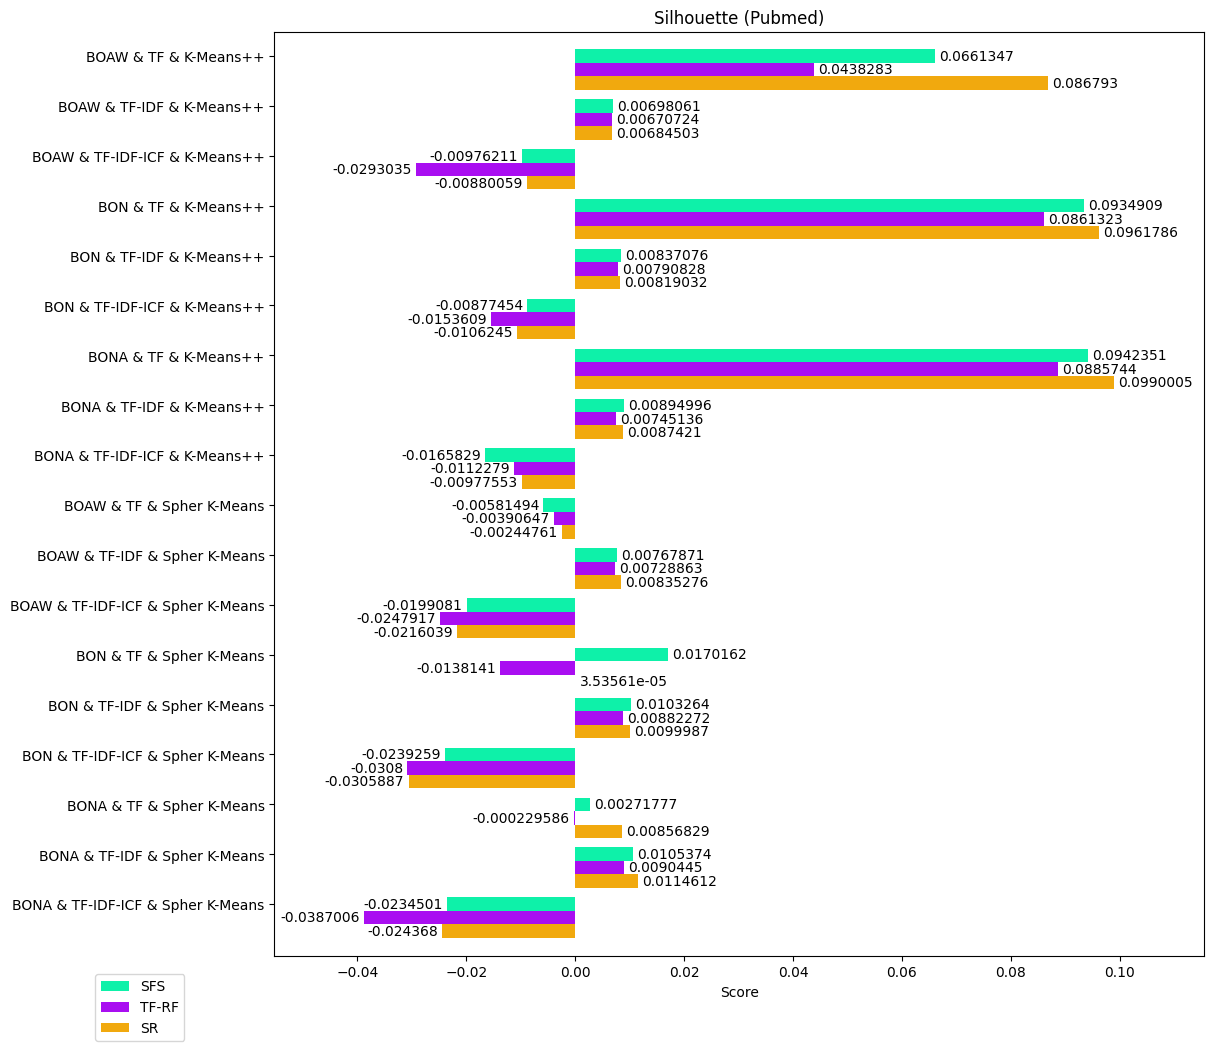

In [119]:
sfs = [
    # K-Means++
    pubmed_boaw_sfs_tf_kmeansPlus_silhouette,
    pubmed_boaw_sfs_tfIdf_kmeansPlus_silhouette,
    pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bon_sfs_tf_kmeansPlus_silhouette,
    pubmed_bon_sfs_tfIdf_kmeansPlus_silhouette,
    pubmed_bon_sfs_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bona_sfs_tf_kmeansPlus_silhouette,
    pubmed_bona_sfs_tfIdf_kmeansPlus_silhouette,
    pubmed_bona_sfs_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    pubmed_boaw_sfs_tf_spherKmeans_silhouette,
    pubmed_boaw_sfs_tfIdf_spherKmeans_silhouette,
    pubmed_boaw_sfs_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bon_sfs_tf_spherKmeans_silhouette,
    pubmed_bon_sfs_tfIdf_spherKmeans_silhouette,
    pubmed_bon_sfs_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bona_sfs_tf_spherKmeans_silhouette,
    pubmed_bona_sfs_tfIdf_spherKmeans_silhouette,
    pubmed_bona_sfs_tfIdfIcf_spherKmeans_silhouette,
]
tfrf = [
    # K-Means++
    pubmed_boaw_tfrf_tf_kmeansPlus_silhouette,
    pubmed_boaw_tfrf_tfIdf_kmeansPlus_silhouette,
    pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bon_tfrf_tf_kmeansPlus_silhouette,
    pubmed_bon_tfrf_tfIdf_kmeansPlus_silhouette,
    pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bona_tfrf_tf_kmeansPlus_silhouette,
    pubmed_bona_tfrf_tfIdf_kmeansPlus_silhouette,
    pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    pubmed_boaw_tfrf_tf_spherKmeans_silhouette,
    pubmed_boaw_tfrf_tfIdf_spherKmeans_silhouette,
    pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bon_tfrf_tf_spherKmeans_silhouette,
    pubmed_bon_tfrf_tfIdf_spherKmeans_silhouette,
    pubmed_bon_tfrf_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bona_tfrf_tf_spherKmeans_silhouette,
    pubmed_bona_tfrf_tfIdf_spherKmeans_silhouette,
    pubmed_bona_tfrf_tfIdfIcf_spherKmeans_silhouette,
]
sr = [
    # K-Means++
    pubmed_boaw_sr_tf_kmeansPlus_silhouette,
    pubmed_boaw_sr_tfIdf_kmeansPlus_silhouette,
    pubmed_boaw_sr_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bon_sr_tf_kmeansPlus_silhouette,
    pubmed_bon_sr_tfIdf_kmeansPlus_silhouette,
    pubmed_bon_sr_tfIdfIcf_kmeansPlus_silhouette,
    pubmed_bona_sr_tf_kmeansPlus_silhouette,
    pubmed_bona_sr_tfIdf_kmeansPlus_silhouette,
    pubmed_bona_sr_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    pubmed_boaw_sr_tf_spherKmeans_silhouette,
    pubmed_boaw_sr_tfIdf_spherKmeans_silhouette,
    pubmed_boaw_sr_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bon_sr_tf_spherKmeans_silhouette,
    pubmed_bon_sr_tfIdf_spherKmeans_silhouette,
    pubmed_bon_sr_tfIdfIcf_spherKmeans_silhouette,
    pubmed_bona_sr_tf_spherKmeans_silhouette,
    pubmed_bona_sr_tfIdf_spherKmeans_silhouette,
    pubmed_bona_sr_tfIdfIcf_spherKmeans_silhouette,
]
plotResult('Silhouette (Pubmed)', sfs, tfrf, sr)

In [11]:
pubmed_bona_tf = tf(pubmed_bona)
pubmed_bona_tf_kmeansPlus = kmeans_plus(k=4, data=pubmed_bona_tf)
pubmed_bona_tf_kmeansPlus_silhouette = silhouette(pubmed_bona_tf, pubmed_bona_tf_kmeansPlus)
pubmed_bona_tf_kmeansPlus_purity = purity(pubmedLabel, pubmed_bona_tf_kmeansPlus)
pubmed_bona_tf_kmeansPlus_ami = ami(pubmedLabel, pubmed_bona_tf_kmeansPlus)

In [16]:
pubmed_bona_tf_kmeansPlus_silhouette, pubmed_bona_sr_tf_kmeansPlus_silhouette

(-0.014053803906740278, 0.09900051614601167)

In [17]:
pubmed_bona_tf_kmeansPlus_purity, pubmed_bona_sr_tf_kmeansPlus_purity

(0.45625, 0.30675)

In [18]:
pubmed_bona_tf_kmeansPlus_ami, pubmed_bona_sr_tf_kmeansPlus_ami

(0.309399411615199, 0.041477228367351876)

#### Scopus silhouette

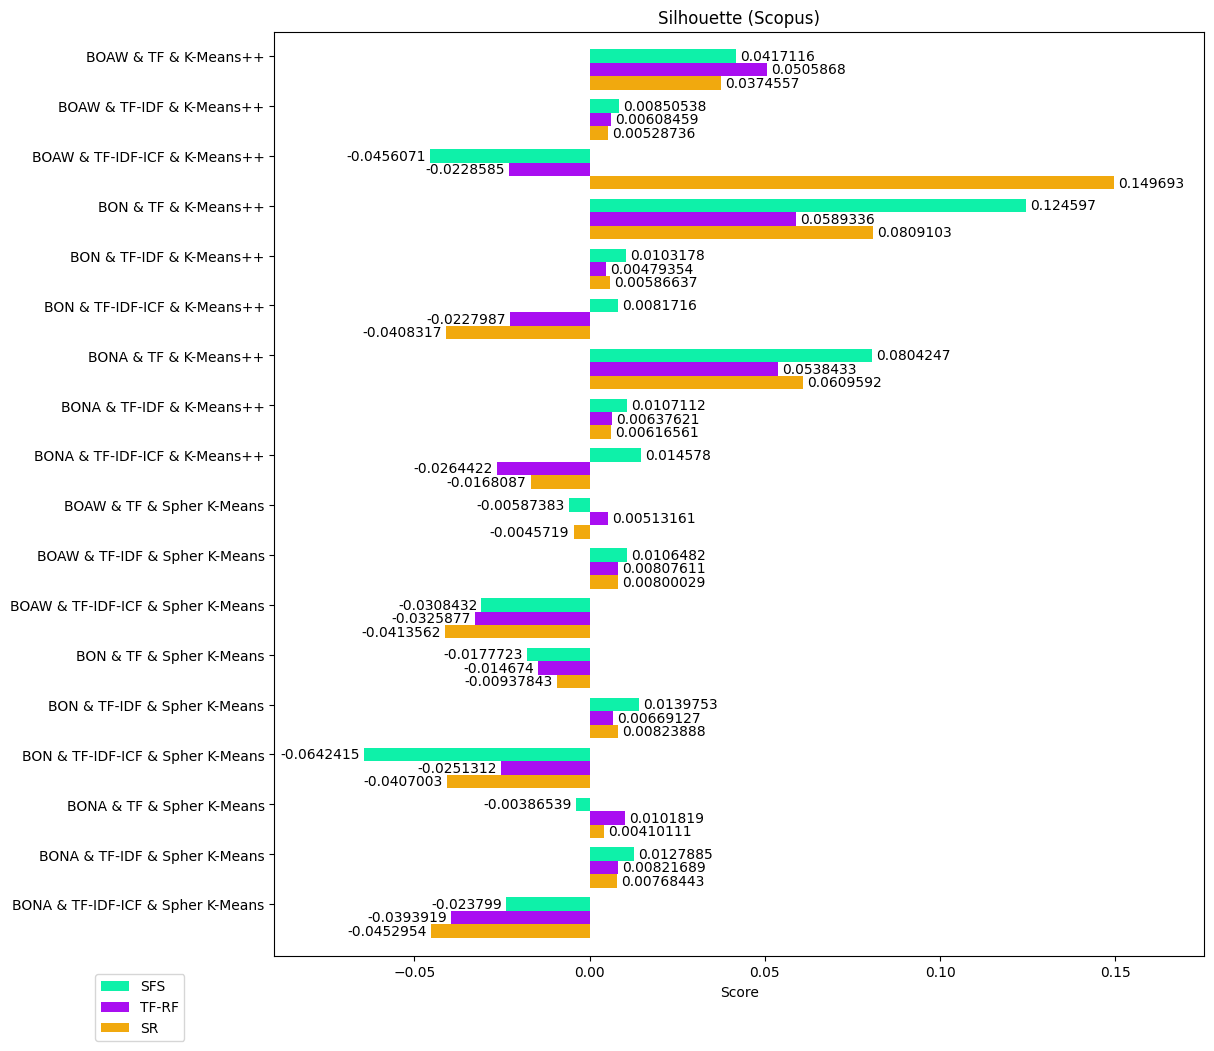

In [120]:
sfs = [
    # K-Means++
    scopus_boaw_sfs_tf_kmeansPlus_silhouette,
    scopus_boaw_sfs_tfIdf_kmeansPlus_silhouette,
    scopus_boaw_sfs_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bon_sfs_tf_kmeansPlus_silhouette,
    scopus_bon_sfs_tfIdf_kmeansPlus_silhouette,
    scopus_bon_sfs_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bona_sfs_tf_kmeansPlus_silhouette,
    scopus_bona_sfs_tfIdf_kmeansPlus_silhouette,
    scopus_bona_sfs_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    scopus_boaw_sfs_tf_spherKmeans_silhouette,
    scopus_boaw_sfs_tfIdf_spherKmeans_silhouette,
    scopus_boaw_sfs_tfIdfIcf_spherKmeans_silhouette,
    scopus_bon_sfs_tf_spherKmeans_silhouette,
    scopus_bon_sfs_tfIdf_spherKmeans_silhouette,
    scopus_bon_sfs_tfIdfIcf_spherKmeans_silhouette,
    scopus_bona_sfs_tf_spherKmeans_silhouette,
    scopus_bona_sfs_tfIdf_spherKmeans_silhouette,
    scopus_bona_sfs_tfIdfIcf_spherKmeans_silhouette,
]
tfrf = [
    # K-Means++
    scopus_boaw_tfrf_tf_kmeansPlus_silhouette,
    scopus_boaw_tfrf_tfIdf_kmeansPlus_silhouette,
    scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bon_tfrf_tf_kmeansPlus_silhouette,
    scopus_bon_tfrf_tfIdf_kmeansPlus_silhouette,
    scopus_bon_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bona_tfrf_tf_kmeansPlus_silhouette,
    scopus_bona_tfrf_tfIdf_kmeansPlus_silhouette,
    scopus_bona_tfrf_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    scopus_boaw_tfrf_tf_spherKmeans_silhouette,
    scopus_boaw_tfrf_tfIdf_spherKmeans_silhouette,
    scopus_boaw_tfrf_tfIdfIcf_spherKmeans_silhouette,
    scopus_bon_tfrf_tf_spherKmeans_silhouette,
    scopus_bon_tfrf_tfIdf_spherKmeans_silhouette,
    scopus_bon_tfrf_tfIdfIcf_spherKmeans_silhouette,
    scopus_bona_tfrf_tf_spherKmeans_silhouette,
    scopus_bona_tfrf_tfIdf_spherKmeans_silhouette,
    scopus_bona_tfrf_tfIdfIcf_spherKmeans_silhouette,
]
sr = [
    # K-Means++
    scopus_boaw_sr_tf_kmeansPlus_silhouette,
    scopus_boaw_sr_tfIdf_kmeansPlus_silhouette,
    scopus_boaw_sr_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bon_sr_tf_kmeansPlus_silhouette,
    scopus_bon_sr_tfIdf_kmeansPlus_silhouette,
    scopus_bon_sr_tfIdfIcf_kmeansPlus_silhouette,
    scopus_bona_sr_tf_kmeansPlus_silhouette,
    scopus_bona_sr_tfIdf_kmeansPlus_silhouette,
    scopus_bona_sr_tfIdfIcf_kmeansPlus_silhouette,
    # Spherical K-Means
    scopus_boaw_sr_tf_spherKmeans_silhouette,
    scopus_boaw_sr_tfIdf_spherKmeans_silhouette,
    scopus_boaw_sr_tfIdfIcf_spherKmeans_silhouette,
    scopus_bon_sr_tf_spherKmeans_silhouette,
    scopus_bon_sr_tfIdf_spherKmeans_silhouette,
    scopus_bon_sr_tfIdfIcf_spherKmeans_silhouette,
    scopus_bona_sr_tf_spherKmeans_silhouette,
    scopus_bona_sr_tfIdf_spherKmeans_silhouette,
    scopus_bona_sr_tfIdfIcf_spherKmeans_silhouette,
]
plotResult('Silhouette (Scopus)', sfs, tfrf, sr)

### Plot purity

#### Pubmed purity

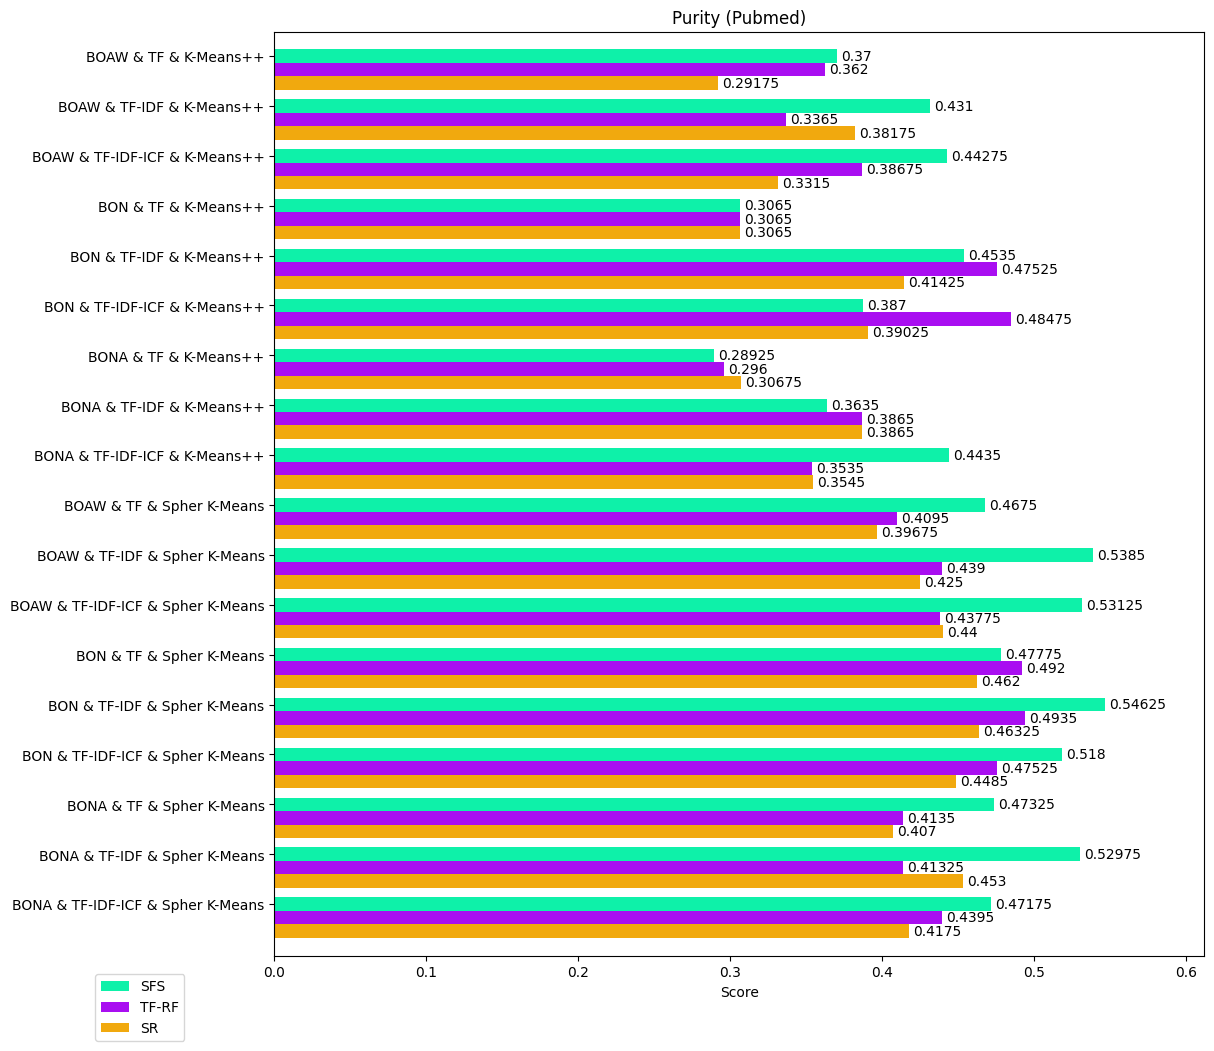

In [121]:
sfs = [
    # K-Means++
    pubmed_boaw_sfs_tf_kmeansPlus_purity,
    pubmed_boaw_sfs_tfIdf_kmeansPlus_purity,
    pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_purity,
    pubmed_bon_sfs_tf_kmeansPlus_purity,
    pubmed_bon_sfs_tfIdf_kmeansPlus_purity,
    pubmed_bon_sfs_tfIdfIcf_kmeansPlus_purity,
    pubmed_bona_sfs_tf_kmeansPlus_purity,
    pubmed_bona_sfs_tfIdf_kmeansPlus_purity,
    pubmed_bona_sfs_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    pubmed_boaw_sfs_tf_spherKmeans_purity,
    pubmed_boaw_sfs_tfIdf_spherKmeans_purity,
    pubmed_boaw_sfs_tfIdfIcf_spherKmeans_purity,
    pubmed_bon_sfs_tf_spherKmeans_purity,
    pubmed_bon_sfs_tfIdf_spherKmeans_purity,
    pubmed_bon_sfs_tfIdfIcf_spherKmeans_purity,
    pubmed_bona_sfs_tf_spherKmeans_purity,
    pubmed_bona_sfs_tfIdf_spherKmeans_purity,
    pubmed_bona_sfs_tfIdfIcf_spherKmeans_purity,
]
tfrf = [
    # K-Means++
    pubmed_boaw_tfrf_tf_kmeansPlus_purity,
    pubmed_boaw_tfrf_tfIdf_kmeansPlus_purity,
    pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_purity,
    pubmed_bon_tfrf_tf_kmeansPlus_purity,
    pubmed_bon_tfrf_tfIdf_kmeansPlus_purity,
    pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_purity,
    pubmed_bona_tfrf_tf_kmeansPlus_purity,
    pubmed_bona_tfrf_tfIdf_kmeansPlus_purity,
    pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    pubmed_boaw_tfrf_tf_spherKmeans_purity,
    pubmed_boaw_tfrf_tfIdf_spherKmeans_purity,
    pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_purity,
    pubmed_bon_tfrf_tf_spherKmeans_purity,
    pubmed_bon_tfrf_tfIdf_spherKmeans_purity,
    pubmed_bon_tfrf_tfIdfIcf_spherKmeans_purity,
    pubmed_bona_tfrf_tf_spherKmeans_purity,
    pubmed_bona_tfrf_tfIdf_spherKmeans_purity,
    pubmed_bona_tfrf_tfIdfIcf_spherKmeans_purity,
]
sr = [
    # K-Means++
    pubmed_boaw_sr_tf_kmeansPlus_purity,
    pubmed_boaw_sr_tfIdf_kmeansPlus_purity,
    pubmed_boaw_sr_tfIdfIcf_kmeansPlus_purity,
    pubmed_bon_sr_tf_kmeansPlus_purity,
    pubmed_bon_sr_tfIdf_kmeansPlus_purity,
    pubmed_bon_sr_tfIdfIcf_kmeansPlus_purity,
    pubmed_bona_sr_tf_kmeansPlus_purity,
    pubmed_bona_sr_tfIdf_kmeansPlus_purity,
    pubmed_bona_sr_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    pubmed_boaw_sr_tf_spherKmeans_purity,
    pubmed_boaw_sr_tfIdf_spherKmeans_purity,
    pubmed_boaw_sr_tfIdfIcf_spherKmeans_purity,
    pubmed_bon_sr_tf_spherKmeans_purity,
    pubmed_bon_sr_tfIdf_spherKmeans_purity,
    pubmed_bon_sr_tfIdfIcf_spherKmeans_purity,
    pubmed_bona_sr_tf_spherKmeans_purity,
    pubmed_bona_sr_tfIdf_spherKmeans_purity,
    pubmed_bona_sr_tfIdfIcf_spherKmeans_purity,
]
plotResult('Purity (Pubmed)', sfs, tfrf, sr)

#### Scopus purity

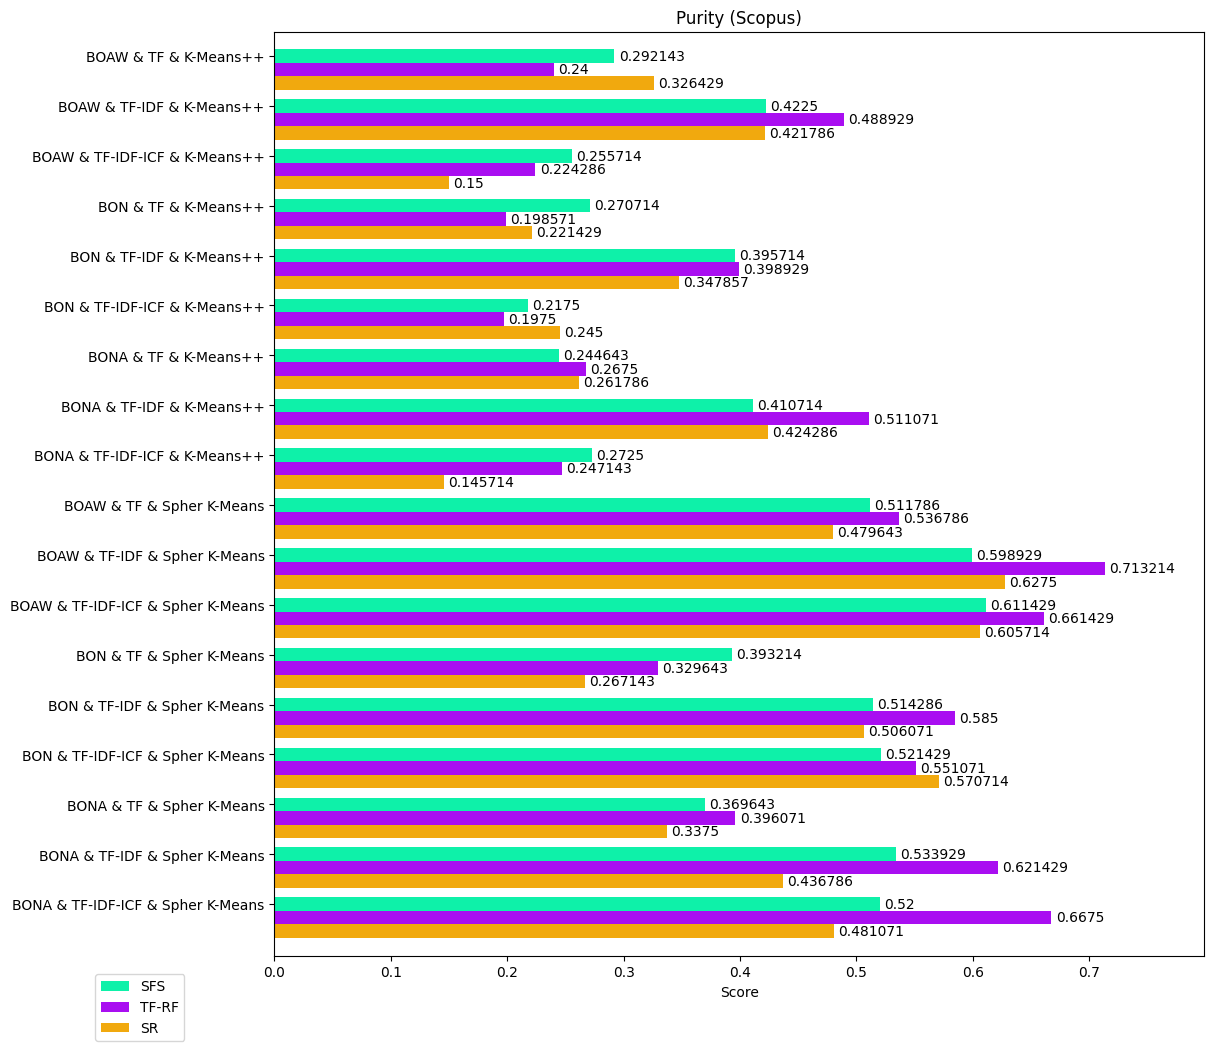

In [122]:
sfs = [
    # K-Means++
    scopus_boaw_sfs_tf_kmeansPlus_purity,
    scopus_boaw_sfs_tfIdf_kmeansPlus_purity,
    scopus_boaw_sfs_tfIdfIcf_kmeansPlus_purity,
    scopus_bon_sfs_tf_kmeansPlus_purity,
    scopus_bon_sfs_tfIdf_kmeansPlus_purity,
    scopus_bon_sfs_tfIdfIcf_kmeansPlus_purity,
    scopus_bona_sfs_tf_kmeansPlus_purity,
    scopus_bona_sfs_tfIdf_kmeansPlus_purity,
    scopus_bona_sfs_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    scopus_boaw_sfs_tf_spherKmeans_purity,
    scopus_boaw_sfs_tfIdf_spherKmeans_purity,
    scopus_boaw_sfs_tfIdfIcf_spherKmeans_purity,
    scopus_bon_sfs_tf_spherKmeans_purity,
    scopus_bon_sfs_tfIdf_spherKmeans_purity,
    scopus_bon_sfs_tfIdfIcf_spherKmeans_purity,
    scopus_bona_sfs_tf_spherKmeans_purity,
    scopus_bona_sfs_tfIdf_spherKmeans_purity,
    scopus_bona_sfs_tfIdfIcf_spherKmeans_purity,
]
tfrf = [
    # K-Means++
    scopus_boaw_tfrf_tf_kmeansPlus_purity,
    scopus_boaw_tfrf_tfIdf_kmeansPlus_purity,
    scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_purity,
    scopus_bon_tfrf_tf_kmeansPlus_purity,
    scopus_bon_tfrf_tfIdf_kmeansPlus_purity,
    scopus_bon_tfrf_tfIdfIcf_kmeansPlus_purity,
    scopus_bona_tfrf_tf_kmeansPlus_purity,
    scopus_bona_tfrf_tfIdf_kmeansPlus_purity,
    scopus_bona_tfrf_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    scopus_boaw_tfrf_tf_spherKmeans_purity,
    scopus_boaw_tfrf_tfIdf_spherKmeans_purity,
    scopus_boaw_tfrf_tfIdfIcf_spherKmeans_purity,
    scopus_bon_tfrf_tf_spherKmeans_purity,
    scopus_bon_tfrf_tfIdf_spherKmeans_purity,
    scopus_bon_tfrf_tfIdfIcf_spherKmeans_purity,
    scopus_bona_tfrf_tf_spherKmeans_purity,
    scopus_bona_tfrf_tfIdf_spherKmeans_purity,
    scopus_bona_tfrf_tfIdfIcf_spherKmeans_purity,
]
sr = [
    # K-Means++
    scopus_boaw_sr_tf_kmeansPlus_purity,
    scopus_boaw_sr_tfIdf_kmeansPlus_purity,
    scopus_boaw_sr_tfIdfIcf_kmeansPlus_purity,
    scopus_bon_sr_tf_kmeansPlus_purity,
    scopus_bon_sr_tfIdf_kmeansPlus_purity,
    scopus_bon_sr_tfIdfIcf_kmeansPlus_purity,
    scopus_bona_sr_tf_kmeansPlus_purity,
    scopus_bona_sr_tfIdf_kmeansPlus_purity,
    scopus_bona_sr_tfIdfIcf_kmeansPlus_purity,
    # Spherical K-Means
    scopus_boaw_sr_tf_spherKmeans_purity,
    scopus_boaw_sr_tfIdf_spherKmeans_purity,
    scopus_boaw_sr_tfIdfIcf_spherKmeans_purity,
    scopus_bon_sr_tf_spherKmeans_purity,
    scopus_bon_sr_tfIdf_spherKmeans_purity,
    scopus_bon_sr_tfIdfIcf_spherKmeans_purity,
    scopus_bona_sr_tf_spherKmeans_purity,
    scopus_bona_sr_tfIdf_spherKmeans_purity,
    scopus_bona_sr_tfIdfIcf_spherKmeans_purity,
]
plotResult('Purity (Scopus)', sfs, tfrf, sr)

### Plot AMI

#### Purity AMI

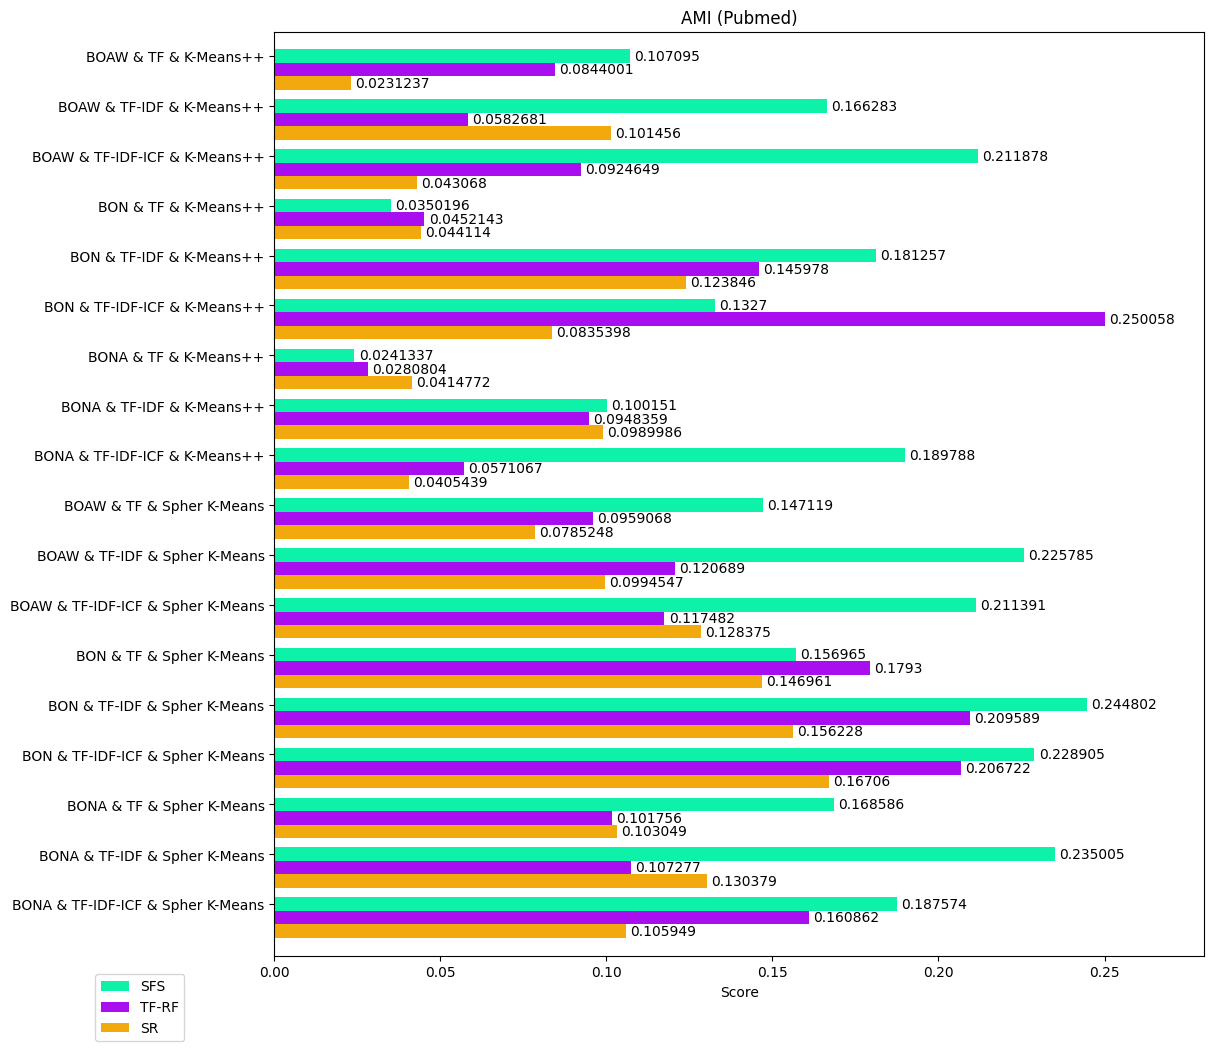

In [123]:
sfs = [
    # K-Means++
    pubmed_boaw_sfs_tf_kmeansPlus_ami,
    pubmed_boaw_sfs_tfIdf_kmeansPlus_ami,
    pubmed_boaw_sfs_tfIdfIcf_kmeansPlus_ami,
    pubmed_bon_sfs_tf_kmeansPlus_ami,
    pubmed_bon_sfs_tfIdf_kmeansPlus_ami,
    pubmed_bon_sfs_tfIdfIcf_kmeansPlus_ami,
    pubmed_bona_sfs_tf_kmeansPlus_ami,
    pubmed_bona_sfs_tfIdf_kmeansPlus_ami,
    pubmed_bona_sfs_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    pubmed_boaw_sfs_tf_spherKmeans_ami,
    pubmed_boaw_sfs_tfIdf_spherKmeans_ami,
    pubmed_boaw_sfs_tfIdfIcf_spherKmeans_ami,
    pubmed_bon_sfs_tf_spherKmeans_ami,
    pubmed_bon_sfs_tfIdf_spherKmeans_ami,
    pubmed_bon_sfs_tfIdfIcf_spherKmeans_ami,
    pubmed_bona_sfs_tf_spherKmeans_ami,
    pubmed_bona_sfs_tfIdf_spherKmeans_ami,
    pubmed_bona_sfs_tfIdfIcf_spherKmeans_ami,
]
tfrf = [
    # K-Means++
    pubmed_boaw_tfrf_tf_kmeansPlus_ami,
    pubmed_boaw_tfrf_tfIdf_kmeansPlus_ami,
    pubmed_boaw_tfrf_tfIdfIcf_kmeansPlus_ami,
    pubmed_bon_tfrf_tf_kmeansPlus_ami,
    pubmed_bon_tfrf_tfIdf_kmeansPlus_ami,
    pubmed_bon_tfrf_tfIdfIcf_kmeansPlus_ami,
    pubmed_bona_tfrf_tf_kmeansPlus_ami,
    pubmed_bona_tfrf_tfIdf_kmeansPlus_ami,
    pubmed_bona_tfrf_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    pubmed_boaw_tfrf_tf_spherKmeans_ami,
    pubmed_boaw_tfrf_tfIdf_spherKmeans_ami,
    pubmed_boaw_tfrf_tfIdfIcf_spherKmeans_ami,
    pubmed_bon_tfrf_tf_spherKmeans_ami,
    pubmed_bon_tfrf_tfIdf_spherKmeans_ami,
    pubmed_bon_tfrf_tfIdfIcf_spherKmeans_ami,
    pubmed_bona_tfrf_tf_spherKmeans_ami,
    pubmed_bona_tfrf_tfIdf_spherKmeans_ami,
    pubmed_bona_tfrf_tfIdfIcf_spherKmeans_ami,
]
sr = [
    # K-Means++
    pubmed_boaw_sr_tf_kmeansPlus_ami,
    pubmed_boaw_sr_tfIdf_kmeansPlus_ami,
    pubmed_boaw_sr_tfIdfIcf_kmeansPlus_ami,
    pubmed_bon_sr_tf_kmeansPlus_ami,
    pubmed_bon_sr_tfIdf_kmeansPlus_ami,
    pubmed_bon_sr_tfIdfIcf_kmeansPlus_ami,
    pubmed_bona_sr_tf_kmeansPlus_ami,
    pubmed_bona_sr_tfIdf_kmeansPlus_ami,
    pubmed_bona_sr_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    pubmed_boaw_sr_tf_spherKmeans_ami,
    pubmed_boaw_sr_tfIdf_spherKmeans_ami,
    pubmed_boaw_sr_tfIdfIcf_spherKmeans_ami,
    pubmed_bon_sr_tf_spherKmeans_ami,
    pubmed_bon_sr_tfIdf_spherKmeans_ami,
    pubmed_bon_sr_tfIdfIcf_spherKmeans_ami,
    pubmed_bona_sr_tf_spherKmeans_ami,
    pubmed_bona_sr_tfIdf_spherKmeans_ami,
    pubmed_bona_sr_tfIdfIcf_spherKmeans_ami,
]
plotResult('AMI (Pubmed)', sfs, tfrf, sr)

#### Scopus AMI

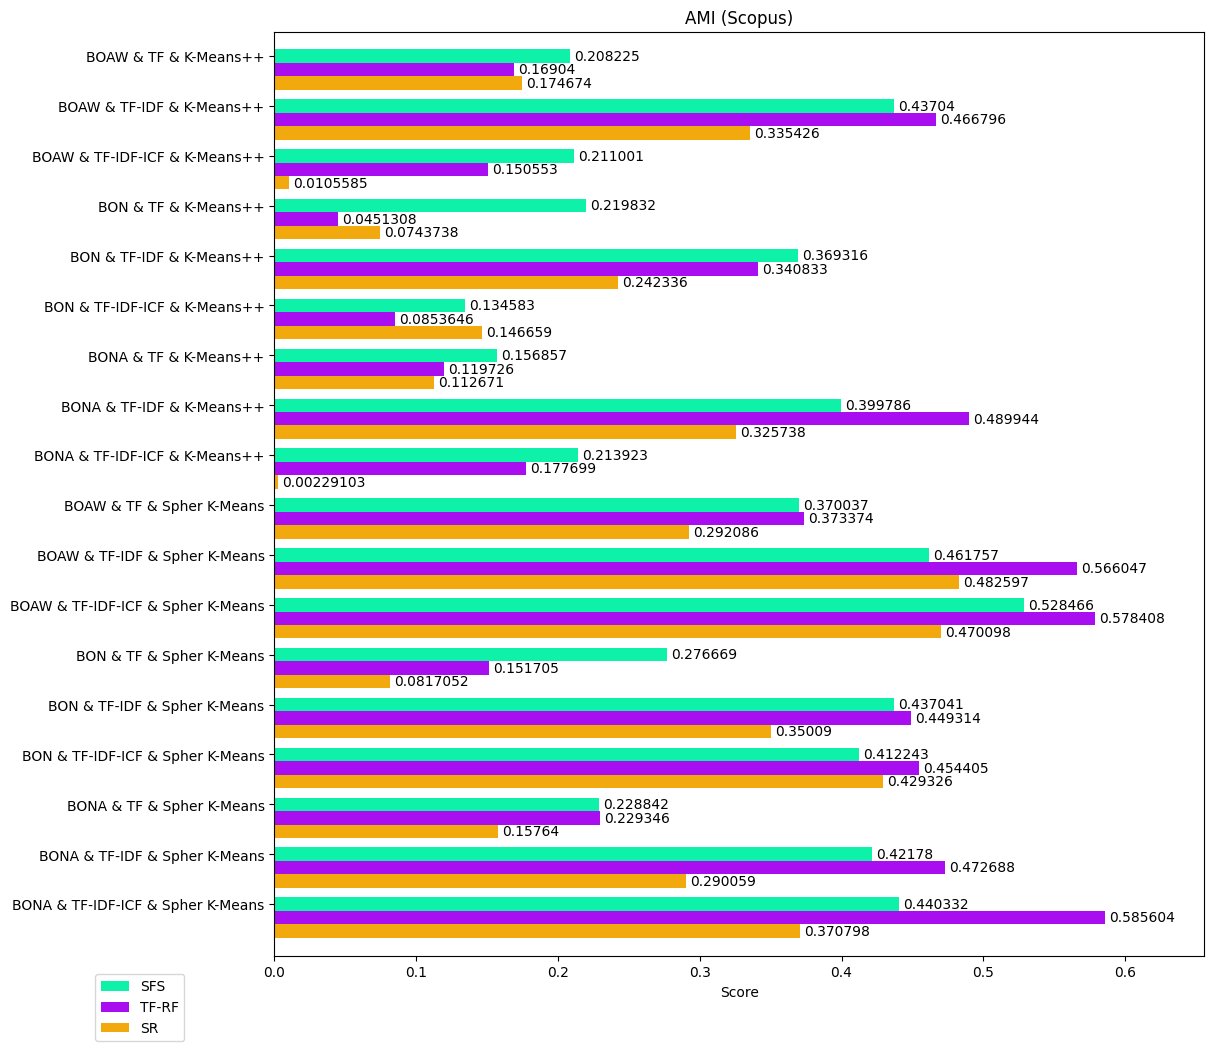

In [124]:
sfs = [
    # K-Means++
    scopus_boaw_sfs_tf_kmeansPlus_ami,
    scopus_boaw_sfs_tfIdf_kmeansPlus_ami,
    scopus_boaw_sfs_tfIdfIcf_kmeansPlus_ami,
    scopus_bon_sfs_tf_kmeansPlus_ami,
    scopus_bon_sfs_tfIdf_kmeansPlus_ami,
    scopus_bon_sfs_tfIdfIcf_kmeansPlus_ami,
    scopus_bona_sfs_tf_kmeansPlus_ami,
    scopus_bona_sfs_tfIdf_kmeansPlus_ami,
    scopus_bona_sfs_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    scopus_boaw_sfs_tf_spherKmeans_ami,
    scopus_boaw_sfs_tfIdf_spherKmeans_ami,
    scopus_boaw_sfs_tfIdfIcf_spherKmeans_ami,
    scopus_bon_sfs_tf_spherKmeans_ami,
    scopus_bon_sfs_tfIdf_spherKmeans_ami,
    scopus_bon_sfs_tfIdfIcf_spherKmeans_ami,
    scopus_bona_sfs_tf_spherKmeans_ami,
    scopus_bona_sfs_tfIdf_spherKmeans_ami,
    scopus_bona_sfs_tfIdfIcf_spherKmeans_ami,
]
tfrf = [
    # K-Means++
    scopus_boaw_tfrf_tf_kmeansPlus_ami,
    scopus_boaw_tfrf_tfIdf_kmeansPlus_ami,
    scopus_boaw_tfrf_tfIdfIcf_kmeansPlus_ami,
    scopus_bon_tfrf_tf_kmeansPlus_ami,
    scopus_bon_tfrf_tfIdf_kmeansPlus_ami,
    scopus_bon_tfrf_tfIdfIcf_kmeansPlus_ami,
    scopus_bona_tfrf_tf_kmeansPlus_ami,
    scopus_bona_tfrf_tfIdf_kmeansPlus_ami,
    scopus_bona_tfrf_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    scopus_boaw_tfrf_tf_spherKmeans_ami,
    scopus_boaw_tfrf_tfIdf_spherKmeans_ami,
    scopus_boaw_tfrf_tfIdfIcf_spherKmeans_ami,
    scopus_bon_tfrf_tf_spherKmeans_ami,
    scopus_bon_tfrf_tfIdf_spherKmeans_ami,
    scopus_bon_tfrf_tfIdfIcf_spherKmeans_ami,
    scopus_bona_tfrf_tf_spherKmeans_ami,
    scopus_bona_tfrf_tfIdf_spherKmeans_ami,
    scopus_bona_tfrf_tfIdfIcf_spherKmeans_ami,
]
sr = [
    # K-Means++
    scopus_boaw_sr_tf_kmeansPlus_ami,
    scopus_boaw_sr_tfIdf_kmeansPlus_ami,
    scopus_boaw_sr_tfIdfIcf_kmeansPlus_ami,
    scopus_bon_sr_tf_kmeansPlus_ami,
    scopus_bon_sr_tfIdf_kmeansPlus_ami,
    scopus_bon_sr_tfIdfIcf_kmeansPlus_ami,
    scopus_bona_sr_tf_kmeansPlus_ami,
    scopus_bona_sr_tfIdf_kmeansPlus_ami,
    scopus_bona_sr_tfIdfIcf_kmeansPlus_ami,
    # Spherical K-Means
    scopus_boaw_sr_tf_spherKmeans_ami,
    scopus_boaw_sr_tfIdf_spherKmeans_ami,
    scopus_boaw_sr_tfIdfIcf_spherKmeans_ami,
    scopus_bon_sr_tf_spherKmeans_ami,
    scopus_bon_sr_tfIdf_spherKmeans_ami,
    scopus_bon_sr_tfIdfIcf_spherKmeans_ami,
    scopus_bona_sr_tf_spherKmeans_ami,
    scopus_bona_sr_tfIdf_spherKmeans_ami,
    scopus_bona_sr_tfIdfIcf_spherKmeans_ami,
]
plotResult('AMI (Scopus)', sfs, tfrf, sr)